In [ ]:
# === Standardbibliothek ===
import pickle
from pathlib import Path
from pprint import pprint
from typing import Dict, List 

# Datenverarbeitung, Numerik & Visualisierung
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Hyperparameter-Optimierung
from hyperopt import STATUS_OK, Trials, fmin, hp, space_eval, tpe

# Machine Learning & Experiment-Tracking
import mlflow
import xgboost as xgb
from mlflow import MlflowClient
from mlflow.data import from_pandas
from mlflow.models import infer_signature

# Scikit-learn (alphabetisch nach Modul sortiert)
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    auc,
    average_precision_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_recall_curve,
    precision_recall_fscore_support, # Alle Metriken zusammengefasst
    precision_score,
    r2_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


# Modell

Um das Routing von Online-Zahlungen zu optimieren und die Erfolgsrate zu maximieren, wir in diesem Jupyter Notebook ein Klassifikationsmodell entwickelt. Seine Aufgabe ist es, für jeden Zahlungsvorgang zu prognostizieren, ob dieser erfolgreich (1) oder nicht erfolgreich (0) sein wird.

Im praktischen Einsatz analysiert das Modell eine anstehende Transaktion und berechnet für jeden der vier Partner-PSPs eine separate Erfolgswahrscheinlichkeit.

## Evaluierung



| | **Vorhersage: Abbruch (0)** | **Vorhersage: Erfolg (1)** |
| :--- | :--- | :--- |
| **Wahrheit: Abbruch (0)** | **True Negative (TN)** <br> *Wahr Negativ* <br><br> \* **Erklärung:** Das Modell hat korrekt einen **Abbruch** vorhergesagt. <br> \* **Geschäftsauswirkung:** Guter Fall. Ein nicht funktionierender PSP-Versuch wurde als solcher erkannt und vermieden. | **False Positive (FP)** <br> *Falsch Positiv (Fehler 1. Art)* <br><br> \* **Erklärung:** Das Modell hat fälschlicherweise einen **Erfolg** vorhergesagt. <br> \* **Geschäftsauswirkung:** **Schlimmster Fehler\!** Führt zu einem fehlgeschlagenen Zahlungsversuch, direkten Kosten und einem unzufriedenen Kunden. Diese Fehlerart soll durch eine hohe **Precision** minimiert werden. |
| **Wahrheit: Erfolg (1)** | **False Negative (FN)** <br> *Falsch Negativ (Fehler 2. Art)* <br><br> \* **Erklärung:** Das Modell hat fälschlicherweise einen **Abbruch** vorhergesagt. <br> \* **Geschäftsauswirkung:** Zweitschlimmster Fehler. Eine funktionierende Zahlung wurde nicht als Chance erkannt. Diese Fehlerart soll durch einen hohen **Recall** minimiert werden. | **True Positive (TP)** <br> *Wahr Positiv* <br><br> \* **Erklärung:** Das Modell hat korrekt einen **Erfolg** vorhergesagt. <br> \* **Geschäftsauswirkung:** **Optimaler Fall.** Eine erfolgreiche Zahlung wird korrekt identifiziert und durchgeführt. Führt zu Umsatz und einem zufriedenen Kunden. |


  * **Precision (Präzision):** Wie verlässlich sind die "Erfolg"-Vorhersagen?

      * `TP / (TP + FP)` (Anteil der echten Erfolge an allen vorhergesagten Erfolgen)

        * **Wichtigkeit**: Sehr hoch. Sie sagt aus, wie oft eine Erfolgsvorhersage auch in einem Erfolg endet. Wenn Sie hoch ist, sind die gefundenen Erfolge belastbare und zuverlässige Funde. Sie ist direkt mit der Kundenzufriedenheit verknüpft, da eine hohe Precision die Anzahl der fehlgeschlagenen Versuche minimiert. Falls sie allerdings zu sehr priorisiert wird, werden fast keine Erfolge gefunden, da zu streng danach ausgerichtet wird, dass diese auch ganz sicher ein Erfolg sein müssen.

  * **Recall (Sensitivität):** Wie viele der echten Erfolge wurden gefunden?

      * `TP / (TP + FN)` (Anteil der gefundenen Erfolge an allen tatsächlichen Erfolgen)

        * **Wichtigkeit**: Sehr Hoch. Diese Metrik muss zusätzlich zur Precision hoch gehalten werden, für ein gutes Modell. Wenn der Recall und die Precision zusammen in Relation hoch sind, werden Erfolge nicht übersehen, und sind auch tatsächlich fast immer ein True Positive Erfolg. Ein niedriger Recall bedeutet, dass das Modell Gewinner übersieht.

**->** Primärziel: Recall und Precision müssen in Relation hoch sein, wobei die Precision für unseren Use Case jedoch höher angesetzt wird, da die Kundenzufriedenheit das höchste Ziel ist. Dieses wird erreicht, wenn gewählt PSP Dienstleister nicht abbrechen, also die gewählten Erfolgs PSPs verlässlich sind (Precision).

  * **AUC (Area Under the Curve) - :**

      * Im Gegensatz zu den anderen Metriken kann der AUC-Score **nicht aus einer einzigen Konfusionsmatrix** berechnet werden.
      * **Warum?** Eine Konfusionsmatrix entsteht immer bei einem *festen Schwellenwert* (z.B. 0.5), ab dem eine Vorhersage als "Erfolg" gilt. Der AUC-Score hingegen bewertet die Modell-Performance über **alle möglichen Schwellenwerte** hinweg. Er misst die grundsätzliche Fähigkeit des Modells, einer Zahlung, die tatsächlich erfolgreich sein wird, eine höhere Erfolgswahrscheinlichkeit zuzuweisen,  als einer Zahlung, die tatsächlich scheitern wird.

         * **Wichtigkeit**: Sehr Hoch. AUC ist die wichtigste Metrik zur Beurteilung der allgemeinen Vorhersagekraft des Modells. Es sagt aus, wie gut das Modell grundsätzlich ist. Vor allem durch die Klassenungleicheit unde wichtige Metrik.

  * **F1-Score:** Ein ausbalancierter Mittelwert aus Precision und Recall. Er ist dann hoch, wenn beide Metriken gut sind.

      * `2 * (Precision * Recall) / (Precision + Recall)`

        * **Wichtigkeit**:  Hoch. Der Standard-F1-Score gewichtet Precision und Recall gleich. In deinem Fall ist ein FP (schlechte Precision) jedoch deutlich teurer als ein FN (schlechter Recall). Daher ist der F1-Score ein guter Indikator für die Modellauswahl, aber im finalen Reporting an die Businesspartner solltest du immer Precision und Recall separat betrachten und die geschäftlichen Kosten der jeweiligen Fehlerarten betonen.
  * **Spezifität (Specificity):** Wie viele der echten Abbrüche wurden erkannt?

      * `TN / (TN + FP)` (Anteil der erkannten Abbrüche an allen tatsächlichen Abbrüchen)

        * **Wichtigkeit**: Hoch. Die Spezifität misst, wie gut das Modell die tatsächlichen Abbrüche korrekt erkennt. Ein hoher Wert bedeutet, das Modell schlägt nur selten fälschlicherweise einen zum Scheitern verurteilten PSP als "erfolgreich" vor. In unserem Use Case gibt es wesentlich mehr Misserfolge, weshalb es leicht ist einen guten Wert zu erzielen, da er künstlich hochgetrieben werden kann, indem das Modell fast immer "Abbruch" vorhersagt. Aber eine hohe Spezifität bei einem Modell, das gleichzeitig einen guten Recall und eine gute Precision aufweist, ist ein starkes Zeichen für dessen Zuverlässigkeit.
        


  * **Genauigkeit (Accuracy):** Wie viele Vorhersagen waren insgesamt richtig?

      * `(TP + TN) / (Summe aller 4 Felder)`

        * **Wichtigkeit**: Niedrig. Die Metrik ist bei unausgeglichenen Daten irreführend und wenig aussagekräftig für die primären Geschäftsziele.



# Dataframes laden

Dieser Code-Abschnitt lädt den final aufbereiteten DataFrames aus den Pickle-Dateien `df_classification_reduced.pkl`, `df_classification_featureSelection.pkl`, `df_classification_pca_original_features.pkl` und `df_Classification.pkl`. Da beim Speichern und Laden von Daten die spezifischen Datentypen verloren gehen können (z.B. werden aus Zahlen `object`-Typen), wird anschließend ein robuster Konvertierungsprozess durchgeführt.

Zuerst identifiziert und "schützt" der Code alle Spalten, die bereits ein korrektes `datetime`-Format haben. Danach optimiert die Funktion `df.convert_dtypes()` alle anderen Spalten automatisch in den bestmöglichen, speichereffizienten Datentyp. 

Die Funktion `df.convert_dtypes()` ist eine intelligente Methode in Pandas, um die Datentypen eines DataFrames automatisch zu optimieren und in das bestmögliche, speichereffizienteste Format umzuwandeln.

**Was im Detail passiert:**


* Eine `object`-Spalte, die nur Zahlen enthält (z.B. `['1', '2', '3']`), wird in einen numerischen Typ umgewandelt.
* Eine `object`-Spalte, die nur Text enthält, wird in den modernen `string`-Typ umgewandelt, der für Textoperationen optimiert ist.
* Eine `float64`-Spalte, die nur Ganzzahlen enthält (z.B. `[1.0, 2.0, 3.0]`), wird in einen Integer-Typ umgewandelt.

In [6]:
# --- HILFSFUNKTION ZUM LADEN UND KONVERTIEREN ---
def load_and_convert_pickle(pkl_path):
    """
    Lädt eine Pickle-Datei als DataFrame und optimiert sofort die Datentypen,
    während datetime-Spalten geschützt werden.
    """
    try:
        # 1. Pickle-Datei laden
        df = pd.read_pickle(pkl_path)
        print(f"--- DataFrame aus '{pkl_path.name}' geladen ---")
        print("Datentypen VOR der Konvertierung:")
        df.info(verbose=False)

        # 2. Datentypen intelligent konvertieren
        # a) Merke dir, welche Spalten bereits datetime sind
        datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
        
        # b) Führe die allgemeine, automatische Konvertierung durch
        df = df.convert_dtypes()
        
        # c) Stelle sicher, dass die datetime-Spalten ihren Typ behalten haben
        for col in datetime_cols:
            df[col] = pd.to_datetime(df[col])

        print("\nDatentypen NACH der Konvertierung:")
        df.info(verbose=False)
        print("-" * 50)
        
        return df

    except FileNotFoundError:
        print(f"FEHLER: Datei '{pkl_path.name}' nicht im Verzeichnis '{pkl_path.parent}' gefunden.")
        return None
    except Exception as e:
        print(f"FEHLER beim Laden von '{pkl_path.name}': {e}")
        return None

# --- HAUPTSKRIPT ---

# Pfad-Definitionen
this_dir = Path.cwd()
data_dir = this_dir / ".." / "Data"
data_dir = data_dir.resolve()

# In Jupyter alle Spalten komplett anzeigen
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 10)

# === LADE UND KONVERTIERE ALLE DATAFRAMES MIT DER HELFERFUNKTION ===

# 1. df_classification_reduced.pkl
pkl_path_reduced = data_dir / "df_classification_reduced.pkl"
df_classification_reduced = load_and_convert_pickle(pkl_path_reduced)

# 2. df_classification_featureSelection.pkl
pkl_path_fs = data_dir / "df_classification_featureSelection.pkl"
df_classification_featureSelection = load_and_convert_pickle(pkl_path_fs)

# 3. df_classification_pca_original_features.pkl
pkl_path_pca_orig = data_dir / "df_classification_pca_original_features.pkl"
df_classification_pca_original_features = load_and_convert_pickle(pkl_path_pca_orig)

# 4. df_Classification.pkl (Das vollständige/Basis-DF)
pkl_path_full = data_dir / "df_Classification.pkl"
df_Classification = load_and_convert_pickle(pkl_path_full)

--- DataFrame aus 'df_classification_reduced.pkl' geladen ---
Datentypen VOR der Konvertierung:
<class 'pandas.core.frame.DataFrame'>
Index: 50329 entries, 0 to 50328
Columns: 15 entries, oh__card_Visa to bin__success
dtypes: Float64(2), Int32(3), Int64(10)
memory usage: 6.3 MB

Datentypen NACH der Konvertierung:
<class 'pandas.core.frame.DataFrame'>
Index: 50329 entries, 0 to 50328
Columns: 15 entries, oh__card_Visa to bin__success
dtypes: Float64(2), Int32(3), Int64(10)
memory usage: 6.3 MB
--------------------------------------------------
--- DataFrame aus 'df_classification_featureSelection.pkl' geladen ---
Datentypen VOR der Konvertierung:
<class 'pandas.core.frame.DataFrame'>
Index: 50329 entries, 0 to 50328
Columns: 11 entries, bin__3D_secured to remainder__amount_scaled
dtypes: Float64(1), Int32(1), Int64(9)
memory usage: 4.9 MB

Datentypen NACH der Konvertierung:
<class 'pandas.core.frame.DataFrame'>
Index: 50329 entries, 0 to 50328
Columns: 11 entries, bin__3D_secured to rem

# MLflow einrichten

MLflow ist eine Open-Source-Plattform zur Verwaltung des gesamten Machine-Learning-Lebenszyklus. Wir setzen MLflow ein, um alle unsere Experimente, inklusive der verwendeten Parameter, Code-Versionen und resultierenden Metriken wie AUC oder Precision, systematisch zu protokollieren. Dies garantiert die Reproduzierbarkeit unserer Ergebnisse und ermöglicht einen klaren, visuellen Vergleich der verschiedenen Modelle und Datenansätze, um fundierte Entscheidungen zu treffen.

**In Powershell starten Sie den Tracking-Server mit folgendem Befehl:**
`mlflow server --host 127.0.0.1 --port 8080`

In [7]:
# Startet den Befehl in einem neuen, minimierten Konsolenfenster
!start /B mlflow server --host 127.0.0.1 --port 8080

# --- Konfiguration ---
tracking_uri   = "http://127.0.0.1:8080"

# --- Setup Tracking + Client ---
mlflow.set_tracking_uri(tracking_uri)
client = MlflowClient()

# Baseline Modell

Die logistische Regression wird als robustes Baseline-Modell eingesetzt, um einen grundlegenden Leistungs-Benchmark zu etablieren. Dieser dient als Referenzwert: Jedes komplexere Modell (z.B. Gradient Boosting) muss diesen Wert signifikant übertreffen, um seine zusätzliche Komplexität zu rechtfertigen.

Gleichzeitig wird die Baseline genutzt, um die Vorhersagekraft der unterschiedlichen vorbereiteten Datensätze (Feature-Sets) zu vergleichen und die effektivste Datenbasis für die weitere Modellierung zu identifizieren.

In [8]:
experiment_name = "ME_Classification_Baseline"

def run_classification_experiment(df, df_name, pkl_file_name, target="bin__success"):

    print("-" * 60)
    print(f"Starte MLflow Run für: {df_name}")

    # Datenvorbereitung (Target und Features)
    X = df.drop(columns=[target])
    y = df[target].astype(int)

    # Integer-Features robust machen
    int_cols = X.select_dtypes(include=["int8","int16","int32","int64","uint8","uint16","uint32","uint64"]).columns
    if len(int_cols) > 0:
        X[int_cols] = X[int_cols].astype("float64")

    # 2. Split
    test_size = 0.2
    random_state = 42
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    # Parameter und Modell
    params = {
        "Model": "LogisticRegression",
        "test_size": test_size,
        "random_state": random_state,
        "n_features": X.shape[1],
        "dataframe_source": pkl_file_name
    }

    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Vorhersagen
    proba_tr = model.predict_proba(X_train)[:, 1]
    proba_te = model.predict_proba(X_val)[:, 1]
    pred_tr  = (proba_tr >= 0.5).astype(int)
    pred_te  = (proba_te >= 0.5).astype(int)

    # Metriken berechnen
    metrics = {
        # Train
        "train_accuracy": np.round(accuracy_score(y_train, pred_tr), 3),
        "train_precision": np.round(precision_score(y_train, pred_tr, zero_division=0), 3),
        "train_recall": np.round(recall_score(y_train, pred_tr, zero_division=0), 3),
        "train_specificity": np.round(recall_score(y_train, pred_tr, pos_label=0, zero_division=0), 3),
        "train_f1": np.round(f1_score(y_train, pred_tr, zero_division=0), 3),
        "train_auc": np.round(roc_auc_score(y_train, proba_tr), 3),

        # Validation
        "val_accuracy": np.round(accuracy_score(y_val, pred_te), 3),
        "val_precision": np.round(precision_score(y_val, pred_te, zero_division=0), 3),
        "val_recall": np.round(recall_score(y_val, pred_te, zero_division=0), 3),
        "val_specificity": np.round(recall_score(y_val, pred_te, pos_label=0, zero_division=0), 3),
        "val_f1": np.round(f1_score(y_val, pred_te, zero_division=0), 3),
        "val_auc": np.round(roc_auc_score(y_val, proba_te), 3),
    }

    
    pkl_path_full = Path(pkl_file_name).resolve()

    with mlflow.start_run(run_name=f"{df_name}_Baseline"):
        mlflow.log_params(params)
        mlflow.log_metrics(metrics)

        # Datasets loggen
        train_ds = from_pandas(
            X_train.assign(**{target: y_train}),
            source=pkl_path_full.as_uri(), # Dies wird jetzt funktionieren
            name=f"PSP_Success_{df_name}_Train",
            targets=target
        )
        mlflow.log_input(train_ds, context="training")

        val_ds = from_pandas(
            X_val.assign(**{target: y_val}),
            source=pkl_path_full.as_uri(), # Dies wird jetzt funktionieren
            name=f"PSP_Success_{df_name}_Val",
            targets=target
        )
        mlflow.log_input(val_ds, context="validation")

        # Confusion-Matrix als Artefakt (Validation)
        cm = confusion_matrix(y_val, pred_te)
        cm_df = pd.DataFrame(cm, index=["true_0","true_1"], columns=["pred_0","pred_1"])
        temp_path = Path(f"confusion_matrix_val_{df_name}.csv")
        cm_df.to_csv(temp_path, index=True)
        mlflow.log_artifact(str(temp_path), artifact_path="baseline_Classification")
        temp_path.unlink()

        # Modell signieren und loggen
        signature = infer_signature(X_train, proba_tr)
        mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="baseline_Classification",
            input_example=X_val.head(5),
            signature=signature
        )

        print(f"MLflow Run beendet. Val Accuracy: {metrics['val_accuracy']}, Val AUC: {metrics['val_auc']}, Val Specificity: {metrics['val_specificity']}")
        print("-" * 60)

mlflow.set_experiment(experiment_name)

# Liste der DataFrames und ihrer zugehörigen Dateinamen
dataframes_to_process = [
    (df_classification_reduced, "df_classification_reduced", "df_classification_reduced.pkl"),
    (df_classification_featureSelection, "df_classification_featureSelection", "df_classification_featureSelection.pkl"),
    (df_classification_pca_original_features, "df_classification_pca_original_features", "df_classification_pca_original_features.pkl"),
    # ACHTUNG: df_Classification ist das Full-DF, also entsprechend benennen.
    (df_Classification, "df_Classification_full", "df_Classification.pkl"),
]

for df, df_name, pkl_file in dataframes_to_process:
    # Nur ausführen, wenn das DataFrame erfolgreich geladen wurde
    if df is not None and not df.empty:
        run_classification_experiment(df, df_name, pkl_file)
    else:
        print(f"WARNUNG: DataFrame '{df_name}' ist leer oder konnte nicht geladen werden. Überspringe den Lauf.")

------------------------------------------------------------
Starte MLflow Run für: df_classification_reduced


c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'file:///C:/Projects/iu/Model_Engineering/GitOrdner/model/df_classification_reduced.pkl'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing val

MLflow Run beendet. Val Accuracy: 0.798, Val AUC: 0.611, Val Specificity: 0.997
------------------------------------------------------------
🏃 View run df_classification_reduced_Baseline at: http://127.0.0.1:8080/#/experiments/712561923624592212/runs/79f130ca8aee4d598e4b2a4bcdc8ff1e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/712561923624592212
------------------------------------------------------------
Starte MLflow Run für: df_classification_featureSelection


c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'file:///C:/Projects/iu/Model_Engineering/GitOrdner/model/df_classification_featureSelection.pkl'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains mi

MLflow Run beendet. Val Accuracy: 0.798, Val AUC: 0.611, Val Specificity: 0.996
------------------------------------------------------------
🏃 View run df_classification_featureSelection_Baseline at: http://127.0.0.1:8080/#/experiments/712561923624592212/runs/625ce2a97038474caf67eabef12ff91a
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/712561923624592212
------------------------------------------------------------
Starte MLflow Run für: df_classification_pca_original_features


c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'file:///C:/Projects/iu/Model_Engineering/GitOrdner/model/df_classification_pca_original_features.pkl'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contai

MLflow Run beendet. Val Accuracy: 0.798, Val AUC: 0.611, Val Specificity: 0.997
------------------------------------------------------------
🏃 View run df_classification_pca_original_features_Baseline at: http://127.0.0.1:8080/#/experiments/712561923624592212/runs/e0f54b6a93a04e9188c2f7b340eef227
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/712561923624592212
------------------------------------------------------------
Starte MLflow Run für: df_Classification_full


c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for 'file:///C:/Projects/iu/Model_Engineering/GitOrdner/model/df_Classification.pkl'. Exception: 
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\data\dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at i

MLflow Run beendet. Val Accuracy: 1.0, Val AUC: 1.0, Val Specificity: 1.0
------------------------------------------------------------
🏃 View run df_Classification_full_Baseline at: http://127.0.0.1:8080/#/experiments/712561923624592212/runs/abb4bbf530194573b08c00ff8add3b6e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/712561923624592212


## Ergebnisse Baseline

| Metrik | Trainings-Set | Validierungs-Set |
| :--- | :--- | :--- |
| Accuracy | 0.798 | 0.798 |
| AUC | 0.626 | 0.611 |
| F1-Score | 0.041 | 0.034 |
| Precision | 0.557 | 0.562 |
| Recall | 0.021 | 0.018 |
| Specificity | 0.996 | 0.997 |


Die Metriken zeigen das **stark imbalanciertes** Klassifikationsproblem auf (d.h. die Klasse "Erfolg" ist viel seltener als die Klasse "Misserfolg").

* Die **Accuracy** (0.798) und **Specificity** (0.9977) sind sehr hoch, da das Modell fast immer korrekt "Misserfolg" vorhersagt.
* Der **Recall** (0.018) und **F1-Score** (0.034) sind extrem niedrig, da das Modell die seltene Klasse **kaum erkennt** ("Erfolg"). Nur 1.8% der tatsächlichen Erfolge wurden gefunden.
* Der **Precision**-Wert (0.562) ist moderat, was bedeutet, dass, wenn das Modell "Erfolg" vorhersagt, es in etwa 56% der Fälle korrekt ist. Da jedoch nur 1,8% der Erfolge gefunden wurden, ist es sehr schlecht, wenn davon nur 56,2% auch Erfolge darstellten.


Der `df_classification_reduced` Datensatz wurde ausgewählt, weil er bei fast gleicher Leistung die effizientere Grundlage für die weitere Modellentwicklung bietet. Die Datensätze waren in ihren Ergebnissen aber alle fast identisch.

# Auswahl des finalen Klassifikationsmodells

Nachdem wir mit der logistischen Regression eine Baseline-Performance etabliert und den zu verwendenen Datensatz identifiziert haben, folgt nun das Training und die Evaluation anspruchsvollerer Modelle. Wir vergleichen eine breite Palette von Algorithmen – von baumbasierten Ensembles wie Random Forest und XGBoost bis hin zu Gaussian Mixture Model Klassifikationen –, um herauszufinden, welche Modellarchitektur die komplexen, nicht-linearen Muster in unseren Daten am besten erfassen kann. Ziel dieses Schrittes ist es, das Modell mit der höchsten Performance nach Durchführung von durch Hyperparameter-Tuning (insbesondere bei Precision und AUC) zu finden.


* **`space`** definiert den **Suchraum**: Er legt für jeden Hyperparameter (z.B. `max_depth` oder `learning_rate`) den genauen Bereich der zu testenden Werte fest.

* **`MAX_EVALS`** legt die **maximale Anzahl an Durchläufen** fest. Es ist die exakte Anzahl an verschiedenen Hyperparameter-Kombinationen, die während der Optimierung getestet werden (z.B. 40).

* **Der Hyperopt-Algorithmus (TPE)** ist die **optimierte Suchmethode**. Anstatt zufällige Kombinationen zu testen, verwendet dieser Algorithmus die Ergebnisse der vorherigen Durchläufe, um gezielt die Parameterbereiche zu untersuchen, die am wahrscheinlichsten zu einer Leistungsverbesserung führen.



In [9]:
experiment_name = "ME_Classification_Model_reduced_df"

experiment_description = (
    "This experiment is concerned with the Classification Model to predict the success rate for different PsP Services in a Banking Transfer Process."
)

experiment_tags = {
    "project_name": "Model_Engineering_Classification",
    "mlflow.note.content": experiment_description,
}

## X und y

Für die Modellentwicklung wird der aufbereitete Datensatz in eine Feature-Matrix `X` und einen Zielvektor `y` unterteilt. Der Zielvektor `y` enthält die binäre Information, ob eine Transaktion erfolgreich war (1) oder nicht (0). Die Feature-Matrix `X` besteht aus den 14 ausgewählten Prädiktorvariablen, darunter die One-Hot-kodierten Merkmale für PSPs und Kartenart, binäre Indikatoren wie `monatsanfang` oder `bin__3D_secured` sowie ordinale und skalierte numerische Features.

Insgesamt gibt es in X die Spalten : `['oh__card_Visa', 'oh__PSP_Simplecard', 'oh__card_Master',
       'oh__card_Diners', 'monatsanfang', 'bin__daytime_Nachmittag',
       'bin__daytime_Nacht', 'ord__amount_cat', 'bin__3D_secured',
       'oh__PSP_Moneycard', 'oh__PSP_Goldcard', 'remainder__hour_sin',
       'remainder__amount_scaled', 'oh__PSP_UK_Card']`

Um die Generalisierungsfähigkeit des Modells objektiv bewerten und Overfitting kontrollieren zu können, werden diese Daten anschließend in ein Trainings- und ein Test-Set aufgeteilt. Mithilfe der `train_test_split`-Funktion wird der Datensatz im Verhältnis 80/20 aufgeteilt, woraus 80 % Trainingsdaten (`X_train`, `y_train`) und 20 % Testdaten (`X_val`, `y_val`) resultieren. Das Modell lernt ausschließlich auf den Trainingsdaten, während seine finale Leistung auf den ihm unbekannten Testdaten gemessen wird.



In [10]:
RANDOM_STATE = 42
MAX_EVALS = 40

target = "bin__success"
X = df_classification_reduced.drop(columns=[target]).astype("float64")
y = df_classification_reduced[target].astype(int).to_numpy()
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
print("Daten vorbereitet:", X_train.shape, X_val.shape)

Daten vorbereitet: (40263, 14) (10066, 14)


In [11]:
# Metriken
def compute_metrics(y_true, proba, thr=0.5, prefix=""):
    pred = (proba >= thr).astype(int)
    
    # Berechne Metriken
    acc = accuracy_score(y_true, pred)
    rec = recall_score(y_true, pred, zero_division=0)
    spec = recall_score(y_true, pred, pos_label=0, zero_division=0)
    f1  = f1_score(y_true, pred, zero_division=0)
    auc = roc_auc_score(y_true, proba)
    prec = precision_score(y_true, pred, zero_division=0)
    
    # Runde und gib die Metriken zurück
    return {
        f"{prefix}accuracy": round(acc, 3),
        f"{prefix}recall": round(rec, 3),
        f"{prefix}specificity": round(spec, 3),
        f"{prefix}precision": round(prec, 3), 
        f"{prefix}f1": round(f1, 3),
        f"{prefix}auc": round(auc, 3),
    }

Diese Helferfunktion `compute_metrics` berechnet die zentralen Leistungskennzahlen für ein binäres Klassifikationsmodell. Sie nimmt die wahren Werte sowie die vom Modell vorhergesagten Wahrscheinlichkeiten entgegen und gibt ein Dictionary mit den gerundeten Werten für Accuracy, Precision, Recall, F1-Score, Spezifität und AUC zurück. Diesee Funktion wird in allen nachfolgenden Modellen verwendet

## Gaussian Mixture Model (GMM)



Der hier implementierte `GMMClassifier` ist ein **generatives Modell**. Im Gegensatz zu anderen Ansätzen, die eine direkte Entscheidungsgrenze *zwischen* den Klassen lernen, modelliert dieser Klassifikator die **zugrundeliegende Datenverteilung für jede Zielklasse separat**.

Konkret werden während des Trainings zwei `GaussianMixture`-Modelle angepasst:
1.  Ein Modell lernt ausschließlich die statistischen Muster der **erfolgreichen** Transaktionen.
2.  Das andere Modell lernt ausschließlich die Muster der **fehlgeschlagenen** Transaktionen.

Für eine neue, unbekannte Transaktion wird dann berechnet, wie wahrscheinlich es ist, dass diese Transaktion von der "Erfolgs"-Verteilung im Vergleich zur "Misserfolgs"-Verteilung stammt. Aus dem Verhältnis dieser beiden Wahrscheinlichkeiten wird die finale Vorhersage abgeleitet. Die Hyperparameter des Modells, wie die Komplexität der Verteilungen (`n_components`), werden dabei systematisch mit `Hyperopt` optimiert.

Das Modell wurde ein mal mit Optimierungsziel AUC, ein mal mit Optimierungszeil Precision udn ein Mal mit dem Optimierungsziel Recall trainiert und getestet.

### AUC Optimierungs Hyperpot

In [12]:
# GMMClassifier (scikit-like)
class GMMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=1, covariance_type="full",
                 reg_covar=1e-6, init_params="kmeans", max_iter=100,
                 prior_mode="empirical", random_state=None):
        self.n_components = int(n_components)
        self.covariance_type = covariance_type
        self.reg_covar = float(reg_covar)
        self.init_params = init_params
        self.max_iter = int(max_iter)
        self.prior_mode = prior_mode
        self.random_state = random_state
        self.gm0_ = None
        self.gm1_ = None
        self.log_prior0_ = None
        self.log_prior1_ = None
        self.meta_ = None

    def fit(self, X, y):
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        y = np.asarray(y)
        if self.prior_mode == "balanced":
            prior0 = prior1 = 0.5
        else:
            prior1 = float((y == 1).mean())
            prior0 = 1.0 - prior1
            eps = 1e-6
            prior0 = max(prior0, eps); prior1 = max(prior1, eps)
            s = prior0 + prior1
            prior0, prior1 = prior0 / s, prior1 / s

        gm0 = GaussianMixture(
            n_components=self.n_components,
            covariance_type=self.covariance_type,
            reg_covar=self.reg_covar,
            init_params=self.init_params,
            max_iter=self.max_iter,
            random_state=self.random_state
        ).fit(X[y == 0])

        gm1 = GaussianMixture(
            n_components=self.n_components,
            covariance_type=self.covariance_type,
            reg_covar=self.reg_covar,
            init_params=self.init_params,
            max_iter=self.max_iter,
            random_state=self.random_state
        ).fit(X[y == 1])

        self.gm0_, self.gm1_ = gm0, gm1
        self.log_prior0_, self.log_prior1_ = float(np.log(prior0)), float(np.log(prior1))
        self.meta_ = dict(
            n_components=self.n_components,
            covariance_type=self.covariance_type,
            reg_covar=self.reg_covar,
            init_params=self.init_params,
            max_iter=self.max_iter,
            prior_mode=self.prior_mode
        )
        return self

    def predict_proba(self, X):
        if self.gm0_ is None or self.gm1_ is None:
            raise ValueError("Model not fitted. Call fit(X, y) first.")
        X = np.asarray(X)
        lp0 = self.gm0_.score_samples(X) + self.log_prior0_
        lp1 = self.gm1_.score_samples(X) + self.log_prior1_
        m = np.maximum(lp0, lp1)
        p1 = np.exp(lp1 - m) / (np.exp(lp0 - m) + np.exp(lp1 - m))
        return np.c_[1 - p1, p1]

    def predict(self, X, thr=0.5):
        return (self.predict_proba(X)[:, 1] >= thr).astype(int)

# Train + Eval Funktion
def train_eval(n_components, covariance_type, reg_covar, init_params, max_iter, prior_mode):
    params = dict(
        n_components=int(n_components),
        covariance_type=covariance_type,
        reg_covar=float(reg_covar),
        init_params=init_params,
        max_iter=int(max_iter),
        prior_mode=prior_mode,
        random_state=RANDOM_STATE
    )
    clf = GMMClassifier(**params)
    clf.fit(X_train, y_train)

    proba_tr = clf.predict_proba(X_train)[:, 1]
    proba_te = clf.predict_proba(X_val)[:, 1]

    m_tr = compute_metrics(y_train, proba_tr, prefix="train_")
    m_te = compute_metrics(y_val,   proba_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    return clf, metrics

# Objective für Hyperopt + MLflow Logging
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.log_param("Model", "GMM")
        mlflow.log_param("metric", "roc_auc")
        mlflow.log_params(params)
        model, metrics = train_eval(**params)
        mlflow.log_metrics(metrics)
        sig = infer_signature(X_train, model.predict_proba(X_train))
        mlflow.sklearn.log_model(model, "model", signature=sig)
        return {"loss": -metrics["val_auc"], "status": STATUS_OK}

# Suchraum
space = {
    "n_components": hp.choice("n_components", [1, 2, 3, 4]),
    "covariance_type": hp.choice("covariance_type", ["full", "diag", "tied", "spherical"]),
    "reg_covar": hp.loguniform("reg_covar", np.log(1e-6), np.log(1e-2)),
    "init_params": hp.choice("init_params", ["kmeans", "random"]),
    "max_iter": hp.choice("max_iter", [100, 200, 300, 400, 500, 600, 1000]),
    "prior_mode": hp.choice("prior_mode", ["empirical", "balanced"]),
}

# # Experiment ausführen
def run_hyperopt_and_save():
    mlflow.set_experiment(experiment_name)

    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    with mlflow.start_run(run_name="gmm-hyperopt_auc") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS})
        best = fmin(fn=objective, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        best_loss = min(t["result"]["loss"] for t in trials.trials)
        mlflow.log_metrics({"best_val_auc": -best_loss, "total_trials": len(trials.trials)})

        best_params = space_eval(space, best)
        final_model, final_metrics = train_eval(**best_params)
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        mlflow.log_metrics({f"final_{k}": v for k, v in final_metrics.items()})

        signature = infer_signature(X_train, final_model.predict_proba(X_train))
        mlflow.sklearn.log_model(final_model, artifact_path="best_model", signature=signature)

    return best_params, final_metrics

# # Ausführen
best_params, final_metrics = run_hyperopt_and_save()



2025/10/19 11:50:31 INFO mlflow.tracking.fluent: Experiment with name 'ME_Classification_Model_reduced_df' does not exist. Creating a new experiment.


  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 0 trials
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature nam

🏃 View run wise-ape-419 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a66d3e7bbd35408c9a1d262b754ff67d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  2%|▎         | 1/40 [00:04<02:48,  4.32s/trial, best loss: -0.582]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003655 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.582000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run aged-snipe-478 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/af02533aa0c247ed9c4a8b569d191050

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  5%|▌         | 2/40 [00:08<02:40,  4.24s/trial, best loss: -0.628]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001048 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.628000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run welcoming-chimp-66 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/131d635997dc442da79a2058a961e94a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  8%|▊         | 3/40 [00:12<02:25,  3.92s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001055 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run fortunate-fowl-178 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/aa8b503b700e40f3b22a2c7b4f1d57c9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 10%|█         | 4/40 [00:15<02:17,  3.82s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run indecisive-flea-341 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ba8efebee56946ca8930d25f80b36ec5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 12%|█▎        | 5/40 [00:19<02:16,  3.90s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run whimsical-duck-958 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/6c09126e1ed1496bba4da2bfa5d0e94c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 15%|█▌        | 6/40 [00:23<02:10,  3.85s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001024 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run fearless-doe-519 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1df0cf59e5b147029f673caad1821c0e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 18%|█▊        | 7/40 [00:30<02:37,  4.78s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.006149 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run rare-mule-825 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a982152f62124c1d926a91cbb95665cd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 20%|██        | 8/40 [00:34<02:32,  4.76s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002398 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run burly-fawn-269 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9cda2478524d436f88bc119908a1f83e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 22%|██▎       | 9/40 [00:40<02:40,  5.16s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run upset-mink-231 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/7f021764db674140beea0c3164c892e4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 25%|██▌       | 10/40 [00:45<02:30,  5.01s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001011 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run bedecked-asp-940 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/3d854e0a4ab74d338e0a2468cb2a61bd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 28%|██▊       | 11/40 [00:49<02:18,  4.76s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000997 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run thoughtful-calf-763 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/8be9c62948a341bebabdbd9b2216d142

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 30%|███       | 12/40 [00:54<02:08,  4.59s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002052 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run luminous-wren-345 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ff687291cfcf4146a4c312019025094c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 32%|███▎      | 13/40 [00:58<02:04,  4.62s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003020 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run sassy-koi-135 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/83ff7c03ad2544fa8fc721b64b0b8328

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 35%|███▌      | 14/40 [01:02<01:55,  4.43s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002229 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run mysterious-stork-995 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/496394c7004b4b80b217942fd40cab40

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 38%|███▊      | 15/40 [01:06<01:47,  4.29s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002009 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run skillful-fly-966 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/0f7423edacb6401ba7e97d7e7de8b546

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 40%|████      | 16/40 [01:12<01:53,  4.72s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001579 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run marvelous-wasp-389 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/854aacb260d7478f88cb9b7713932871

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 42%|████▎     | 17/40 [01:16<01:45,  4.61s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001585 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run charming-steed-978 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b6c714f2b6704998b8889b97dedb45dd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 45%|████▌     | 18/40 [01:21<01:41,  4.62s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003300 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run adorable-perch-248 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5600fd46437543bd812501f063f453a2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 48%|████▊     | 19/40 [01:25<01:31,  4.38s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002541 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run welcoming-colt-303 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/6f513f57fc5945c482c867695f58b75f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 50%|█████     | 20/40 [01:28<01:23,  4.17s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001526 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run carefree-panda-415 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/652421c91e7748869f2f37580c26052d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 52%|█████▎    | 21/40 [01:32<01:15,  4.00s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run lyrical-bass-642 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ba4adbbd0f04459694dc53a4004ad124

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 55%|█████▌    | 22/40 [01:40<01:31,  5.06s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002006 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run intelligent-cat-223 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f1c6d5a7f6e245a58f6722f67d8073ad

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 57%|█████▊    | 23/40 [01:45<01:26,  5.08s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002015 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run clean-fawn-607 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b684977e6c2d4be99fc16cfe23b0332a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 60%|██████    | 24/40 [01:50<01:20,  5.06s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run adaptable-fly-417 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/bbb36ec72e1b4b8582d30aa1ab84c879

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 62%|██████▎   | 25/40 [01:55<01:19,  5.28s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000946 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run smiling-sponge-403 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b35c59c6a410466a859042ec64d39d19

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 65%|██████▌   | 26/40 [02:00<01:10,  5.01s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001994 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run judicious-moose-838 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2377ca8e75244d3b90b118d9072446e4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 68%|██████▊   | 27/40 [02:04<01:02,  4.81s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run redolent-skink-333 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/36f7e6c4aea24ce58043b530ae314674

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 70%|███████   | 28/40 [02:08<00:54,  4.52s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002129 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run fortunate-whale-271 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/db22690af42341c1862dd809efaa57d3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 72%|███████▎  | 29/40 [02:12<00:47,  4.34s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001971 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run youthful-pug-747 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/35366295b5614cf58173750d586a8478

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 75%|███████▌  | 30/40 [02:16<00:42,  4.30s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001956 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run nebulous-horse-112 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1a5c539120584fc591d9e87e2530f9b0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 78%|███████▊  | 31/40 [02:21<00:38,  4.32s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001948 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run magnificent-eel-387 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/29320d6650554dc58003073f198d44b4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 80%|████████  | 32/40 [02:25<00:35,  4.39s/trial, best loss: -0.643]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -0.643000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run sassy-elk-841 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/72edae1964a94cb8a0cce29ad3500dfa

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 82%|████████▎ | 33/40 [02:29<00:30,  4.33s/trial, best loss: -0.649]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000547 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -0.649000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run glamorous-chimp-932 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/144110aa6e8941e19b92f60c19e14b37

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 85%|████████▌ | 34/40 [02:34<00:26,  4.34s/trial, best loss: -0.649]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002020 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -0.649000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run serious-bass-930 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/47bc35af291e4756bdb7fd455e466567

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 88%|████████▊ | 35/40 [02:38<00:22,  4.49s/trial, best loss: -0.649]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001076 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -0.649000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run amazing-turtle-416 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/defe5d7c6c434e2ba64389c788a7efb3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 90%|█████████ | 36/40 [02:43<00:17,  4.38s/trial, best loss: -0.649]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -0.649000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run dashing-moose-817 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5027b48ab6c74c909d01a2aef5ab58ad

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 92%|█████████▎| 37/40 [02:47<00:13,  4.42s/trial, best loss: -0.649]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002004 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -0.649000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run omniscient-fowl-925 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/3719b382154c441cbfc12873e323f288

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 95%|█████████▌| 38/40 [02:51<00:08,  4.36s/trial, best loss: -0.649]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001895 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -0.649000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run useful-gnat-452 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/e1d43fea3f7f4c999f8b4bcade1ebc46

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 98%|█████████▊| 39/40 [02:56<00:04,  4.31s/trial, best loss: -0.649]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -0.649000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run capable-hare-517 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ab4d158deec44c298750ed1849b71991

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

100%|██████████| 40/40 [02:59<00:00,  4.50s/trial, best loss: -0.649]


c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklear

🏃 View run gmm-hyperopt_auc at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/db142830fece455b9ff50911f8d1e67e
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928


Die Hyperparameter-Optimierung für das Gaussian Mixture Model (GMM) war technisch erfolgreich und fand ein bestmögliches Modell mit einem `val_auc` von ca. 0.649. Die Analyse der Metriken zeigt jedoch, dass das GMM diesen Wert nur durch ein sehr konservatives Verhalten mit einem extrem niedrigen Recall von ca. 0.124 erreicht, bei dem es die Mehrheit der Erfolgsfälle übersieht.

#### Precision Optimierungs Hyperpot

In [13]:
# GMMClassifier (scikit-like)
class GMMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=1, covariance_type="full",
                 reg_covar=1e-6, init_params="kmeans", max_iter=100,
                 prior_mode="empirical", random_state=None):
        self.n_components = int(n_components)
        self.covariance_type = covariance_type
        self.reg_covar = float(reg_covar)
        self.init_params = init_params
        self.max_iter = int(max_iter)
        self.prior_mode = prior_mode
        self.random_state = random_state
        self.gm0_ = None
        self.gm1_ = None
        self.log_prior0_ = None
        self.log_prior1_ = None
        self.meta_ = None

    def fit(self, X, y):
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        y = np.asarray(y)
        if self.prior_mode == "balanced":
            prior0 = prior1 = 0.5
        else:
            prior1 = float((y == 1).mean())
            prior0 = 1.0 - prior1
            eps = 1e-6
            prior0 = max(prior0, eps); prior1 = max(prior1, eps)
            s = prior0 + prior1
            prior0, prior1 = prior0 / s, prior1 / s

        gm0 = GaussianMixture(
            n_components=self.n_components,
            covariance_type=self.covariance_type,
            reg_covar=self.reg_covar,
            init_params=self.init_params,
            max_iter=self.max_iter,
            random_state=self.random_state
        ).fit(X[y == 0])

        gm1 = GaussianMixture(
            n_components=self.n_components,
            covariance_type=self.covariance_type,
            reg_covar=self.reg_covar,
            init_params=self.init_params,
            max_iter=self.max_iter,
            random_state=self.random_state
        ).fit(X[y == 1])

        self.gm0_, self.gm1_ = gm0, gm1
        self.log_prior0_, self.log_prior1_ = float(np.log(prior0)), float(np.log(prior1))
        self.meta_ = dict(
            n_components=self.n_components,
            covariance_type=self.covariance_type,
            reg_covar=self.reg_covar,
            init_params=self.init_params,
            max_iter=self.max_iter,
            prior_mode=self.prior_mode
        )
        return self

    def predict_proba(self, X):
        if self.gm0_ is None or self.gm1_ is None:
            raise ValueError("Model not fitted. Call fit(X, y) first.")
        X = np.asarray(X)
        lp0 = self.gm0_.score_samples(X) + self.log_prior0_
        lp1 = self.gm1_.score_samples(X) + self.log_prior1_
        m = np.maximum(lp0, lp1)
        p1 = np.exp(lp1 - m) / (np.exp(lp0 - m) + np.exp(lp1 - m))
        return np.c_[1 - p1, p1]

    def predict(self, X, thr=0.5):
        return (self.predict_proba(X)[:, 1] >= thr).astype(int)

# Train + Eval Funktion
def train_eval(n_components, covariance_type, reg_covar, init_params, max_iter, prior_mode):
    params = dict(
        n_components=int(n_components),
        covariance_type=covariance_type,
        reg_covar=float(reg_covar),
        init_params=init_params,
        max_iter=int(max_iter),
        prior_mode=prior_mode,
        random_state=RANDOM_STATE
    )
    clf = GMMClassifier(**params)
    clf.fit(X_train, y_train)

    proba_tr = clf.predict_proba(X_train)[:, 1]
    proba_te = clf.predict_proba(X_val)[:, 1]

    # Annahme: compute_metrics ist definiert und berechnet auch 'val_precision'
    m_tr = compute_metrics(y_train, proba_tr, prefix="train_")
    m_te = compute_metrics(y_val,   proba_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    return clf, metrics

# Objective für Hyperopt + MLflow Logging
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.log_param("Model", "GMM")
        mlflow.log_param("metric", "precision")
        mlflow.log_params(params)
        model, metrics = train_eval(**params)
        mlflow.log_metrics(metrics)
        sig = infer_signature(X_train, model.predict_proba(X_train))
        mlflow.sklearn.log_model(model, "model", signature=sig)
        
        # GEÄNDERT: Optimiere auf den negativen Wert der Validierungs-Precision
        return {"loss": -metrics["val_precision"], "status": STATUS_OK}

# Suchraum
space = {
    "n_components": hp.choice("n_components", [1, 2, 3, 4]),
    "covariance_type": hp.choice("covariance_type", ["full", "diag", "tied", "spherical"]),
    "reg_covar": hp.loguniform("reg_covar", np.log(1e-6), np.log(1e-2)),
    "init_params": hp.choice("init_params", ["kmeans", "random"]),
    "max_iter": hp.choice("max_iter", [100, 200, 300, 400, 500, 600, 1000]),
    "prior_mode": hp.choice("prior_mode", ["empirical", "balanced"]),
}

# # Experiment ausführen
def run_hyperopt_and_save():
    mlflow.set_experiment(experiment_name)

    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    # GEÄNDERT: Name des Parent-Runs zur besseren Unterscheidung
    with mlflow.start_run(run_name="gmm-hyperopt_precision") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS})
        best = fmin(fn=objective, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        best_loss = min(t["result"]["loss"] for t in trials.trials)
        
        # GEÄNDERT: Logge die beste Precision im Parent-Run
        mlflow.log_metrics({"best_val_precision": -best_loss, "total_trials": len(trials.trials)})

        best_params = space_eval(space, best)
        final_model, final_metrics = train_eval(**best_params)
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        mlflow.log_metrics({f"final_{k}": v for k, v in final_metrics.items()})

        signature = infer_signature(X_train, final_model.predict_proba(X_train))
        mlflow.sklearn.log_model(final_model, artifact_path="best_model", signature=signature)

    return best_params, final_metrics

# # Ausführen
best_params, final_metrics = run_hyperopt_and_save()

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 0 trials
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature nam

🏃 View run awesome-mole-785 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/fe7fc484e00645339290ef0aa7abef9e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  2%|▎         | 1/40 [00:03<02:25,  3.72s/trial, best loss: -0.237]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001969 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.237000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run rogue-skink-376 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/abd2ce1619e2448aa69dc527e53ca24a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  5%|▌         | 2/40 [00:07<02:25,  3.82s/trial, best loss: -0.48] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002099 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.480000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run resilient-ray-158 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/663921bf0f6b4971b9d928500b80751d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  8%|▊         | 3/40 [00:11<02:19,  3.76s/trial, best loss: -0.48]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001458 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.480000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run unruly-perch-240 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/4766ce3a65af468da62771393e6b7010

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 10%|█         | 4/40 [00:15<02:22,  3.96s/trial, best loss: -0.48]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004305 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.480000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run sassy-ray-103 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/777e9b8397c845e6a21329fa774e3094

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 12%|█▎        | 5/40 [00:21<02:45,  4.73s/trial, best loss: -0.48]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.480000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run popular-hound-962 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b102a1b6eed443bcbcd944e62949ff42

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 15%|█▌        | 6/40 [00:26<02:41,  4.74s/trial, best loss: -0.48]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.480000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run placid-lamb-374 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/346eecc00df24ca2b3870c852eeca292

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 18%|█▊        | 7/40 [00:32<02:53,  5.25s/trial, best loss: -0.48]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000886 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.480000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run mercurial-crane-507 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/e53319af3a6f4377bb918e52e870a236

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 20%|██        | 8/40 [00:36<02:35,  4.86s/trial, best loss: -0.48]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002006 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.480000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run calm-zebra-199 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/778950a875164c189e8b9a5161a2bf9f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 22%|██▎       | 9/40 [00:41<02:28,  4.78s/trial, best loss: -0.48]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002511 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.480000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run upbeat-shrimp-937 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/7bfe2791a3384968991aaa82561a29bd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 25%|██▌       | 10/40 [00:44<02:12,  4.42s/trial, best loss: -0.48]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.480000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run luminous-penguin-610 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5655e49d8e254801a3461ea394eb2bd5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 28%|██▊       | 11/40 [00:48<01:59,  4.11s/trial, best loss: -0.48]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002020 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.480000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run unequaled-ram-323 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/526c2ebe01654c5981b5b1909b3edfcd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 30%|███       | 12/40 [00:51<01:49,  3.90s/trial, best loss: -0.48]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001067 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.480000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run serious-ram-572 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/24e59537328147ad846b7e4c6ee91036

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 32%|███▎      | 13/40 [00:55<01:43,  3.83s/trial, best loss: -0.48]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.480000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run resilient-ram-385 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/777636462b2f4339a708e637d11c6678

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 35%|███▌      | 14/40 [00:58<01:35,  3.69s/trial, best loss: -0.48]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001032 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.480000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run judicious-crane-28 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/4a06f684df334312952ac1a2876809df

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 38%|███▊      | 15/40 [01:02<01:30,  3.62s/trial, best loss: -0.48]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000995 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.480000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run big-mule-908 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/08e80b67808c4039b0f6db3954e60a39

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 40%|████      | 16/40 [01:07<01:35,  3.97s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001964 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run ambitious-ant-438 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/6ab8a6c2abf3441cb813c54912e01720

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 42%|████▎     | 17/40 [01:10<01:27,  3.82s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run glamorous-ape-523 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/e41d7ff8203c42f48271338c0fd75430

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 45%|████▌     | 18/40 [01:14<01:24,  3.82s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002038 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run upbeat-mole-607 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/6ba5fa7aafe8499cbc08eb9e32479fcb

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 48%|████▊     | 19/40 [01:18<01:19,  3.80s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run resilient-turtle-535 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1116d032197f4f91b0f70dd5d83539cf

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 50%|█████     | 20/40 [01:23<01:23,  4.16s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002003 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run capable-hen-169 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ac98e2843aa34a7f8dbe3b767c6edf18

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 52%|█████▎    | 21/40 [01:27<01:22,  4.32s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000991 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run bemused-mare-136 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/feebfa31d88249f49c5bdf74bb316a27

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 55%|█████▌    | 22/40 [01:31<01:15,  4.22s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001029 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run casual-dog-416 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/56a5b11ef4e74c9984b6fb1e7caf5a8d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 57%|█████▊    | 23/40 [01:36<01:11,  4.22s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002086 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run illustrious-hare-743 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/4611e71a5e3b451b9f7b670fed2003ec

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 60%|██████    | 24/40 [01:39<01:05,  4.07s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000993 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run worried-bug-414 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/21b4d58555ce49ceb6ac69a0668f49a0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 62%|██████▎   | 25/40 [01:43<00:59,  3.99s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003998 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run bustling-smelt-111 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2bc605138caa4c7f8d0baefcb314e187

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 65%|██████▌   | 26/40 [01:47<00:55,  3.99s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000997 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run tasteful-lark-496 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1fc841d370f441c98cd47e7e367e52a7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 68%|██████▊   | 27/40 [01:51<00:51,  3.96s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run enthused-steed-879 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a2e43d64868646759a4214284e5f74a7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 70%|███████   | 28/40 [01:55<00:47,  3.99s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002004 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run rare-gnu-212 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/db927f6509e94226944ae849564f4c05

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 72%|███████▎  | 29/40 [02:00<00:48,  4.44s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run stylish-hound-976 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f174c8e23cd149baa3fc91bf53db81cc

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 75%|███████▌  | 30/40 [02:05<00:44,  4.50s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000996 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run bedecked-seal-456 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5aaa5bbee67e405d8ce410e8ac4b711b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 78%|███████▊  | 31/40 [02:10<00:42,  4.71s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001003 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run adaptable-dog-260 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a6dd8f202fb049a8a2eae1c8cb548e25

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 80%|████████  | 32/40 [02:15<00:37,  4.66s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000997 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run victorious-toad-879 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/379a3f7e261748c0873680ab2405f65d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 82%|████████▎ | 33/40 [02:19<00:32,  4.59s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002083 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run big-elk-479 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/7548cb8b068e4d0a9038e6850b7cd328

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 85%|████████▌ | 34/40 [02:24<00:27,  4.52s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002010 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run clean-pig-978 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/960d2c9501ac4abbb52b9d08609f9ae8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 88%|████████▊ | 35/40 [02:28<00:22,  4.54s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002021 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run exultant-snail-545 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/193e7e4bdced471d848200ab6b0475ca

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 90%|█████████ | 36/40 [02:33<00:18,  4.59s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002205 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run traveling-kite-929 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2c835881dc2c4a08a5d142a7d2945082

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 92%|█████████▎| 37/40 [02:39<00:15,  5.11s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002047 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run silent-goat-712 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1ab3fc8525f74177b5fc4107e7bf0372

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 95%|█████████▌| 38/40 [02:47<00:11,  5.99s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000932 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run zealous-colt-509 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f6de90b9aefb4ca1b56d8e9188f8aa3c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 98%|█████████▊| 39/40 [02:52<00:05,  5.53s/trial, best loss: -0.625]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -0.625000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run bald-hare-811 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/50f7bd15ab864253975b499d45dddb1c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

100%|██████████| 40/40 [02:56<00:00,  4.42s/trial, best loss: -0.625]


c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklear

🏃 View run gmm-hyperopt_precision at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/bf1066967edc40dc8ecc32353b0cd738
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928


Die Hyperparameter-Optimierung zur Maximierung der Precision war technisch erfolgreich und fand ein Modell, das eine Spitzen-Precision von **62,5 %** erreicht. Um diesen Wert zu erzielen, hat das Modell jedoch eine extrem konservative Strategie gelernt, bei der es fast alle Transaktionen als "Misserfolg" einstuft, was zu einem praktisch nicht mehr vorhandenen Recall von nur **0,2 %** führt. Obwohl die wenigen "Erfolg"-Vorhersagen dieses Modells relativ verlässlich sind, ist es für den Praxiseinsatz ungeeignet, da es über 99 % der tatsächlichen Erfolgsfälle übersieht und somit keinen nennenswerten Geschäftswert liefert.

### auf Recall Optimierter Hyperpot

In [14]:
# GMMClassifier (scikit-like)
class GMMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=1, covariance_type="full",
                 reg_covar=1e-6, init_params="kmeans", max_iter=100,
                 prior_mode="empirical", random_state=None):
        self.n_components = int(n_components)
        self.covariance_type = covariance_type
        self.reg_covar = float(reg_covar)
        self.init_params = init_params
        self.max_iter = int(max_iter)
        self.prior_mode = prior_mode
        self.random_state = random_state
        self.gm0_ = None
        self.gm1_ = None
        self.log_prior0_ = None
        self.log_prior1_ = None
        self.meta_ = None

    def fit(self, X, y):
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        y = np.asarray(y)
        if self.prior_mode == "balanced":
            prior0 = prior1 = 0.5
        else:
            prior1 = float((y == 1).mean())
            prior0 = 1.0 - prior1
            eps = 1e-6
            prior0 = max(prior0, eps); prior1 = max(prior1, eps)
            s = prior0 + prior1
            prior0, prior1 = prior0 / s, prior1 / s

        gm0 = GaussianMixture(
            n_components=self.n_components,
            covariance_type=self.covariance_type,
            reg_covar=self.reg_covar,
            init_params=self.init_params,
            max_iter=self.max_iter,
            random_state=self.random_state
        ).fit(X[y == 0])

        gm1 = GaussianMixture(
            n_components=self.n_components,
            covariance_type=self.covariance_type,
            reg_covar=self.reg_covar,
            init_params=self.init_params,
            max_iter=self.max_iter,
            random_state=self.random_state
        ).fit(X[y == 1])

        self.gm0_, self.gm1_ = gm0, gm1
        self.log_prior0_, self.log_prior1_ = float(np.log(prior0)), float(np.log(prior1))
        self.meta_ = dict(
            n_components=self.n_components,
            covariance_type=self.covariance_type,
            reg_covar=self.reg_covar,
            init_params=self.init_params,
            max_iter=self.max_iter,
            prior_mode=self.prior_mode
        )
        return self

    def predict_proba(self, X):
        if self.gm0_ is None or self.gm1_ is None:
            raise ValueError("Model not fitted. Call fit(X, y) first.")
        X = np.asarray(X)
        lp0 = self.gm0_.score_samples(X) + self.log_prior0_
        lp1 = self.gm1_.score_samples(X) + self.log_prior1_
        m = np.maximum(lp0, lp1)
        p1 = np.exp(lp1 - m) / (np.exp(lp0 - m) + np.exp(lp1 - m))
        return np.c_[1 - p1, p1]

    def predict(self, X, thr=0.5):
        return (self.predict_proba(X)[:, 1] >= thr).astype(int)

# Train + Eval Funktion
def train_eval(n_components, covariance_type, reg_covar, init_params, max_iter, prior_mode):
    params = dict(
        n_components=int(n_components),
        covariance_type=covariance_type,
        reg_covar=float(reg_covar),
        init_params=init_params,
        max_iter=int(max_iter),
        prior_mode=prior_mode,
        random_state=RANDOM_STATE
    )
    clf = GMMClassifier(**params)
    clf.fit(X_train, y_train)

    proba_tr = clf.predict_proba(X_train)[:, 1]
    proba_te = clf.predict_proba(X_val)[:, 1]

    # Annahme: compute_metrics ist definiert und berechnet auch 'val_recall'
    m_tr = compute_metrics(y_train, proba_tr, prefix="train_")
    m_te = compute_metrics(y_val,   proba_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    return clf, metrics

# Objective für Hyperopt + MLflow Logging
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.log_param("Model", "GMM")
        mlflow.log_param("metric", "recall")
        mlflow.log_params(params)
        model, metrics = train_eval(**params)
        mlflow.log_metrics(metrics)
        sig = infer_signature(X_train, model.predict_proba(X_train))
        mlflow.sklearn.log_model(model, "model", signature=sig)
        
        # GEÄNDERT: Optimiere auf den negativen Wert des Validierungs-Recalls
        return {"loss": -metrics["val_recall"], "status": STATUS_OK}

# Suchraum
space = {
    "n_components": hp.choice("n_components", [1, 2, 3, 4]),
    "covariance_type": hp.choice("covariance_type", ["full", "diag", "tied", "spherical"]),
    "reg_covar": hp.loguniform("reg_covar", np.log(1e-6), np.log(1e-2)),
    "init_params": hp.choice("init_params", ["kmeans", "random"]),
    "max_iter": hp.choice("max_iter", [100, 200, 300, 400, 500, 600, 1000]),
    "prior_mode": hp.choice("prior_mode", ["empirical", "balanced"]),
}

# # Experiment ausführen
def run_hyperopt_and_save():
    mlflow.set_experiment(experiment_name)

    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    # GEÄNDERT: Name des Parent-Runs zur besseren Unterscheidung
    with mlflow.start_run(run_name="gmm-hyperopt_recall") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS})
        best = fmin(fn=objective, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        best_loss = min(t["result"]["loss"] for t in trials.trials)
        
        # GEÄNDERT: Logge den besten Recall im Parent-Run
        mlflow.log_metrics({"best_val_recall": -best_loss, "total_trials": len(trials.trials)})

        best_params = space_eval(space, best)
        final_model, final_metrics = train_eval(**best_params)
        mlflow.log_params({f"best_{k}": v for k, v in best_params.items()})
        mlflow.log_metrics({f"final_{k}": v for k, v in final_metrics.items()})

        signature = infer_signature(X_train, final_model.predict_proba(X_train))
        mlflow.sklearn.log_model(final_model, artifact_path="best_model", signature=signature)

    return best_params, final_metrics

# # Ausführen
best_params, final_metrics = run_hyperopt_and_save()

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001020 seconds
INFO:hyperopt.tpe:TPE using 0 trials
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature nam

🏃 View run sincere-goose-543 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/eae6ca28323b407db062a072f89769b5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  2%|▎         | 1/40 [00:03<02:28,  3.82s/trial, best loss: -0.089]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001984 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.089000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run luxuriant-ape-131 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/289717764fe24a7fa8517686656eab16

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  5%|▌         | 2/40 [00:07<02:25,  3.82s/trial, best loss: -0.089]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.089000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run masked-shoat-942 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/239365b602bd4665989ac29d4279f8e6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  8%|▊         | 3/40 [00:10<02:12,  3.59s/trial, best loss: -0.124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002008 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.124000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run trusting-chimp-228 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/fb7ebe5b865b4313bff03df7c7c25d6e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 10%|█         | 4/40 [00:14<02:12,  3.69s/trial, best loss: -0.124]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.124000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run sincere-skink-491 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/57307448703a4b8f83f62335a8ebcbf0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 12%|█▎        | 5/40 [00:18<02:05,  3.58s/trial, best loss: -0.366]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.366000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run abrasive-cow-28 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/21011881dd2c4fb1b1171b7c6956d02e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 15%|█▌        | 6/40 [00:21<01:58,  3.49s/trial, best loss: -0.366]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000973 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.366000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run adventurous-auk-141 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c5065a0462c94635b5faa0954081dc1d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 18%|█▊        | 7/40 [00:25<02:04,  3.76s/trial, best loss: -0.366]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002020 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.366000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run persistent-hawk-434 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/6adab420fce5457193e8db1cfdf48d9a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 20%|██        | 8/40 [00:29<02:00,  3.76s/trial, best loss: -0.396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002008 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.396000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run beautiful-fox-320 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/109ece3a49ff4873b92d82b7044ccc9a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 22%|██▎       | 9/40 [00:34<02:04,  4.02s/trial, best loss: -0.396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002059 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.396000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

🏃 View run persistent-seal-726 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a700bc45206a4b28a667cd556000c13f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 25%|██▌       | 10/40 [00:37<01:56,  3.88s/trial, best loss: -0.396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.396000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run gaudy-grub-756 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b0e566798ab5450981a91150583b82db

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 28%|██▊       | 11/40 [00:41<01:50,  3.83s/trial, best loss: -0.396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.396000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run sincere-dove-612 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/7e635c04694f40c2ab8527f38f7a884d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 30%|███       | 12/40 [00:45<01:46,  3.79s/trial, best loss: -0.396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.396000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run resilient-dog-707 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/37b6524092424795b58a5aafe7801ab0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 32%|███▎      | 13/40 [00:48<01:40,  3.71s/trial, best loss: -0.396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001378 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.396000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run brawny-goose-20 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f6d41494f7ac48b5921c279c26c16ed0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 35%|███▌      | 14/40 [00:52<01:36,  3.70s/trial, best loss: -0.613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.613000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run omniscient-wasp-709 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/d6d4be8430704cb5ad7db6ea15a6f9f7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 38%|███▊      | 15/40 [00:56<01:36,  3.88s/trial, best loss: -0.613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000905 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.613000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run adaptable-gnat-854 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/cde41927a05f4e92a3a2a7671d95812f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 40%|████      | 16/40 [01:01<01:42,  4.25s/trial, best loss: -0.613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001905 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.613000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run aged-gnu-219 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a84a24c143b8440d8b0287607e42b54b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 42%|████▎     | 17/40 [01:05<01:34,  4.09s/trial, best loss: -0.613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001024 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.613000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run skittish-roo-189 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/d6d320743ce841a4845c42a966487ad4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 45%|████▌     | 18/40 [01:09<01:26,  3.93s/trial, best loss: -0.613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001007 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.613000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run adventurous-cat-594 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/62c6bf7a0bfa44d19f5bfdb3c4b56088

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 48%|████▊     | 19/40 [01:12<01:21,  3.88s/trial, best loss: -0.613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001009 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.613000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run skittish-cat-464 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/bf08f38ddacd4e0bbac75320ead72830

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 50%|█████     | 20/40 [01:16<01:16,  3.83s/trial, best loss: -0.613]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -0.613000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run efficient-sow-157 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/46f14e05dfb7457da70c9d6acf87e015

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 52%|█████▎    | 21/40 [01:19<01:10,  3.71s/trial, best loss: -0.661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -0.661000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run rumbling-pig-471 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/0340d266f02443b184be8d77c6c598cd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 55%|█████▌    | 22/40 [01:23<01:05,  3.63s/trial, best loss: -0.661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000983 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -0.661000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run persistent-bat-527 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c592bfa8340b40f7923af1c0b8ffe28d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 57%|█████▊    | 23/40 [01:26<01:00,  3.56s/trial, best loss: -0.661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -0.661000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run unique-finch-678 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/13ec2472cce24ea08247c23b1c0f4acf

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 60%|██████    | 24/40 [01:30<00:57,  3.61s/trial, best loss: -0.661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -0.661000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run useful-goat-122 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9d71199b3e0d41d0a2c3ee3010239cd9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 62%|██████▎   | 25/40 [01:33<00:53,  3.57s/trial, best loss: -0.661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003096 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -0.661000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run angry-grouse-361 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/6fa3b81692334d3d89ec91e68a61af0a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 65%|██████▌   | 26/40 [01:37<00:49,  3.52s/trial, best loss: -0.661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001510 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -0.661000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run beautiful-cub-481 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/50bc0dbc59f04ae4b7922fa8bc5afa47

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 68%|██████▊   | 27/40 [01:40<00:45,  3.50s/trial, best loss: -0.661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -0.661000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run useful-donkey-446 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/64015c567aee4890a2a61b51783a71e3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 70%|███████   | 28/40 [01:45<00:44,  3.72s/trial, best loss: -0.661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000979 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -0.661000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run placid-hound-348 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5795ba2fb9464ee6bf5f33b3d183608a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 72%|███████▎  | 29/40 [01:48<00:41,  3.75s/trial, best loss: -0.661]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -0.661000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run languid-dove-45 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/67f40bc253684e799e08e63b964095fb

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 75%|███████▌  | 30/40 [01:52<00:37,  3.74s/trial, best loss: -0.667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -0.667000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run nervous-crab-440 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5e7a481d258c413ebeff7070a17b06cb

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 78%|███████▊  | 31/40 [01:56<00:33,  3.70s/trial, best loss: -0.667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002129 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -0.667000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run amazing-whale-38 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/e9ba495a417f4925b57e2607e4794ee5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 80%|████████  | 32/40 [02:00<00:30,  3.83s/trial, best loss: -0.667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002010 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -0.667000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run sassy-bird-414 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/d4ea3aa9c94846f38da6207b20fa3266

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 82%|████████▎ | 33/40 [02:04<00:26,  3.85s/trial, best loss: -0.667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001011 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -0.667000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run persistent-grub-675 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2d25248cd4cf4eceaecebd2f76509eb3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 85%|████████▌ | 34/40 [02:07<00:22,  3.80s/trial, best loss: -0.667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002016 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -0.667000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run nimble-fly-705 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9ea8d3f89d50424cbcc6bb075afb9fa9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 88%|████████▊ | 35/40 [02:12<00:19,  3.95s/trial, best loss: -0.667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001003 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -0.667000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run whimsical-cod-290 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/7075534dedba42e48e26f8e7276f8b50

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 90%|█████████ | 36/40 [02:15<00:15,  3.85s/trial, best loss: -0.667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002046 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -0.667000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run masked-penguin-403 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1d9d107174ac409789d2a2330e028515

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 92%|█████████▎| 37/40 [02:19<00:11,  3.83s/trial, best loss: -0.667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -0.667000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run upset-sponge-872 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/036780a9a2b5488a89a95e81c1cc3177

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 95%|█████████▌| 38/40 [02:23<00:07,  3.92s/trial, best loss: -0.667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001541 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -0.667000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run blushing-owl-934 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a7f537f837074e41bcfa37546dc29532

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 98%|█████████▊| 39/40 [02:27<00:03,  3.94s/trial, best loss: -0.667]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -0.667000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

🏃 View run shivering-ray-626 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/52683fd045574b9088d92139ea537764

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

100%|██████████| 40/40 [02:31<00:00,  3.79s/trial, best loss: -0.667]


c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklear

🏃 View run gmm-hyperopt_recall at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ce8467335e9b42239a73fe6189f949fc
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928


Die Optimierung des GMM-Modells auf einen maximalen `val_recall` war erfolgreich und hat ein Modell hervorgebracht, das in der Spitze **76,3 %** der tatsächlichen Erfolgsfälle findet. Dieser hohe Recall-Wert wird jedoch mit einer sehr niedrigen Precision von nur **22,8 %** und einer ebenfalls schwachen Spezifität von **34,1 %** erkauft, was bedeutet, dass das Modell viele Falsch-Positive erzeugt und auch die Mehrheit der Misserfolge falsch klassifiziert. Obwohl dieser Ansatz das Problem des "Übersehens" von Erfolgsfällen besser löst als die anderen GMM-Varianten, ist seine Gesamtleistung aufgrund der geringen Zuverlässigkeit immer noch nicht zufriedenstellend.

## XGBoost

XGBoost (Extreme Gradient Boosting) ist ein hochentwickelter und sehr leistungsfähiger Algorithmus, der auf dem Prinzip des Gradient Boosting basiert. Er erstellt ein Ensemble-Modell, indem er schrittweise eine Serie von einfachen Entscheidungsbäumen aufbaut, wobei jeder neue Baum gezielt die Fehler der vorangegangenen korrigiert. Aufgrund seiner hohen Vorhersagegenauigkeit und der vielfältigen eingebauten Kontrollmechanismen gegen Overfitting gilt XGBoost als einer der stärksten und beliebtesten Algorithmen für tabellarische Daten.

### Auf AUC Optimierter Hyperpot

In [15]:
# Zähle, wie oft jede Klasse im Trainingsset vorkommt
count_neg = (y_train == 0).sum()
count_pos = (y_train == 1).sum()

# Berechne das Verhältnis (verhindere Division durch Null, falls eine Klasse fehlt)
if count_pos > 0:
    scale_pos_weight = count_neg / count_pos
else:
    scale_pos_weight = 1 # Fallback-Wert

print(f"Klassenverteilung im Trainingsset: {count_neg} Negative (0) vs. {count_pos} Positive (1)")
print(f"Der berechnete 'scale_pos_weight' ist: {scale_pos_weight:.2f}")

# Train + Eval Funktion (ANGEPASST FÜR XGBOOST 3.0+)
def train_eval(params):
    # Wichtig: Hyperopt liefert oft float-Werte, XGBoost braucht aber Integer für einige Parameter
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    
    clf = xgb.XGBClassifier(
        **params,
        random_state=RANDOM_STATE,
        objective='binary:logistic', # Spezifisch für binäre Klassifikation
        eval_metric='auc',           # Metrik für Early Stopping
        use_label_encoder=False,     # Um eine Deprecation-Warnung zu vermeiden
        early_stopping_rounds=50,
        scale_pos_weight=scale_pos_weight
    )
    
    # ... UND HIER WIRD ER ENTFERNT:
    clf.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False)

    proba_tr = clf.predict_proba(X_train)[:, 1]
    proba_te = clf.predict_proba(X_val)[:, 1]

    m_tr = compute_metrics(y_train, proba_tr, prefix="train_")
    m_te = compute_metrics(y_val,  proba_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    return clf, metrics

# Objective für Hyperopt + MLflow Logging 
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.log_param("Model", "XGBoost")
        mlflow.log_param("metric", "roc_auc")
        mlflow.log_params(params)
        model, metrics = train_eval(params)
        mlflow.log_metrics(metrics)
        
        # Loggen, bei welcher Iteration das Early Stopping eingesetzt hat
        mlflow.log_metric("best_iteration", model.best_iteration)
        
        sig = infer_signature(X_train, model.predict_proba(X_train))
        mlflow.sklearn.log_model(model, "model", signature=sig)
        
        # Wir optimieren weiterhin auf die Validierungs-AUC
        # Hyperopt minimiert 'loss', daher -auc
        return {"loss": -metrics["val_auc"], "status": STATUS_OK}

# Dies sind die wichtigsten Hyperparameter für XGBoost
space = {
    "n_estimators": hp.quniform("n_estimators", 100, 1000, 50), # Anzahl der Bäume
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)), # Lernrate
    "max_depth": hp.quniform("max_depth", 3, 7, 1), # Max. Tiefe der Bäume
    "subsample": hp.uniform("subsample", 0.7, 1.0), # Anteil der Daten pro Baum
    "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 1.0), # Anteil der Features pro Baum
    "gamma": hp.uniform("gamma", 0.0, 0.5), # Regularisierung (min_split_loss)
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-2), np.log(1.0)), # L1 Regularisierung
    "reg_lambda": hp.loguniform("reg_lambda", np.log(1.0), np.log(10.0)), # L2 Regularisierung
}

# # Experiment ausführen (Struktur unverändert)
def run_hyperopt_and_save():
    mlflow.set_experiment(experiment_name)
    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    with mlflow.start_run(run_name="xgboost-hyperopt-auc") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS})
        
        best = fmin(fn=objective, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        
        best_loss = min(t["result"]["loss"] for t in trials.trials)
        mlflow.log_metrics({"best_val_auc": -best_loss, "total_trials": len(trials.trials)})

        # Logge die besten Parameter im Parent Run
        best_params_dict = space_eval(space, best)
        mlflow.log_params({f"best_{k}": v for k, v in best_params_dict.items()})

        # Finde den besten Run in MLflow und logge dessen Metriken als "final"
        best_run = sorted(trials.results, key=lambda x: x['loss'])[0]
        best_run_id = [t for t in trials.trials if t['result'] == best_run][0]['misc']['vals'] # Etwas komplex, um die ID zu bekommen
        
        print("\nBester gefundener Run:")
        print(f"Loss (negative AUC): {-best_run['loss']:.4f}")
        print("Beste Parameter:")
        print(best_params_dict)

    return best_params_dict, -best_loss


# # Ausführen
best_params, best_auc = run_hyperopt_and_save()

Klassenverteilung im Trainingsset: 32081 Negative (0) vs. 8182 Positive (1)
Der berechnete 'scale_pos_weight' ist: 3.92
  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003084 seconds
INFO:hyperopt.tpe:TPE using 0 trials
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [11:59:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run burly-eel-387 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f5693ceab00348769826e3954dfb7972

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  2%|▎         | 1/40 [00:05<03:19,  5.11s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [11:59:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run gifted-eel-886 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/80edaa8cb1af476ba9c5aeffa21f1cd6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  5%|▌         | 2/40 [00:10<03:18,  5.21s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002013 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [11:59:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run worried-goat-166 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c116dddf50604b508e58a0ef8b99325e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  8%|▊         | 3/40 [00:16<03:27,  5.60s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002726 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [11:59:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run invincible-conch-530 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/78369e4cde594ade844a115d8a68f77a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 10%|█         | 4/40 [00:25<04:05,  6.82s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002011 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [11:59:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run trusting-fowl-480 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/fb099a3ea4334149aab056914b995ade

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 12%|█▎        | 5/40 [00:31<03:55,  6.74s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000900 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [11:59:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run omniscient-bat-139 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/37b2da2c1223409c9528deb7dbef96da

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 15%|█▌        | 6/40 [00:37<03:33,  6.27s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002100 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [11:59:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run masked-colt-636 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/6ad6168ef322432eaec816f0785db796

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 18%|█▊        | 7/40 [00:42<03:21,  6.11s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001991 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [11:59:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run exultant-grouse-541 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1acdf291002242a99ba89e5be3f3d7a7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 20%|██        | 8/40 [00:49<03:16,  6.13s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003015 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:00:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run valuable-bear-277 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/8b557e40c41f42fe9abdd9aa93dac208

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 22%|██▎       | 9/40 [00:55<03:08,  6.08s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001981 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:00:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run casual-pug-698 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5b4e9fc323e64dba8afa9de222ed6f82

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 25%|██▌       | 10/40 [01:02<03:13,  6.46s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:00:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run abundant-yak-434 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/58b5fcd0018b4727832958e599a8b413

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 28%|██▊       | 11/40 [01:07<02:55,  6.06s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001961 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:00:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run capricious-sloth-972 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c5d4dcb101224bd89602d5c437d24fca

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 30%|███       | 12/40 [01:12<02:43,  5.84s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:00:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run languid-bat-6 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/e88d296f995a4ba4a5c2594f5a9cbf8e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 32%|███▎      | 13/40 [01:18<02:34,  5.72s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001996 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:00:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run amusing-fawn-183 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2b8ef449be7e46078d29806b034443e4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 35%|███▌      | 14/40 [01:24<02:30,  5.78s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001617 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:00:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run colorful-foal-306 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/262dae8108e24d5a8e38dcf8976c0a1b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 38%|███▊      | 15/40 [01:28<02:17,  5.49s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002087 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:00:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run masked-goose-150 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f8f118eab33543dbba3924f1f35c9d1b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 40%|████      | 16/40 [01:34<02:15,  5.63s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002003 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:00:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run valuable-sow-496 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9df4e2120971469bac6d8e0abba3a7f7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 42%|████▎     | 17/40 [01:40<02:08,  5.60s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003523 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:00:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run invincible-bee-773 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/80645bc8893841a3996a680dbe4c2911

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 45%|████▌     | 18/40 [01:47<02:14,  6.12s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002553 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:01:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run traveling-sponge-354 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f3f3323039754ae18effc44775b612a6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 48%|████▊     | 19/40 [01:52<02:00,  5.73s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:01:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run powerful-boar-990 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2b1e595f6ac04f9ba8f52463cf60f577

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 50%|█████     | 20/40 [01:57<01:48,  5.42s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:01:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run caring-gnat-228 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/6cd4abafe9e4431193f8b945f6876516

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 52%|█████▎    | 21/40 [02:02<01:43,  5.43s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003167 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:01:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run nebulous-fox-52 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/497eb5b7635e46888bdeb1651d258196

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 55%|█████▌    | 22/40 [02:08<01:40,  5.56s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002550 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:01:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run capable-deer-741 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/dae0b1eec7fa4f96be04705c87118b31

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 57%|█████▊    | 23/40 [02:14<01:33,  5.51s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002329 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:01:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run worried-grouse-223 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/28be88ff79324cb8975c5101c050055e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 60%|██████    | 24/40 [02:19<01:25,  5.36s/trial, best loss: -0.673]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002511 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -0.673000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:01:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run stylish-moth-138 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/d0a59dbfbb8a475ca0b0fa580d3b5e65

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 62%|██████▎   | 25/40 [02:24<01:21,  5.41s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:01:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run stately-bear-902 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/510daddf6b0742c08111a9ed98664dd7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 65%|██████▌   | 26/40 [02:29<01:15,  5.39s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002003 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:01:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run tasteful-fawn-793 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a05532490b4a46fbb431e6934720941c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 68%|██████▊   | 27/40 [02:35<01:09,  5.37s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001048 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:01:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run colorful-zebra-727 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b8146918aa004236852425704b637452

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 70%|███████   | 28/40 [02:40<01:02,  5.25s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000985 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:01:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run crawling-donkey-232 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f3df6ab725964fb59d863621a127be04

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 72%|███████▎  | 29/40 [02:45<00:57,  5.27s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000975 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:01:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run amazing-stag-943 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/3aed53b91abe4834aa01f6d42b95a10b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 75%|███████▌  | 30/40 [02:50<00:50,  5.06s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003657 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:02:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run stately-fowl-175 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/cc237a5ff1e64bdfb8e6c7290720e56b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 78%|███████▊  | 31/40 [02:56<00:48,  5.44s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001071 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:02:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run polite-gull-648 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b3baeaaf3bf34fec8beaba656791867b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 80%|████████  | 32/40 [03:01<00:41,  5.25s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002490 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:02:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run unleashed-finch-557 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a9b8b25a88d842698e0dee3e89895307

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 82%|████████▎ | 33/40 [03:06<00:37,  5.34s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002057 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:02:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run sincere-loon-990 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5d641d51c5874958a31af3b911611316

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 85%|████████▌ | 34/40 [03:12<00:32,  5.46s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003013 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:02:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run delightful-bird-529 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/812aac9ec6a14f02a56014bf3adf2f18

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 88%|████████▊ | 35/40 [03:17<00:26,  5.33s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:02:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run righteous-ant-980 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/69042a8d70b043719df3a89239789405

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 90%|█████████ | 36/40 [03:22<00:20,  5.12s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001045 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:02:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run upbeat-worm-247 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/8ecb851897004dd08d7afbf15b8ddf2e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 92%|█████████▎| 37/40 [03:28<00:16,  5.59s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:02:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run illustrious-hen-451 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a64c0cb9569441a6a6ea3c838c8c283a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 95%|█████████▌| 38/40 [03:34<00:11,  5.69s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000986 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:02:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run omniscient-kit-687 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/7bd4c4cb7e6442b397ede57d32216e94

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 98%|█████████▊| 39/40 [03:39<00:05,  5.27s/trial, best loss: -0.674]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002013 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -0.674000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:02:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run trusting-stork-662 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/0806ba78cf8640ae8faed032e8176d88

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

100%|██████████| 40/40 [03:43<00:00,  5.59s/trial, best loss: -0.674]

Bester gefundener Run:
Loss (negative AUC): 0.6740
Beste Parameter:
{'colsample_bytree': 0.8524851372177796, 'gamma': 0.3968113108627548, 'learning_rate': 0.012162649759483566, 'max_depth': 7.0, 'n_estimators': 700.0, 'reg_alpha': 0.7690358598483273, 'reg_lambda': 2.263725859985664, 'subsample': 0.8702515713470229}
🏃 View run xgboost-hyperopt-auc at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/901ff79d0cc54de89d32f602c05c78f4
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928


Die Hyperparameter-Optimierung für das XGBoost-Modell war sehr erfolgreich und identifizierte durchweg leistungsstarke Modelle, die in der Spitze einen exzellenten **AUC von 0.674** erreichten. Entscheidend ist, dass das beste Modell diesen hohen AUC-Wert bei einem gleichzeitig hervorragenden **Recall von fast 70 %** erzielt, womit die große Mehrheit der Erfolgsfälle gefunden wird, auch wenn dies zu Lasten einer niedrigen **Precision von ca. 29 %** geht. 

### Auf Recall Optimiert im Hyperpot

In [16]:
# Zähle, wie oft jede Klasse im Trainingsset vorkommt
count_neg = (y_train == 0).sum()
count_pos = (y_train == 1).sum()

# Berechne das Verhältnis (verhindere Division durch Null, falls eine Klasse fehlt)
if count_pos > 0:
    scale_pos_weight = count_neg / count_pos
else:
    scale_pos_weight = 1 # Fallback-Wert

print(f"Klassenverteilung im Trainingsset: {count_neg} Negative (0) vs. {count_pos} Positive (1)")
print(f"Der berechnete 'scale_pos_weight' ist: {scale_pos_weight:.2f}")

# Train + Eval Funktion (ANGEPASST FÜR XGBOOST 3.0+)
def train_eval(params):
    # Wichtig: Hyperopt liefert oft float-Werte, XGBoost braucht aber Integer für einige Parameter
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    
    clf = xgb.XGBClassifier(
        **params,
        random_state=RANDOM_STATE,
        objective='binary:logistic', # Spezifisch für binäre Klassifikation
        eval_metric='auc',           # Metrik für Early Stopping
        use_label_encoder=False,     # Um eine Deprecation-Warnung zu vermeiden
        early_stopping_rounds=50,
        scale_pos_weight=scale_pos_weight
    )

    # Hinweis: Early Stopping verwendet weiterhin 'auc'. Das ist oft eine gute Praxis,
    # da AUC eine stabilere Metrik ist, um zu entscheiden, ob das Modell noch lernt,
    # während Hyperopt sich auf die finale Geschäftsmetrik (hier: Recall) konzentriert.
    clf.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False)

    proba_tr = clf.predict_proba(X_train)[:, 1]
    proba_te = clf.predict_proba(X_val)[:, 1]

    m_tr = compute_metrics(y_train, proba_tr, prefix="train_")
    m_te = compute_metrics(y_val,  proba_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    return clf, metrics

# Objective für Hyperopt + MLflow Logging 
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.log_param("Model", "XGBoost")
        # GEÄNDERT: Dokumentiere, dass nach Recall optimiert wird
        mlflow.log_param("metric", "recall")
        mlflow.log_params(params)
        model, metrics = train_eval(params)
        mlflow.log_metrics(metrics)
        
        # Loggen, bei welcher Iteration das Early Stopping eingesetzt hat
        mlflow.log_metric("best_iteration", model.best_iteration)
        
        sig = infer_signature(X_train, model.predict_proba(X_train))
        mlflow.sklearn.log_model(model, "model", signature=sig)
        
        # GEÄNDERT: Optimiere auf den negativen Wert des Validierungs-Recalls
        # Hyperopt minimiert 'loss', daher -recall
        return {"loss": -metrics["val_recall"], "status": STATUS_OK}

# Suchraum (NEU FÜR XGBOOST)
# Dies sind die wichtigsten Hyperparameter für XGBoost
space = {
    "n_estimators": hp.quniform("n_estimators", 100, 1000, 50), # Anzahl der Bäume
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)), # Lernrate
    "max_depth": hp.quniform("max_depth", 3, 7, 1), # Max. Tiefe der Bäume
    "subsample": hp.uniform("subsample", 0.7, 1.0), # Anteil der Daten pro Baum
    "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 1.0), # Anteil der Features pro Baum
    "gamma": hp.uniform("gamma", 0.0, 0.5), # Regularisierung (min_split_loss)
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-2), np.log(1.0)), # L1 Regularisierung
    "reg_lambda": hp.loguniform("reg_lambda", np.log(1.0), np.log(10.0)), # L2 Regularisierung
}

# # Experiment ausführen (Struktur unverändert)
def run_hyperopt_and_save():
    mlflow.set_experiment(experiment_name)
    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    # GEÄNDERT: Name des Parent-Runs zur besseren Unterscheidung
    with mlflow.start_run(run_name="xgboost-hyperopt-recall") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS})
        
        best = fmin(fn=objective, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        
        best_loss = min(t["result"]["loss"] for t in trials.trials)
        # GEÄNDERT: Logge den besten Recall im Parent-Run
        mlflow.log_metrics({"best_val_recall": -best_loss, "total_trials": len(trials.trials)})

        # Logge die besten Parameter im Parent Run
        best_params_dict = space_eval(space, best)
        mlflow.log_params({f"best_{k}": v for k, v in best_params_dict.items()})

        # Finde den besten Run in MLflow und logge dessen Metriken als "final"
        best_run = sorted(trials.results, key=lambda x: x['loss'])[0]
        best_run_id = [t for t in trials.trials if t['result'] == best_run][0]['misc']['vals'] # Etwas komplex, um die ID zu bekommen
        
        print("\nBester gefundener Run:")
        # GEÄNDERT: Passe die Print-Ausgabe an
        print(f"Loss (negative Recall): {-best_run['loss']:.4f}")
        print("Beste Parameter:")
        print(best_params_dict)

    return best_params_dict, -best_loss


# # Ausführen
best_params, best_recall = run_hyperopt_and_save()

Klassenverteilung im Trainingsset: 32081 Negative (0) vs. 8182 Positive (1)
Der berechnete 'scale_pos_weight' ist: 3.92
  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.201739 seconds
INFO:hyperopt.tpe:TPE using 0 trials
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:02:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run classy-loon-475 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f91e1f57a47e442a98dfc5f8fc8b2663

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  2%|▎         | 1/40 [00:05<03:18,  5.10s/trial, best loss: -0.696]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000917 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.696000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:03:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run chill-lamb-337 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/302115ea60564025aeb0bf684491ef9c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  5%|▌         | 2/40 [00:09<03:03,  4.83s/trial, best loss: -0.696]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.696000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:03:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run gifted-bat-242 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/07a889e43fe24269b97ec517aae1e268

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  8%|▊         | 3/40 [00:13<02:48,  4.55s/trial, best loss: -0.696]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001544 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.696000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:03:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run bemused-squid-101 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a7e5362a890d4203a729fd46cca9b818

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 10%|█         | 4/40 [00:19<02:59,  4.99s/trial, best loss: -0.696]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001536 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.696000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:03:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run valuable-owl-546 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a495ae41b69b4f74a65d2ae44d565ec1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 12%|█▎        | 5/40 [00:24<02:54,  5.00s/trial, best loss: -0.696]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001963 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.696000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:03:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run suave-crow-981 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a47dce1b4e354f419b9f8d765bfef366

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 15%|█▌        | 6/40 [00:29<02:43,  4.80s/trial, best loss: -0.704]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004001 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.704000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:03:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run glamorous-pug-437 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/31c221c8414b407da5a96f193041da7c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 18%|█▊        | 7/40 [00:33<02:33,  4.66s/trial, best loss: -0.704]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002361 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.704000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:03:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run mercurial-rat-923 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/613312d464024131827bdddff8c30c37

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 20%|██        | 8/40 [00:37<02:24,  4.53s/trial, best loss: -0.704]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.704000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:03:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run orderly-eel-722 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2d721ee94f2b4b009476f8db978f7f33

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 22%|██▎       | 9/40 [00:42<02:19,  4.50s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:03:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run resilient-vole-540 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/459fafb1ea1d43a39fa9bb9f991aae3b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 25%|██▌       | 10/40 [00:46<02:13,  4.45s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001098 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:03:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run suave-mink-382 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/94ca53f1c3b24ad5be1befa823a78e89

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 28%|██▊       | 11/40 [00:51<02:10,  4.49s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002009 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:03:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run learned-rat-422 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/bdd4aeaf0f00427fa288c8069c77c67d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 30%|███       | 12/40 [00:55<02:04,  4.43s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002043 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:03:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run upset-sloth-80 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1a97a5eb3a4e4f51b32aa348a4869dfa

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 32%|███▎      | 13/40 [00:59<02:01,  4.48s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:03:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run nosy-cat-697 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/66a79f832da64b52857e1168fd2a4f29

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 35%|███▌      | 14/40 [01:05<02:06,  4.86s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003504 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:04:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run fun-robin-714 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f88e242e2624491c96007153a58c1fe2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 38%|███▊      | 15/40 [01:14<02:35,  6.21s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003648 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:04:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run adventurous-owl-598 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1f38e1bba0224430ae18483f2a2a01f7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 40%|████      | 16/40 [01:21<02:29,  6.24s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003101 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:04:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run amusing-rat-855 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/d15706e0069442e1a0483c73bd7da1e8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 42%|████▎     | 17/40 [01:29<02:37,  6.84s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001050 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:04:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run hilarious-seal-59 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f32c2624d2434cc69427330db30ac21f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 45%|████▌     | 18/40 [01:38<02:47,  7.60s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003098 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:04:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run gifted-hare-977 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b082833bddeb4427a56d62d47ac439f8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 48%|████▊     | 19/40 [01:45<02:32,  7.27s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:04:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run defiant-gull-892 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/201b7e221d4242a280490b6666d6655c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 50%|█████     | 20/40 [01:51<02:18,  6.94s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:04:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run victorious-cub-416 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/63b41453a37a4f869c43ce89f105b1e8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 52%|█████▎    | 21/40 [01:56<02:01,  6.41s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001014 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:04:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run angry-wolf-163 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/12a3890c06ee4b7988413d3c744e0bc1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 55%|█████▌    | 22/40 [02:02<01:51,  6.21s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003286 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:04:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run righteous-mink-977 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a95aad0477944b6d959fbbb31538bee7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 57%|█████▊    | 23/40 [02:08<01:43,  6.11s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001986 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:05:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run respected-wasp-202 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/159c188301b8486f97b3cfb1895d8424

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 60%|██████    | 24/40 [02:14<01:36,  6.03s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001019 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:05:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run smiling-vole-803 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5ec8e4506af44cf5a9ec93fcf2a1af1f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 62%|██████▎   | 25/40 [02:20<01:29,  5.99s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002621 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:05:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run capable-toad-295 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/209727100bd645b5a983f2a8ead2b5f2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 65%|██████▌   | 26/40 [02:26<01:23,  6.00s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001010 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:05:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run adaptable-dove-444 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/abb41d2767b04d28b6c8e259048f2068

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 68%|██████▊   | 27/40 [02:31<01:15,  5.84s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:05:28] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run chill-cod-666 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b68910f0b5294f3bb64d870f0e99b179

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 70%|███████   | 28/40 [02:36<01:07,  5.63s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003009 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:05:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run wistful-snake-731 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/43a3dc82159b4e1ea33405f43ef3c661

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 72%|███████▎  | 29/40 [02:43<01:04,  5.88s/trial, best loss: -0.709]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003814 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -0.709000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:05:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run amusing-frog-711 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ae5274d4831444a08e92ed0b0e5569ea

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 75%|███████▌  | 30/40 [02:48<00:55,  5.59s/trial, best loss: -0.714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002056 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -0.714000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:05:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run skillful-newt-48 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/6805d23810294eb18603f2a0999eee49

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 78%|███████▊  | 31/40 [02:53<00:49,  5.50s/trial, best loss: -0.714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -0.714000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:05:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run calm-cat-759 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/fd2b47a0ee6549e4938566f0857466e4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 80%|████████  | 32/40 [02:58<00:43,  5.40s/trial, best loss: -0.714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002931 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -0.714000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:05:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run respected-worm-156 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f4b53c91031c44e0867c693a58fa03e7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 82%|████████▎ | 33/40 [03:02<00:35,  5.11s/trial, best loss: -0.714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001992 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -0.714000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:05:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run bedecked-sow-456 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/fd59275a9ba443928fba04727502e935

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 85%|████████▌ | 34/40 [03:07<00:29,  4.96s/trial, best loss: -0.714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003016 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -0.714000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:06:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run tasteful-sheep-423 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ff148eac04cf4ba0bc735aacb216e40c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 88%|████████▊ | 35/40 [03:12<00:25,  5.02s/trial, best loss: -0.714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002990 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -0.714000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:06:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run grandiose-roo-917 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/42ba723556e249ecaed7769184805b1a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 90%|█████████ | 36/40 [03:17<00:20,  5.07s/trial, best loss: -0.714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002003 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -0.714000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:06:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run skittish-smelt-985 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c65c6abbaf94420e9bc8bdbf64721792

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 92%|█████████▎| 37/40 [03:22<00:14,  4.95s/trial, best loss: -0.714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000894 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -0.714000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:06:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run aged-cow-319 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c889bb1115dc4c3bb0a631c64a3e4e10

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 95%|█████████▌| 38/40 [03:27<00:10,  5.07s/trial, best loss: -0.714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001008 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -0.714000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:06:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run nosy-snail-132 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/53d764f8e13148f08ca1f27c749d0279

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 98%|█████████▊| 39/40 [03:32<00:04,  4.94s/trial, best loss: -0.714]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -0.714000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:06:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run secretive-sloth-237 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ebe4bf492ec943d799bbe789e3fe7db8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

100%|██████████| 40/40 [03:37<00:00,  5.44s/trial, best loss: -0.714]

Bester gefundener Run:
Loss (negative Recall): 0.7140
Beste Parameter:
{'colsample_bytree': 0.9557657817628902, 'gamma': 0.14985117676450788, 'learning_rate': 0.021860771994541135, 'max_depth': 7.0, 'n_estimators': 500.0, 'reg_alpha': 0.023753415033667024, 'reg_lambda': 8.73243773088896, 'subsample': 0.8521043337869497}
🏃 View run xgboost-hyperopt-recall at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c81a0497457b4f31b27bb093592dc7da
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928


Die Optimierung des XGBoost-Modells zur Maximierung des Recalls war sehr erfolgreich und fand Modelle, die in der Spitze **über 71 %** der tatsächlichen Erfolgsfälle identifizieren. Bemerkenswerterweise wurde dieser hohe **Recall** erreicht, ohne die allgemeine Vorhersagekraft zu beeinträchtigen, da das beste Modell gleichzeitig einen Spitzen-**AUC von 0.674** beibehält, auch wenn die **Precision** mit ca. **29 %** niedrig bleibt. Dieses Ergebnis unterstreicht die Robustheit von XGBoost für dieses Problem und liefert ein Modell, das dem Geschäftsziel, möglichst viele Erfolgschancen zu finden, hervorragend entspricht.

### Auf Precision optimierter Hyperpot

In [17]:
# Zähle, wie oft jede Klasse im Trainingsset vorkommt
count_neg = (y_train == 0).sum()
count_pos = (y_train == 1).sum()

# Berechne das Verhältnis (verhindere Division durch Null, falls eine Klasse fehlt)
if count_pos > 0:
    scale_pos_weight = count_neg / count_pos
else:
    scale_pos_weight = 1 # Fallback-Wert

print(f"Klassenverteilung im Trainingsset: {count_neg} Negative (0) vs. {count_pos} Positive (1)")
print(f"Der berechnete 'scale_pos_weight' ist: {scale_pos_weight:.2f}")

# Train + Eval Funktion (ANGEPASST FÜR XGBOOST 3.0+)
def train_eval(params):
    # Wichtig: Hyperopt liefert oft float-Werte, XGBoost braucht aber Integer für einige Parameter
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    
    clf = xgb.XGBClassifier(
        **params,
        random_state=RANDOM_STATE,
        objective='binary:logistic', # Spezifisch für binäre Klassifikation
        eval_metric='auc',           # Metrik für Early Stopping
        use_label_encoder=False,     # Um eine Deprecation-Warnung zu vermeiden
        early_stopping_rounds=50,
        scale_pos_weight=scale_pos_weight
    )

    # GEÄNDERT: Kommentar angepasst
    # Hinweis: Early Stopping verwendet weiterhin 'auc'. Das ist oft eine gute Praxis,
    # da AUC eine stabilere Metrik ist, um zu entscheiden, ob das Modell noch lernt,
    # während Hyperopt sich auf die finale Geschäftsmetrik (hier: Precision) konzentriert.
    clf.fit(X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False)

    proba_tr = clf.predict_proba(X_train)[:, 1]
    proba_te = clf.predict_proba(X_val)[:, 1]

    m_tr = compute_metrics(y_train, proba_tr, prefix="train_")
    m_te = compute_metrics(y_val,  proba_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    return clf, metrics

# Objective für Hyperopt + MLflow Logging 
def objective(params):
    with mlflow.start_run(nested=True):
        mlflow.log_param("Model", "XGBoost")
        # GEÄNDERT: Dokumentiere, dass nach Precision optimiert wird
        mlflow.log_param("metric", "precision")
        mlflow.log_params(params)
        model, metrics = train_eval(params)
        mlflow.log_metrics(metrics)
        
        # Loggen, bei welcher Iteration das Early Stopping eingesetzt hat
        mlflow.log_metric("best_iteration", model.best_iteration)
        
        sig = infer_signature(X_train, model.predict_proba(X_train))
        mlflow.sklearn.log_model(model, "model", signature=sig)
        
        # GEÄNDERT: Optimiere auf den negativen Wert der Validierungs-Precision
        # Hyperopt minimiert 'loss', daher -precision
        return {"loss": -metrics["val_precision"], "status": STATUS_OK}

# Suchraum (NEU FÜR XGBOOST)
# Dies sind die wichtigsten Hyperparameter für XGBoost
space = {
    "n_estimators": hp.quniform("n_estimators", 100, 1000, 50), # Anzahl der Bäume
    "learning_rate": hp.loguniform("learning_rate", np.log(0.01), np.log(0.3)), # Lernrate
    "max_depth": hp.quniform("max_depth", 3, 7, 1), # Max. Tiefe der Bäume
    "subsample": hp.uniform("subsample", 0.7, 1.0), # Anteil der Daten pro Baum
    "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 1.0), # Anteil der Features pro Baum
    "gamma": hp.uniform("gamma", 0.0, 0.5), # Regularisierung (min_split_loss)
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-2), np.log(1.0)), # L1 Regularisierung
    "reg_lambda": hp.loguniform("reg_lambda", np.log(1.0), np.log(10.0)), # L2 Regularisierung
}

# # Experiment ausführen (Struktur unverändert)
def run_hyperopt_and_save():
    mlflow.set_experiment(experiment_name)
    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    # GEÄNDERT: Name des Parent-Runs zur besseren Unterscheidung
    with mlflow.start_run(run_name="xgboost-hyperopt-precision") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS})
        
        best = fmin(fn=objective, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        
        best_loss = min(t["result"]["loss"] for t in trials.trials)
        # GEÄNDERT: Logge die beste Precision im Parent-Run
        mlflow.log_metrics({"best_val_precision": -best_loss, "total_trials": len(trials.trials)})

        # Logge die besten Parameter im Parent Run
        best_params_dict = space_eval(space, best)
        mlflow.log_params({f"best_{k}": v for k, v in best_params_dict.items()})

        # Finde den besten Run in MLflow und logge dessen Metriken als "final"
        best_run = sorted(trials.results, key=lambda x: x['loss'])[0]
        best_run_id = [t for t in trials.trials if t['result'] == best_run][0]['misc']['vals'] # Etwas komplex, um die ID zu bekommen
        
        print("\nBester gefundener Run:")
        # GEÄNDERT: Passe die Print-Ausgabe an
        print(f"Loss (negative Precision): {-best_run['loss']:.4f}")
        print("Beste Parameter:")
        print(best_params_dict)

    return best_params_dict, -best_loss


# # Ausführen
best_params, best_precision = run_hyperopt_and_save()

Klassenverteilung im Trainingsset: 32081 Negative (0) vs. 8182 Positive (1)
Der berechnete 'scale_pos_weight' ist: 3.92
  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 0 trials
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:06:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run victorious-moth-575 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/4a8c4d00d2be49d3b36876f3400e9ead

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  2%|▎         | 1/40 [00:05<03:38,  5.61s/trial, best loss: -0.29]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002004 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.290000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:06:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run nimble-shrew-282 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/75aa61258ea34769bcc4d6eed2ca82db

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  5%|▌         | 2/40 [00:11<03:47,  5.99s/trial, best loss: -0.294]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002867 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.294000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:06:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run silent-snipe-916 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f018d2ff44df4a878f66d85170190b70

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  8%|▊         | 3/40 [00:17<03:29,  5.66s/trial, best loss: -0.294]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004546 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.294000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:06:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run bemused-carp-952 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/69b799671cba492bae6a266da7c72d90

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 10%|█         | 4/40 [00:23<03:40,  6.11s/trial, best loss: -0.294]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001964 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.294000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:06:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run upset-jay-91 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/307300310b9a43fab2de0b3c4f9d2ae1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 12%|█▎        | 5/40 [00:29<03:25,  5.87s/trial, best loss: -0.294]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004014 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.294000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:07:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run delightful-panda-405 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/07298819451e4e8694798865ac297775

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 15%|█▌        | 6/40 [00:33<03:03,  5.41s/trial, best loss: -0.294]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.294000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:07:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run defiant-panda-529 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b900190c6b1f41e699ee388c49473846

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 18%|█▊        | 7/40 [00:38<02:48,  5.10s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:07:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run learned-owl-678 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/fca03e9ecc074ae49ffdec13694f4ee0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 20%|██        | 8/40 [00:45<03:05,  5.79s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001693 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:07:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run righteous-shad-415 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/15ed035dd3ea42a1abe161f7bf09b3df

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 22%|██▎       | 9/40 [00:50<02:47,  5.42s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003002 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:07:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run selective-steed-914 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/78fccad8421f4bbb8cda4c11d5fea1b7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 25%|██▌       | 10/40 [00:55<02:37,  5.25s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005005 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:07:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run defiant-koi-240 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1c77456da71e47e8966b33ad34cd3533

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 28%|██▊       | 11/40 [01:01<02:38,  5.47s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004554 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:07:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run resilient-snipe-289 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b9252e61b1ac486c94e125f4dfe98c38

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 30%|███       | 12/40 [01:06<02:34,  5.52s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002212 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:07:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run luminous-perch-233 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2fe3071f685148fcbb0270852b9ff767

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 32%|███▎      | 13/40 [01:11<02:21,  5.24s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002525 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:07:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run caring-ray-367 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c94c49d96d2f41c88d5a21734bd261ad

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 35%|███▌      | 14/40 [01:16<02:14,  5.15s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001489 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:07:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run luxuriant-ray-117 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/878d9f0e0bcd4a4a8c138717f96eb1a3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 38%|███▊      | 15/40 [01:20<02:05,  5.03s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001646 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:07:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run painted-lark-757 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/61ac724063f44afb8e82e95ed459fcdc

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 40%|████      | 16/40 [01:25<01:59,  4.97s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004529 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:08:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run salty-mule-160 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/18380a0544c944cab82370500a070a94

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 42%|████▎     | 17/40 [01:31<02:02,  5.31s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:08:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run wise-hen-203 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b735620f059c4d74a916659963c0cd3a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 45%|████▌     | 18/40 [01:40<02:16,  6.21s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002009 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:08:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run bright-quail-812 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/3fe52415b3e547e38e0c7a2adbdec046

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 48%|████▊     | 19/40 [01:46<02:08,  6.11s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:08:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run fun-bear-406 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f8cd053e791a431a8d3e0ca8bec4f124

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 50%|█████     | 20/40 [01:51<01:59,  5.99s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003999 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:08:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run stylish-bat-520 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/21c5c9594aca4ccaadaa115f7f6c2ac0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 52%|█████▎    | 21/40 [01:57<01:53,  5.99s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003063 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:08:32] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run able-kite-983 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/bff1d80eac6745dc944b65db7d80d2ed

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 55%|█████▌    | 22/40 [02:03<01:46,  5.91s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002314 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:08:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run capricious-perch-760 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/4bac1172f42f470a86a79738396575bb

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 57%|█████▊    | 23/40 [02:08<01:37,  5.71s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003009 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:08:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run thoughtful-worm-357 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/3f80a9e66b754defb510dde0f7cf4e4e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 60%|██████    | 24/40 [02:14<01:30,  5.63s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005647 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:08:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run bemused-skink-588 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/4b9a8611fdb54e11a3309023545385a0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 62%|██████▎   | 25/40 [02:19<01:24,  5.62s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003006 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:08:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run whimsical-crab-864 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/19b136b9faee4455bcf0e5497d7f0689

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 65%|██████▌   | 26/40 [02:26<01:22,  5.92s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003010 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:09:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run polite-hare-901 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/27dcb6ec6aa244cc95ecb1369906c7a7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 68%|██████▊   | 27/40 [02:32<01:17,  5.99s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.005017 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:09:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run flawless-dolphin-302 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/d78f27e3bbec472791579836907f4a00

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 70%|███████   | 28/40 [02:39<01:13,  6.14s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002537 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:09:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run ambitious-dove-259 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/34c755b7eef74d00847e643a4857d4c7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 72%|███████▎  | 29/40 [02:44<01:04,  5.88s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:09:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run likeable-bat-194 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/d0de58058e5f46cbb638761214a4295e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 75%|███████▌  | 30/40 [02:49<00:56,  5.62s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003840 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:09:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run omniscient-sloth-223 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/7e6a16ed274f481895afe983fef20744

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 78%|███████▊  | 31/40 [02:55<00:52,  5.87s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003372 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:09:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run enchanting-gnu-534 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/619e57bfbebc453187b5c4586c25a2e3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 80%|████████  | 32/40 [03:02<00:48,  6.05s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003679 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:09:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run bald-trout-497 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c131ae24e6784f0097aca92f5a3a99bd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 82%|████████▎ | 33/40 [03:08<00:42,  6.09s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001063 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:09:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run flawless-penguin-450 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/dc862d9e96054b4ab89574cfcb79d41e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 85%|████████▌ | 34/40 [03:13<00:34,  5.80s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001994 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:09:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run aged-shoat-725 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/950e710523474723af8abaf4b2849758

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 88%|████████▊ | 35/40 [03:19<00:29,  5.86s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002606 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:09:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run secretive-mole-432 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5a3300e9884c44f589e604d76c4327ea

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 90%|█████████ | 36/40 [03:24<00:22,  5.70s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003399 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:09:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run auspicious-sow-363 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ea0fc41501fb4a1d90248a3119553365

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 92%|█████████▎| 37/40 [03:31<00:18,  6.07s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002515 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:10:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run mysterious-trout-865 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5201621936b9436a806efeffcae41244

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 95%|█████████▌| 38/40 [03:37<00:11,  5.80s/trial, best loss: -0.296]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002529 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -0.296000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:10:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run fearless-fowl-403 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/528eac0caf8e4bc3a099e917823d4a94

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 98%|█████████▊| 39/40 [03:43<00:06,  6.01s/trial, best loss: -0.297]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001602 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -0.297000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\callback.py:386: UserWarning: [12:10:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()



🏃 View run debonair-loon-463 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ff052e0eb4e848bebe2ce854a141e93e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

100%|██████████| 40/40 [03:49<00:00,  5.73s/trial, best loss: -0.297]

Bester gefundener Run:
Loss (negative Precision): 0.2970
Beste Parameter:
{'colsample_bytree': 0.7224220079967334, 'gamma': 0.14324317036295522, 'learning_rate': 0.04168768140507787, 'max_depth': 3.0, 'n_estimators': 700.0, 'reg_alpha': 0.1957329933627814, 'reg_lambda': 3.6079006014924517, 'subsample': 0.9417235991585164}
🏃 View run xgboost-hyperopt-precision at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c13217ac5d05443fb9d2088952ae3a53
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928


Die gezielte Optimierung des XGBoost-Modells auf maximale Precision war technisch erfolgreich, führte aber nur zu einer geringfügigen Steigerung des Spitzenwertes auf ca. **30 %**. Um diese leichte Verbesserung der **Precision** zu erreichen, wurde ein Kompromiss beim **Recall** (ca. 65 %) eingegangen, während der **AUC** mit ca. **0.66** auf einem hohen Niveau blieb. Dieses Ergebnis deutet stark darauf hin, dass das XGBoost-Modell für dieses Problem von Natur aus ein "High-Recall"-Modell ist und eine alleinige Optimierung auf Precision keine fundamental andere, präzisere Modellvariante hervorbringt.

## Decision Tree

Der Decision Tree (Entscheidungsbaum) ist eines der fundamentalsten und am besten interpretierbaren Modelle im maschinellen Lernen. Er lernt eine Hierarchie von einfachen "Wenn-Dann"-Entscheidungsregeln, indem er die Daten an jedem Knotenpunkt anhand desjenigen Merkmals aufteilt, das die Zielvariable am besten trennt, bis eine finale Vorhersage in einem "Blatt" des Baumes getroffen wird. Obwohl einzelne Entscheidungsbäume sehr anschaulich sind, neigen sie stark dazu, die Trainingsdaten zu "auswendig zu lernen" (Overfitting), weshalb sie oft als Bausteine für robustere Ensemble-Methoden wie Random Forest oder XGBoost verwendet werden.

In [18]:
# Train + Eval Funktion (ANGEPASST FÜR DECISION TREE)
def train_eval(params):
    # Wichtig: Hyperopt liefert oft float-Werte, wir brauchen aber Integer
    # 'max_depth' kann None sein, daher eine spezielle Behandlung
    if params['max_depth'] is not None:
        params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    
    clf = DecisionTreeClassifier(
        **params,
        random_state=RANDOM_STATE,
        class_weight='balanced' # Behandelt unausgeglichene Klassen automatisch
    )
    
    clf.fit(X_train, y_train)

    proba_tr = clf.predict_proba(X_train)[:, 1]
    proba_te = clf.predict_proba(X_val)[:, 1]

    m_tr = compute_metrics(y_train, proba_tr, prefix="train_")
    m_te = compute_metrics(y_val,  proba_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    return clf, metrics

# Objective für Hyperopt + MLflow Logging (ANGEPASST)
def objective(params):
    with mlflow.start_run(nested=True):
        # GEÄNDERT: Modellname
        mlflow.log_param("Model", "DecisionTree")
        # GEÄNDERT: Optimierungsmetrik
        mlflow.log_param("metric", "roc_auc")
        mlflow.log_params(params)
        model, metrics = train_eval(params)
        mlflow.log_metrics(metrics)
        
        sig = infer_signature(X_train, model.predict_proba(X_train))
        mlflow.sklearn.log_model(model, "model", signature=sig)
        
        # Optimiere auf den negativen Validierungs-AUC
        return {"loss": -metrics["val_auc"], "status": STATUS_OK}

# Suchraum (NEU FÜR DECISION TREE)
space = {
    "criterion": hp.choice("criterion", ["gini", "entropy"]), # Kriterium für die Split-Qualität
    "max_depth": hp.quniform("max_depth", 5, 30, 1), # Max. Tiefe des Baumes
    "max_features": hp.choice("max_features", ["sqrt", "log2"]), # Anzahl der Features pro Split
    "min_samples_split": hp.quniform("min_samples_split", 2, 20, 1), # Min. Samples für einen Split
    "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 20, 1), # Min. Samples in einem Blatt
}

# # Experiment ausführen (ANGEPASST)
def run_hyperopt_and_save():
    mlflow.set_experiment(experiment_name)
    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    # GEÄNDERT: Name des Parent-Runs
    with mlflow.start_run(run_name="decisiontree-hyperopt-auc") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS})
        
        best = fmin(fn=objective, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        
        best_loss = min(t["result"]["loss"] for t in trials.trials)
        # GEÄNDERT: Logge den besten AUC im Parent-Run
        mlflow.log_metrics({"best_val_auc": -best_loss, "total_trials": len(trials.trials)})

        # Logge die besten Parameter im Parent Run
        best_params_dict = space_eval(space, best)
        mlflow.log_params({f"best_{k}": v for k, v in best_params_dict.items()})

        # Finde den besten Run in MLflow
        best_run = sorted(trials.results, key=lambda x: x['loss'])[0]
        
        print("\nBester gefundener Run:")
        # GEÄNDERT: Passe die Print-Ausgabe an
        print(f"Loss (negative AUC): {-best_run['loss']:.4f}")
        print("Beste Parameter:")
        print(best_params_dict)

    return best_params_dict, -best_loss

# # Ausführen
best_params, best_auc = run_hyperopt_and_save()

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001024 seconds
INFO:hyperopt.tpe:TPE using 0 trials


🏃 View run welcoming-kite-604 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5090c5d98e3942b6b26b071f3fbc8788

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  2%|▎         | 1/40 [00:05<03:49,  5.88s/trial, best loss: -0.612]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002003 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.612000


🏃 View run gaudy-cat-846 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2371d6c0cf6c4f4aa401274c41172057

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  5%|▌         | 2/40 [00:10<03:22,  5.34s/trial, best loss: -0.639]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001932 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.639000


🏃 View run hilarious-rook-173 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/e1b8b9715d094f16a6f71e838ad2c957

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  8%|▊         | 3/40 [00:16<03:17,  5.34s/trial, best loss: -0.645]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001551 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.645000


🏃 View run merciful-sow-305 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9bb0bbc9b77f40c2b1182af8a63489b0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 10%|█         | 4/40 [00:20<02:59,  4.98s/trial, best loss: -0.645]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002018 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.645000


🏃 View run receptive-yak-568 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a4609045f448460290364fd7f8881088

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 12%|█▎        | 5/40 [00:26<03:02,  5.23s/trial, best loss: -0.645]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002512 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.645000


🏃 View run big-swan-778 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/3c3e5e9816bf47a393f31db9f3d3a273

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 15%|█▌        | 6/40 [00:31<02:52,  5.09s/trial, best loss: -0.645]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002014 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.645000


🏃 View run upbeat-midge-197 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ebb0e8ca5a8140a7b3c622024d1d5472

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 18%|█▊        | 7/40 [00:37<03:03,  5.55s/trial, best loss: -0.645]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001965 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.645000


🏃 View run welcoming-duck-275 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9883f96b7e9e477c9a08e6ac97e7b54e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 20%|██        | 8/40 [00:42<02:48,  5.26s/trial, best loss: -0.645]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002504 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.645000


🏃 View run luxuriant-rat-687 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ad44849e6cb045619b88a6de8e4a98f5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 22%|██▎       | 9/40 [00:47<02:39,  5.16s/trial, best loss: -0.645]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001069 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.645000


🏃 View run gifted-dove-530 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/48d8c6ee893e4cb0b09d2e178ea63481

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 25%|██▌       | 10/40 [00:54<02:52,  5.75s/trial, best loss: -0.645]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.645000


🏃 View run bright-newt-23 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b04ea6d76e5742a89e03575483dd9df0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 28%|██▊       | 11/40 [01:01<03:04,  6.36s/trial, best loss: -0.645]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002998 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.645000


🏃 View run sassy-chimp-601 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/544b837fb2ad41c68998e950323bc647

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 30%|███       | 12/40 [01:08<03:00,  6.43s/trial, best loss: -0.645]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003045 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.645000


🏃 View run adaptable-sponge-200 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/755c7fd15bc44a69947db56d85aa7d9d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 32%|███▎      | 13/40 [01:13<02:42,  6.03s/trial, best loss: -0.651]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002999 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.651000


🏃 View run adorable-croc-502 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f4f3ff9a96f042c0b32f5981194f67f4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 35%|███▌      | 14/40 [01:18<02:28,  5.70s/trial, best loss: -0.651]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002010 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.651000


🏃 View run rogue-cub-201 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ceeeeb092bea484f814390cdce137017

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 38%|███▊      | 15/40 [01:22<02:11,  5.27s/trial, best loss: -0.651]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002012 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.651000


🏃 View run bemused-pig-488 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/028235e79a5e42d4a21f75019b2737af

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 40%|████      | 16/40 [01:27<02:00,  5.04s/trial, best loss: -0.651]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001952 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.651000


🏃 View run sassy-zebra-445 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/27b2f49fe4c446609b146de334bd4777

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 42%|████▎     | 17/40 [01:32<01:52,  4.91s/trial, best loss: -0.651]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002593 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.651000


🏃 View run clumsy-sheep-165 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/34638a16bd034e78b0d60d2554558920

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 45%|████▌     | 18/40 [01:36<01:48,  4.93s/trial, best loss: -0.651]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001916 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.651000


🏃 View run unequaled-chimp-991 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/7018eaf0150b4286b79461331f08de38

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 48%|████▊     | 19/40 [01:41<01:42,  4.88s/trial, best loss: -0.651]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001619 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.651000


🏃 View run gentle-bass-418 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/781924aaa0bc472994ec82ebbc9e8301

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 50%|█████     | 20/40 [01:46<01:39,  4.95s/trial, best loss: -0.651]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -0.651000


🏃 View run overjoyed-cod-625 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c01dc3ea2fa04851a2fa8d630649ddab

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 52%|█████▎    | 21/40 [01:51<01:31,  4.84s/trial, best loss: -0.652]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002008 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -0.652000


🏃 View run unequaled-ram-558 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2a583ef27fc247d984ba857eb33ace89

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 55%|█████▌    | 22/40 [01:56<01:29,  4.96s/trial, best loss: -0.652]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002015 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -0.652000


🏃 View run indecisive-skink-391 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/29d6eba1787a4b61bc0982664dc6080b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 57%|█████▊    | 23/40 [02:01<01:24,  4.97s/trial, best loss: -0.652]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001968 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -0.652000


🏃 View run bald-shrike-270 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/db363853a4ad48a0aca9f2a14660033b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 60%|██████    | 24/40 [02:06<01:19,  4.94s/trial, best loss: -0.654]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002313 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -0.654000


🏃 View run languid-trout-727 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/286d81f724cb468ba40232c15e874258

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 62%|██████▎   | 25/40 [02:12<01:16,  5.11s/trial, best loss: -0.654]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002050 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -0.654000


🏃 View run carefree-fawn-23 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f53a8d49a07b43da9b5822b56df19a13

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 65%|██████▌   | 26/40 [02:16<01:10,  5.04s/trial, best loss: -0.654]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000997 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -0.654000


🏃 View run nervous-sloth-431 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/0b9fac20210f490bb5edb123e3319e1c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 68%|██████▊   | 27/40 [02:21<01:04,  4.94s/trial, best loss: -0.654]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002016 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -0.654000


🏃 View run unruly-turtle-434 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/88012c625db0429d966f14128e615475

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 70%|███████   | 28/40 [02:27<01:01,  5.09s/trial, best loss: -0.654]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -0.654000


🏃 View run mercurial-chimp-196 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/fdf0212144a341499aeb8a213a09dfe6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 72%|███████▎  | 29/40 [02:31<00:55,  5.00s/trial, best loss: -0.654]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -0.654000


🏃 View run gentle-doe-233 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/0119eb8b76ae41499f5679b6f9972e73

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 75%|███████▌  | 30/40 [02:37<00:52,  5.23s/trial, best loss: -0.654]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002997 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -0.654000


🏃 View run mercurial-shrike-854 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/554f4a8ea3f24c448f7a039e2bbf6670

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 78%|███████▊  | 31/40 [02:44<00:52,  5.82s/trial, best loss: -0.654]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003624 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -0.654000


🏃 View run stately-duck-131 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2be61bc9c7eb4db0b71c1292d4ad14a2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 80%|████████  | 32/40 [02:48<00:42,  5.31s/trial, best loss: -0.654]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -0.654000


🏃 View run intrigued-shoat-883 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/48c71d4cb0f8459fb5145fa0b58c3acf

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 82%|████████▎ | 33/40 [02:52<00:33,  4.83s/trial, best loss: -0.654]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001264 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -0.654000


🏃 View run awesome-vole-464 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/8720c6ca09a74b448e1ec87c06070ba2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 85%|████████▌ | 34/40 [02:56<00:27,  4.61s/trial, best loss: -0.654]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001486 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -0.654000


🏃 View run classy-penguin-538 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1cc1ac32d2954ac2b76a38a8a2ace40d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 88%|████████▊ | 35/40 [03:00<00:22,  4.47s/trial, best loss: -0.654]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -0.654000


🏃 View run marvelous-pug-64 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9de9270172154d87be51c9ecc2e5cb50

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 90%|█████████ | 36/40 [03:04<00:17,  4.34s/trial, best loss: -0.657]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -0.657000


🏃 View run stylish-lynx-955 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ef2baf0a92f14ac980a4302dbd94dfa4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 92%|█████████▎| 37/40 [03:09<00:12,  4.27s/trial, best loss: -0.657]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -0.657000


🏃 View run nebulous-zebra-66 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9dbbc6a411e5436fb5196eba1509060c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 95%|█████████▌| 38/40 [03:13<00:08,  4.23s/trial, best loss: -0.657]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001052 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -0.657000


🏃 View run aged-bass-443 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/68534ed08eec472b81114b682f5bc57b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 98%|█████████▊| 39/40 [03:17<00:04,  4.19s/trial, best loss: -0.657]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000951 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -0.657000


🏃 View run trusting-lynx-423 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/556c1c6ec37f4ab39fd64c1b269cb828

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

100%|██████████| 40/40 [03:21<00:00,  5.03s/trial, best loss: -0.657]

Bester gefundener Run:
Loss (negative AUC): 0.6570
Beste Parameter:
{'criterion': 'entropy', 'max_depth': 10.0, 'max_features': 'log2', 'min_samples_leaf': 9.0, 'min_samples_split': 14.0}
🏃 View run decisiontree-hyperopt-auc at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/045680b2818d4bc98c7a9ef0713acfe8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928


Die Hyperparameter-Optimierung für das DecisionTree-Modell war erfolgreich und fand ein bestes Modell mit einer soliden allgemeinen Trennschärfe und einem Spitzen-**AUC von 0.657**. Ähnlich wie XGBoost erreicht das Modell diese Leistung mit einem "High-Recall"-Profil, bei dem ein hoher **Recall von 65,2 %** erzielt wird, was jedoch zu einer niedrigen **Precision von 29,1 %** führt. Insgesamt ist die Leistung des DecisionTree-Modells gut und deutlich besser als die der GMM-Ansätze, es wird jedoch in den Schlüsselmetriken leicht von den noch leistungsstärkeren XGBoost-Modellen übertroffen.

## Random Forest

Der Random Forest (Zufallswald) ist ein leistungsstarkes Ensemble-Modell, das aus einer Vielzahl von einzelnen Entscheidungsbäumen besteht. Während des Trainings wird jeder Baum auf einer zufälligen Teilmenge der Daten und Features trainiert, was zu einer hohen Vielfalt unter den Bäumen führt. Für eine finale Vorhersage wird das Ergebnis aller Bäume aggregiert (z.B. durch eine Mehrheitsentscheidung), was die größte Schwäche eines einzelnen Entscheidungsbaums – die hohe Neigung zum Overfitting – effektiv reduziert und das Modell sehr robust macht.

In [19]:
# Train + Eval Funktion (ANGEPASST FÜR RANDOM FOREST)
def train_eval(params):
    # Wichtig: Hyperopt liefert oft float-Werte, wir brauchen aber Integer
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    
    clf = RandomForestClassifier(
        **params,
        random_state=RANDOM_STATE,
        class_weight='balanced', # Behandelt unausgeglichene Klassen automatisch
        n_jobs=-1 # Nutzt alle verfügbaren CPU-Kerne für schnelleres Training
    )
    
    # Random Forest hat kein Early Stopping in der .fit() Methode
    clf.fit(X_train, y_train)

    proba_tr = clf.predict_proba(X_train)[:, 1]
    proba_te = clf.predict_proba(X_val)[:, 1]

    m_tr = compute_metrics(y_train, proba_tr, prefix="train_")
    m_te = compute_metrics(y_val,  proba_te, prefix="val_")
    metrics = {**m_tr, **m_te}
    return clf, metrics

# Objective für Hyperopt + MLflow Logging (ANGEPASST)
def objective(params):
    with mlflow.start_run(nested=True):
        # GEÄNDERT: Modellname
        mlflow.log_param("Model", "RandomForest")
        mlflow.log_param("metric", "roc_auc")
        mlflow.log_params(params)
        model, metrics = train_eval(params)
        mlflow.log_metrics(metrics)
        
        # Das Logging von 'best_iteration' wird entfernt, da es kein Early Stopping gibt
        
        sig = infer_signature(X_train, model.predict_proba(X_train))
        mlflow.sklearn.log_model(model, "model", signature=sig)
        
        # GEÄNDERT: Optimiere wieder auf den negativen Validierungs-AUC
        return {"loss": -metrics["val_auc"], "status": STATUS_OK}

# Suchraum (NEU FÜR RANDOM FOREST)
space = {
    "n_estimators": hp.quniform("n_estimators", 100, 500, 25), # Anzahl der Bäume
    "max_depth": hp.quniform("max_depth", 10, 30, 2), # Max. Tiefe der Bäume
    "max_features": hp.choice("max_features", ["sqrt", "log2"]), # Anzahl der Features pro Split
    "min_samples_split": hp.quniform("min_samples_split", 2, 10, 1), # Min. Samples für einen Split
    "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 10, 1), # Min. Samples in einem Blatt
}

# # Experiment ausführen (ANGEPASST)
def run_hyperopt_and_save():
    mlflow.set_experiment(experiment_name)
    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    # GEÄNDERT: Name des Parent-Runs
    with mlflow.start_run(run_name="randomforest-hyperopt-auc") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS})
        
        best = fmin(fn=objective, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        
        best_loss = min(t["result"]["loss"] for t in trials.trials)
        # GEÄNDERT: Logge den besten AUC im Parent-Run
        mlflow.log_metrics({"best_val_auc": -best_loss, "total_trials": len(trials.trials)})

        # Logge die besten Parameter im Parent Run
        best_params_dict = space_eval(space, best)
        mlflow.log_params({f"best_{k}": v for k, v in best_params_dict.items()})

        # Finde den besten Run in MLflow
        best_run = sorted(trials.results, key=lambda x: x['loss'])[0]
        
        print("\nBester gefundener Run:")
        # GEÄNDERT: Passe die Print-Ausgabe an
        print(f"Loss (negative AUC): {-best_run['loss']:.4f}")
        print("Beste Parameter:")
        print(best_params_dict)

    return best_params_dict, -best_loss

# # Ausführen
best_params, best_auc = run_hyperopt_and_save()

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 0 trials


🏃 View run dashing-fish-128 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b7dc6c4eefe54e1b8c1ddb31a9ebf263

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  2%|▎         | 1/40 [00:09<06:06,  9.40s/trial, best loss: -0.653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001004 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.653000


🏃 View run dashing-moth-752 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/8ba6bb8d55774171b54daf78a106363e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  5%|▌         | 2/40 [00:15<04:52,  7.70s/trial, best loss: -0.653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001030 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.653000


🏃 View run bold-sow-606 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/be20d808eec84554a8ff4cfb0b340259

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  8%|▊         | 3/40 [00:21<04:14,  6.89s/trial, best loss: -0.653]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.653000


🏃 View run gaudy-bat-894 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ab57dc8e968b45d4af0ea7128221b722

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 10%|█         | 4/40 [00:28<03:58,  6.63s/trial, best loss: -0.665]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002745 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.665000


🏃 View run wise-sow-321 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/8f777dee38dd4387a36a35837f23f512

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 12%|█▎        | 5/40 [00:36<04:09,  7.12s/trial, best loss: -0.665]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.665000


🏃 View run trusting-owl-835 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ec1a5ebf66a8409b8d9d02ff422a0beb

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 15%|█▌        | 6/40 [00:46<04:37,  8.16s/trial, best loss: -0.665]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002099 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.665000


🏃 View run receptive-wren-535 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c92c841a18d643348c5d219a640b52ac

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 18%|█▊        | 7/40 [00:55<04:45,  8.65s/trial, best loss: -0.665]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.665000


🏃 View run victorious-finch-251 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/04ea51c01cbb4aafb0085b81a46c2bef

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 20%|██        | 8/40 [01:01<04:02,  7.59s/trial, best loss: -0.666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001019 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.666000


🏃 View run adaptable-lynx-661 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/bc69e8ff03a041d2bf8c740e0c483d89

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 22%|██▎       | 9/40 [01:13<04:40,  9.05s/trial, best loss: -0.666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.666000


🏃 View run unique-finch-804 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/7c70baf0c1c745a19f37b9d54580b306

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 25%|██▌       | 10/40 [01:20<04:14,  8.48s/trial, best loss: -0.666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000853 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.666000


🏃 View run fun-mule-698 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1b0b4b93de83407aa94d9f310be90b85

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 28%|██▊       | 11/40 [01:27<03:47,  7.84s/trial, best loss: -0.666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.666000


🏃 View run popular-skunk-320 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5d3f049e716241ac8cffb5a4da91a95a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 30%|███       | 12/40 [01:36<03:55,  8.40s/trial, best loss: -0.666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001021 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.666000


🏃 View run trusting-robin-381 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5834599b277648b194320b1337c69519

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 32%|███▎      | 13/40 [01:43<03:32,  7.88s/trial, best loss: -0.666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000988 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.666000


🏃 View run efficient-pig-214 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/7644171b0ac24fcc9674ff853659a7ab

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 35%|███▌      | 14/40 [01:49<03:10,  7.33s/trial, best loss: -0.666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000997 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.666000


🏃 View run beautiful-shrew-58 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/046b3f70a6e24f169bc2e78c7df5cd79

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 38%|███▊      | 15/40 [01:55<02:51,  6.85s/trial, best loss: -0.666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001680 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.666000


🏃 View run righteous-loon-51 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/0caeb54661df46b090b5d0593527f4a9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 40%|████      | 16/40 [02:05<03:08,  7.87s/trial, best loss: -0.666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001045 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.666000


🏃 View run unequaled-fish-339 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a3f3b42b70cc4773b152dcb34c285967

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 42%|████▎     | 17/40 [02:14<03:05,  8.07s/trial, best loss: -0.666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001008 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.666000


🏃 View run secretive-bat-315 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a02cd7a39dd0414a836699961004f0a1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 45%|████▌     | 18/40 [02:19<02:43,  7.43s/trial, best loss: -0.666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001109 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.666000


🏃 View run rare-shrike-651 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/057bcb66eae549419e2cb44e3092fb9c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 48%|████▊     | 19/40 [02:26<02:29,  7.11s/trial, best loss: -0.666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.666000


🏃 View run caring-hawk-17 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b61c03be01ce4371914689139f489084

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 50%|█████     | 20/40 [02:32<02:18,  6.94s/trial, best loss: -0.666]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -0.666000


🏃 View run upset-gull-13 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ab30c788209b44ae8a4dfe8adb5a048f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 52%|█████▎    | 21/40 [02:38<02:06,  6.67s/trial, best loss: -0.67] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000000 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -0.670000


🏃 View run marvelous-hen-71 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/d76f49b785974867976307a8faa543c5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 55%|█████▌    | 22/40 [02:45<01:57,  6.54s/trial, best loss: -0.67]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -0.670000


🏃 View run beautiful-fowl-453 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/e0d551a9c7a34346b2507ac3da674f47

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 57%|█████▊    | 23/40 [02:51<01:49,  6.43s/trial, best loss: -0.67]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002062 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -0.670000


🏃 View run useful-snake-148 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2c8dd40259b243f591084259e671b787

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 60%|██████    | 24/40 [02:58<01:48,  6.76s/trial, best loss: -0.67]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -0.670000


🏃 View run skittish-robin-651 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/426ae3a8cc814c6e8f8deabd35d92963

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 62%|██████▎   | 25/40 [03:06<01:43,  6.89s/trial, best loss: -0.67]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -0.670000


🏃 View run entertaining-sow-32 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/aa7a0f8314b84a3da657691102a82cd2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 65%|██████▌   | 26/40 [03:12<01:35,  6.80s/trial, best loss: -0.67]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000870 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -0.670000


🏃 View run glamorous-hog-625 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/68b70b62e77c4f549fc1bdc59b2b155e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 68%|██████▊   | 27/40 [03:20<01:31,  7.03s/trial, best loss: -0.67]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001019 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -0.670000


🏃 View run chill-bee-682 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/e3d54ed72e3b4e7c9ea75cd48e41cd9d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 70%|███████   | 28/40 [03:26<01:22,  6.89s/trial, best loss: -0.67]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000889 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -0.670000


🏃 View run delightful-bear-125 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/90d3d3bb80bc4f2499775e46001a2715

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 72%|███████▎  | 29/40 [03:34<01:19,  7.21s/trial, best loss: -0.67]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -0.670000


🏃 View run sincere-yak-736 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ff4f82ab7dcd4043b732729465d841b1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 75%|███████▌  | 30/40 [03:43<01:17,  7.75s/trial, best loss: -0.67]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001009 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -0.670000


🏃 View run bouncy-dog-753 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/83fd6a9d130c4eb2bd35a0046f710baf

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 78%|███████▊  | 31/40 [03:50<01:06,  7.36s/trial, best loss: -0.671]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -0.671000


🏃 View run abundant-stag-657 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5fcdf0dd979e4fac86c1907b2ffa08d8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 80%|████████  | 32/40 [03:57<00:59,  7.48s/trial, best loss: -0.671]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -0.671000


🏃 View run omniscient-elk-240 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/005189209bad41e5b6a0d94d09fbee07

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 82%|████████▎ | 33/40 [04:04<00:50,  7.24s/trial, best loss: -0.671]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -0.671000


🏃 View run fortunate-fish-302 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/46eae18954fe4724a305d5376b336cb3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 85%|████████▌ | 34/40 [04:13<00:45,  7.60s/trial, best loss: -0.671]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001997 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -0.671000


🏃 View run nebulous-horse-326 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1d1c7b3c220744f89745d61c5349ec55

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 88%|████████▊ | 35/40 [04:20<00:38,  7.69s/trial, best loss: -0.671]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002003 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -0.671000


🏃 View run beautiful-midge-421 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/0b6c9e8d878d4749a561eb8c502b1d50

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 90%|█████████ | 36/40 [04:28<00:30,  7.58s/trial, best loss: -0.671]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001049 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -0.671000


🏃 View run nervous-quail-242 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f217b4ab597640979fe6894709c35847

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 92%|█████████▎| 37/40 [04:35<00:22,  7.49s/trial, best loss: -0.671]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -0.671000


🏃 View run big-bear-393 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2a0d02da712843ba9fa8e2d748cd512a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 95%|█████████▌| 38/40 [04:40<00:13,  6.77s/trial, best loss: -0.671]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000790 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -0.671000


🏃 View run fearless-deer-224 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/0fe9b49c0edd4466b41f93e3813df763

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 98%|█████████▊| 39/40 [04:47<00:06,  6.82s/trial, best loss: -0.671]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -0.671000


🏃 View run adorable-wren-689 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/7f79a5d9c60a4d79b14dda424b6766b0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

100%|██████████| 40/40 [04:56<00:00,  7.40s/trial, best loss: -0.671]

Bester gefundener Run:
Loss (negative AUC): 0.6710
Beste Parameter:
{'max_depth': 10.0, 'max_features': 'sqrt', 'min_samples_leaf': 9.0, 'min_samples_split': 2.0, 'n_estimators': 350.0}
🏃 View run randomforest-hyperopt-auc at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/bd4aee9af8f7490cbad5ed5fc9e8b754
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928


Die Hyperparameter-Optimierung für das RandomForest-Modell war ebenfalls erfolgreich und lieferte robuste Modelle mit einem Spitzen-**AUC von 0.671**. Das beste Modell erzielt diesen Wert mit einem starken **Recall von 65,6 %**, was wie bei XGBoost zu Lasten einer niedrigen **Precision von ca. 30 %** geht und das "High-Recall"-Profil bestätigt. Die Leistung des Random Forest ist exzellent und platziert ihn klar in der Spitzengruppe, knapp hinter dem XGBoost-Modell, das in den Schlüsselmetriken AUC und Recall noch eine geringfügig bessere Performance aufweist.

## Random Forest mit Treshhold Hyperpot

Die Idee ist, die Hyperparameter-Optimierung zu erweitern, indem nicht nur die Architektur des Random Forest (z.B. Baumtiefe) optimiert wird, sondern auch der **Entscheidungs-Schwellenwert (Threshold)** als eigener, zu findender Hyperparameter behandelt wird. Da der AUC-Wert vom Schwellenwert unabhängig ist, wird das Optimierungsziel auf eine schwellenwertabhängige Metrik wie den **F1-Score** geändert, um den besten Kompromiss aus Precision und Recall zu finden. Dieser kombinierte Ansatz stellt sicher, dass `Hyperopt` diejenige Konfiguration aus Modell-Parametern **und** dem dazugehörigen optimalen Schwellenwert findet, die die bestmögliche, ausbalancierte Leistung für den Praxiseinsatz liefert.

In [20]:
# === ERWEITERTER SUCHRAUM: Inklusive Threshold ===
space = {
    # Bisherige RandomForest-Parameter in einem verschachtelten Dictionary
    'model_params': {
        "n_estimators": hp.quniform("n_estimators", 100, 500, 25),
        "max_depth": hp.quniform("max_depth", 10, 30, 2),
        "max_features": hp.choice("max_features", ["sqrt", "log2"]),
        "min_samples_split": hp.quniform("min_samples_split", 2, 10, 1),
        "min_samples_leaf": hp.quniform("min_samples_leaf", 1, 10, 1),
    },
    # HINZUGEFÜGT: Der Schwellenwert als neuer Hyperparameter
    'threshold': hp.uniform('threshold', 0.2, 0.8) # Suche den besten Threshold zwischen 0.2 und 0.8
}

# === ANGEPASSTE TRAININGS- UND EVALUIERUNGSFUNKTION ===
# Nimmt jetzt den Schwellenwert als zusätzliches Argument
def train_eval(params, threshold):
    # Konvertiere float-Werte von Hyperopt zu int
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['min_samples_leaf'] = int(params['min_samples_leaf'])
    
    clf = RandomForestClassifier(
        **params,
        random_state=RANDOM_STATE,
        class_weight='balanced',
        n_jobs=-1
    )
    
    clf.fit(X_train, y_train)

    proba_tr = clf.predict_proba(X_train)[:, 1]
    proba_te = clf.predict_proba(X_val)[:, 1]

    # GEÄNDERT: Übergib den dynamischen Threshold an compute_metrics
    m_tr = compute_metrics(y_train, proba_tr, thr=threshold, prefix="train_")
    m_te = compute_metrics(y_val,  proba_te, thr=threshold, prefix="val_")
    metrics = {**m_tr, **m_te}
    return clf, metrics

# === ANGEPASSTE OBJECTIVE-FUNKTION ===
def objective(params):
    with mlflow.start_run(nested=True):
        # Entpacke die Parameter
        model_params = params['model_params']
        threshold = params['threshold']

        mlflow.log_param("Model", "RandomForest")
        mlflow.log_param("metric", "f1_score") # GEÄNDERT: Optimierungsziel ist F1
        mlflow.log_params(model_params)
        mlflow.log_param("threshold", threshold) # HINZUGEFÜGT: Logge den Threshold
        
        # Rufe train_eval mit beiden Parameter-Sets auf
        model, metrics = train_eval(model_params, threshold)
        mlflow.log_metrics(metrics)
        
        sig = infer_signature(X_train, model.predict_proba(X_train))
        mlflow.sklearn.log_model(model, "model", signature=sig)
        
        # GEÄNDERT: Optimiere auf den negativen Validierungs-F1-Score
        return {"loss": -metrics["val_f1"], "status": STATUS_OK}

# === ANGEPASSTES EXPERIMENT ===
def run_hyperopt_and_save_f1():
    mlflow.set_experiment(experiment_name)
    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    with mlflow.start_run(run_name="randomforest-hyperopt-f1") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS, "metric": "f1_score"})
        
        best = fmin(fn=objective, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        
        best_loss = trials.best_trial['result']['loss']
        mlflow.log_metrics({"best_val_f1": -best_loss})

        best_params_dict = space_eval(space, best)
        mlflow.log_params({f"best_model_{k}": v for k, v in best_params_dict['model_params'].items()})
        mlflow.log_param("best_threshold", best_params_dict['threshold'])
        
        print("\nBester gefundener Run:")
        print(f"Bester F1-Score: {-best_loss:.4f}")
        print("Beste Parameter:", best_params_dict)

    return best_params_dict, -best_loss

# === AUSFÜHRUNG ===
best_params_f1, best_f1_score = run_hyperopt_and_save_f1()

  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000995 seconds
INFO:hyperopt.tpe:TPE using 0 trials


🏃 View run abrasive-croc-449 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/d3ee29ceb115479aa8a1fe496e1361a7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  2%|▎         | 1/40 [00:06<04:28,  6.89s/trial, best loss: -0.17]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.170000


🏃 View run honorable-roo-965 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/29ccca1ff2b84ba99d73f758bf1edae3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  5%|▌         | 2/40 [00:13<04:24,  6.95s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002015 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.402000


🏃 View run thundering-eel-367 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5edf332f32634a5ba83c13dec3b59b51

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  8%|▊         | 3/40 [00:19<03:57,  6.41s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000960 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.402000


🏃 View run treasured-stag-235 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ff9c407b76f24c138ef359fbd2aedc87

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 10%|█         | 4/40 [00:25<03:42,  6.19s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.402000


🏃 View run delicate-stoat-237 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/fa646f4dfb814d5593e6870867b010cd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 12%|█▎        | 5/40 [00:31<03:31,  6.05s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.402000


🏃 View run monumental-roo-669 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/7e3cebfc9bf64c1a8ac48c7c63a0ee84

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 15%|█▌        | 6/40 [00:37<03:21,  5.94s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.402000


🏃 View run marvelous-fly-175 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/dc1c7911e67943f39c237f6b8259ae03

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 18%|█▊        | 7/40 [00:46<03:51,  7.02s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002001 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.402000


🏃 View run marvelous-koi-843 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/ca81ab0bb5224f74a58d3497221b4ddf

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 20%|██        | 8/40 [00:56<04:15,  8.00s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.402000


🏃 View run treasured-finch-536 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a3f9a439b0e745289687f89e1bb20df3

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 22%|██▎       | 9/40 [01:04<04:11,  8.11s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.402000


🏃 View run charming-shrike-954 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5cd66e452f9f4ecd880e7ae3e82655b6

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 25%|██▌       | 10/40 [01:12<03:55,  7.86s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.402000


🏃 View run gentle-hawk-823 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/31b70fa22a134bb5866418a53099b3ae

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 28%|██▊       | 11/40 [01:17<03:23,  7.03s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001031 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.402000


🏃 View run silent-worm-161 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/153460be3519499e9bf7c493ed2ea2ae

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 30%|███       | 12/40 [01:26<03:32,  7.58s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.402000


🏃 View run lyrical-boar-437 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/aa5c5184ede64f2ba4f4ea636dbcdef8

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 32%|███▎      | 13/40 [01:36<03:45,  8.34s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.402000


🏃 View run youthful-loon-909 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/e527a0acdc1b4468aa8e3cb1ed44c1d7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 35%|███▌      | 14/40 [01:42<03:21,  7.73s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001134 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.402000


🏃 View run youthful-deer-109 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9d5abc0fb9a6497bbfaab7734498ba17

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 38%|███▊      | 15/40 [01:50<03:15,  7.81s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.402000


🏃 View run resilient-hound-851 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b9d3423aea7b4876bcf2d229ebcc62d1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 40%|████      | 16/40 [01:58<03:12,  8.01s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.402000


🏃 View run crawling-crane-74 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f55a411db6ff40669613908bbdfd2f91

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 42%|████▎     | 17/40 [02:08<03:12,  8.38s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.402000


🏃 View run funny-panda-607 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/a0704e7154014f7c82d33b874a48f511

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 45%|████▌     | 18/40 [02:13<02:42,  7.40s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001953 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.402000


🏃 View run nebulous-tern-710 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/34d858a8ae104f7894fabbad6e40f653

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 48%|████▊     | 19/40 [02:22<02:49,  8.09s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000505 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.402000


🏃 View run lyrical-toad-68 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c968878872e04a2fbfe46f239e648b4d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 50%|█████     | 20/40 [02:32<02:47,  8.40s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001506 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -0.402000


🏃 View run serious-goat-516 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/05114014d3374ad0a169cd851c5e0437

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 52%|█████▎    | 21/40 [02:37<02:24,  7.62s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -0.402000


🏃 View run rebellious-mole-35 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/80fa774885ed42b19e7c887152e80a5c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 55%|█████▌    | 22/40 [02:43<02:05,  6.97s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001005 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -0.402000


🏃 View run clumsy-kit-323 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/0f4d377591424885830d2d772910fae7

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 57%|█████▊    | 23/40 [02:50<01:59,  7.04s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -0.402000


🏃 View run victorious-duck-993 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/87835129b2574227b4fa88dec859db75

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 60%|██████    | 24/40 [02:57<01:50,  6.93s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000974 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -0.402000


🏃 View run handsome-bird-958 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/68b2857c2c9f43409ea0da0fca43bf62

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 62%|██████▎   | 25/40 [03:03<01:42,  6.84s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -0.402000


🏃 View run nervous-gnu-668 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c418ac82557046a59658118866677528

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 65%|██████▌   | 26/40 [03:09<01:32,  6.59s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -0.402000


🏃 View run inquisitive-kite-330 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b1042030bbae4c60a55da25daea3aa7e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 68%|██████▊   | 27/40 [03:14<01:18,  6.07s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001964 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -0.402000


🏃 View run traveling-horse-475 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/456e3e0ad3cf4ce88e041ef567d6b74f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 70%|███████   | 28/40 [03:21<01:15,  6.26s/trial, best loss: -0.402]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -0.402000


🏃 View run unique-sloth-622 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2120cd394b9a456abe41d6394fb4dfb1

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 72%|███████▎  | 29/40 [03:28<01:11,  6.46s/trial, best loss: -0.404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000947 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -0.404000


🏃 View run puzzled-fly-761 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f15ba2ac6e6547e3b78e0f574d5b8a01

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 75%|███████▌  | 30/40 [03:37<01:11,  7.18s/trial, best loss: -0.404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001001 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -0.404000


🏃 View run judicious-shark-765 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2b9f3dd2fa8f4e08b16833d25699ec33

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 78%|███████▊  | 31/40 [03:43<01:03,  7.05s/trial, best loss: -0.404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001002 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -0.404000


🏃 View run stately-moth-213 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/3026e1390f9f463eac7b596bc684c0b0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 80%|████████  | 32/40 [03:50<00:54,  6.83s/trial, best loss: -0.404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000998 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -0.404000


🏃 View run overjoyed-fly-646 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/3364daf11dc5499ba9f3513977cd0046

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 82%|████████▎ | 33/40 [03:56<00:46,  6.61s/trial, best loss: -0.404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001000 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -0.404000


🏃 View run funny-lamb-580 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b15f6710819f406d9fb791b167224c36

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 85%|████████▌ | 34/40 [04:02<00:39,  6.61s/trial, best loss: -0.404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000999 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -0.404000


🏃 View run unique-worm-762 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/8954b925551a40bbba069d9760c21371

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 88%|████████▊ | 35/40 [04:11<00:36,  7.26s/trial, best loss: -0.404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.000853 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -0.404000


🏃 View run unique-quail-54 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9919b5733fc64d659612004e3ae1e49d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 90%|█████████ | 36/40 [04:18<00:28,  7.13s/trial, best loss: -0.404]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001044 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -0.404000


🏃 View run youthful-snipe-248 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/4f8f4c878b8c4902b9bd19e7933ceea2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 92%|█████████▎| 37/40 [04:23<00:19,  6.58s/trial, best loss: -0.411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001472 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -0.411000


🏃 View run painted-conch-849 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9a27f751d0094e9dabccb0ae1cdce77a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 95%|█████████▌| 38/40 [04:28<00:12,  6.15s/trial, best loss: -0.411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001003 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -0.411000


🏃 View run enchanting-jay-989 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/68d53a2683754694a3923851b1624a06

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 98%|█████████▊| 39/40 [04:36<00:06,  6.55s/trial, best loss: -0.411]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -0.411000


🏃 View run wise-shrew-530 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/cda2389998694a34833dc6d418471d01

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

100%|██████████| 40/40 [04:41<00:00,  7.03s/trial, best loss: -0.411]

Bester gefundener Run:
Bester F1-Score: 0.4110
Beste Parameter: {'model_params': {'max_depth': 10.0, 'max_features': 'log2', 'min_samples_leaf': 3.0, 'min_samples_split': 10.0, 'n_estimators': 200.0}, 'threshold': 0.4223779643363935}
🏃 View run randomforest-hyperopt-f1 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/3cb8036ca6374562b0ad27ac7a4a89ab
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928


* **Hoher Schwellenwert (z.B. ≈ 0.80) → Maximale Precision:**
    Die Optimierung hat gezeigt, dass mit einem sehr hohen Schwellenwert eine **Precision von über 58 %** erreicht werden kann. Der Preis dafür ist jedoch ein katastrophal niedriger **Recall von nur ca. 4 %**. Dies ist eine **extrem konservative Strategie**, die fast alle Erfolgsfälle übersieht, um bei den wenigen positiven Vorhersagen eine hohe Zuverlässigkeit zu gewährleisten.

* **Niedriger Schwellenwert (z.B. ≈ 0.21) → Maximaler Recall:**
    Mit einem sehr niedrigen Schwellenwert konnte ein fast perfekter **Recall von 99,8 %** erzielt werden. Dies geschah jedoch auf Kosten einer minimalen **Precision von nur 20,4 %**, was der Rate eines zufälligen Klassifikators entspricht. Dies ist eine **extrem aggressive Strategie**, die keinen einzigen potenziellen Erfolg verpassen will, dabei aber eine enorme Menge an "falschen Alarmen" produziert.

* **Optimaler Kompromiss (z.B. ≈ 0.42) → Maximaler F1-Score:**
    Hyperopt hat herausgefunden, dass der beste Kompromiss (der höchste F1-Score von ca. 41 %) bei einem Schwellenwert um 0.42 liegt. Bei dieser Einstellung wird ein hoher **Recall von ca. 68 %** mit einer niedrigen **Precision von ca. 30 %** kombiniert und einen **AUC Score von ca 67%** erreicht. Dies zeigt, dass der **optimale Kompromiss für dieses Modell** darin liegt, eine hohe Abdeckung an Erfolgsfällen zu priorisieren, selbst wenn dies zu Lasten einer geringeren Vorhersage-Genauigkeit geht.

## GMM und XGBoost Ensemble

Die Analyse der Einzelmodelle hat zwei Kandidaten mit komplementären Profilen hervorgebracht, die sich ideal für eine Ensemble-Strategie eignen:

  * **Das GMM-Modell ("Der Präzisions-Spezialist"):** Dieses Modell zeichnet sich durch eine extrem hohe **Precision von 62,5 %** aus, findet dabei aber mit einem Recall von nur 2 % kaum Erfolgsfälle. Wenn dieses Modell "Erfolg" sagt, ist die Vorhersage extrem verlässlich, aber es ist viel zu vorsichtig.

  * **Das XGBoost-Modell ("Der Recall-Generalist"):** Dieses Modell ist das genaue Gegenteil. Es ist mit einem **Recall von 71,4 %** exzellent darin, die große Mehrheit der potenziellen Erfolgsfälle zu identifizieren. Dafür ist seine Precision mit nur 28,6 % sehr niedrig, es produziert also viele "falsche Alarme".

Die Hypothese ist, dass durch eine intelligente Kombination beider Algorithmen ein neues Ensemble-Modell geschaffen werden kann, das die hohe Abdeckung (Recall) des XGBoost-Modells mit der hohen Zuverlässigkeit (Precision) des GMM-Modells verbindet.

Der Kern des Ansatzes ist eine **simultane Hyperparameter-Optimierung** beider Modelle. Hierfür wurde ein kombinierter Suchraum definiert, der sowohl die Parameter für den `GMMClassifier` (z.B. Anzahl der Komponenten, Kovarianz-Typ) als auch für den `XGBClassifier` (z.B. Anzahl der Bäume, Lernrate, Baumtiefe) umfasst. Die Bibliothek `Hyperopt` durchsucht diesen kombinierten Raum mithilfe des TPE-Algorithmus, um die leistungsstärkste Parameterkombination für das Ensemble zu finden.

Die **Ensemble-Logik** zur Kombination der beiden Modelle ist wie folgt definiert:
1.  **Finale Vorhersage:** Eine Transaktion wird als "Erfolg" (Klasse 1) klassifiziert, wenn **entweder** der GMM-Spezialist **oder** der XGBoost-Generalist "Erfolg" vorhersagt. Dies entspricht einer logischen ODER-Verknüpfung (`logical_or`) und setzt die Strategie um, den präzisen, aber seltenen Signalen des GMM ebenso zu vertrauen wie den breiter gefassten, aber ungenaueren Signalen des XGBoost-Modells.
2.  **Wahrscheinlichkeits-Schätzung:** Die vom Ensemble ausgegebene Erfolgswahrscheinlichkeit wird als einfacher Durchschnitt der Einzelwahrscheinlichkeiten beider Modelle berechnet.

Entscheidend ist, dass der gesamte Optimierungsprozess darauf ausgerichtet ist, den **F1-Score des finalen Ensemble-Modells** auf den Validierungsdaten zu maximieren. 

In [21]:
# Berechnung von scale_pos_weight für XGBoost
count_neg = (y_train == 0).sum()
count_pos = (y_train == 1).sum()
scale_pos_weight = count_neg / count_pos if count_pos > 0 else 1

print(f"Daten vorbereitet. scale_pos_weight ist {scale_pos_weight:.2f}")

# GMMClassifier-Klasse (unverändert)
class GMMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_components=1, covariance_type="full", reg_covar=1e-6, 
                 init_params="kmeans", max_iter=100, prior_mode="empirical", random_state=None):
        self.n_components = int(n_components); self.covariance_type = covariance_type
        self.reg_covar = float(reg_covar); self.init_params = init_params
        self.max_iter = int(max_iter); self.prior_mode = prior_mode
        self.random_state = random_state
    def fit(self, X, y):
        X = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X
        y = np.asarray(y)
        if self.prior_mode == "balanced": prior0 = prior1 = 0.5
        else:
            prior1 = float((y == 1).mean()); prior0 = 1.0 - prior1
            eps = 1e-6; prior0 = max(prior0, eps); prior1 = max(prior1, eps)
            s = prior0 + prior1; prior0, prior1 = prior0 / s, prior1 / s
        self.gm0_ = GaussianMixture(n_components=self.n_components, covariance_type=self.covariance_type, reg_covar=self.reg_covar, init_params=self.init_params, max_iter=self.max_iter, random_state=self.random_state).fit(X[y == 0])
        self.gm1_ = GaussianMixture(n_components=self.n_components, covariance_type=self.covariance_type, reg_covar=self.reg_covar, init_params=self.init_params, max_iter=self.max_iter, random_state=self.random_state).fit(X[y == 1])
        self.log_prior0_, self.log_prior1_ = float(np.log(prior0)), float(np.log(prior1))
        return self
    def predict_proba(self, X):
        X = np.asarray(X)
        lp0 = self.gm0_.score_samples(X) + self.log_prior0_
        lp1 = self.gm1_.score_samples(X) + self.log_prior1_
        m = np.maximum(lp0, lp1)
        p1 = np.exp(lp1 - m) / (np.exp(lp0 - m) + np.exp(lp1 - m))
        return np.c_[1 - p1, p1]
    def predict(self, X, thr=0.5):
        return (self.predict_proba(X)[:, 1] >= thr).astype(int)

# compute_metrics Funktion (ANGEPASST)
def compute_metrics(y_true, pred, proba, prefix=""):
    acc = accuracy_score(y_true, pred)
    # Recall (Sensitivität) ist der Recall für die positive Klasse (1)
    rec = recall_score(y_true, pred, pos_label=1, zero_division=0) 
    prec = precision_score(y_true, pred, zero_division=0)
    f1  = f1_score(y_true, pred, zero_division=0)
    auc = roc_auc_score(y_true, proba)
    
    # HINZUGEFÜGT: Spezifität ist der Recall für die negative Klasse (0)
    spec = recall_score(y_true, pred, pos_label=0, zero_division=0)
    
    return {
        f"{prefix}accuracy": round(acc, 3), 
        f"{prefix}precision": round(prec, 3),
        f"{prefix}recall": round(rec, 3), # Umbenannt für Klarheit
        f"{prefix}specificity": round(spec, 3),       # HINZUGEFÜGT
        f"{prefix}f1": round(f1, 3), 
        f"{prefix}auc": round(auc, 3)
    }


# === NEUER, KOMBINIERTER SUCHRAUM ===
space = {
    'gmm': {
        "n_components": hp.choice("gmm_n_components", [1, 2, 3, 4]),
        "covariance_type": hp.choice("gmm_covariance_type", ["full", "diag", "tied", "spherical"]),
        "prior_mode": hp.choice("gmm_prior_mode", ["empirical", "balanced"]),
    },
    'xgb': {
        "n_estimators": hp.quniform("xgb_n_estimators", 100, 500, 50),
        "learning_rate": hp.loguniform("xgb_learning_rate", np.log(0.01), np.log(0.2)),
        "max_depth": hp.quniform("xgb_max_depth", 3, 7, 1),
        "subsample": hp.uniform("xgb_subsample", 0.7, 1.0),
        "colsample_bytree": hp.uniform("xgb_colsample_bytree", 0.7, 1.0),
    }
}

# === NEUE, KOMBINIERTE TRAININGSFUNKTION ===
def train_eval_ensemble(params):
    gmm_params = params['gmm']
    xgb_params = params['xgb']

    xgb_params['n_estimators'] = int(xgb_params['n_estimators'])
    xgb_params['max_depth'] = int(xgb_params['max_depth'])
    
    gmm_model = GMMClassifier(**gmm_params, random_state=RANDOM_STATE)
    gmm_model.fit(X_train, y_train)

    xgb_model = xgb.XGBClassifier(**xgb_params, random_state=RANDOM_STATE, objective='binary:logistic',
                                  eval_metric='auc',
                                  early_stopping_rounds=30, scale_pos_weight=scale_pos_weight)
    xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    pred_gmm_val = gmm_model.predict(X_val)
    pred_xgb_val = xgb_model.predict(X_val)
    final_pred_val = np.logical_or(pred_gmm_val, pred_xgb_val).astype(int)
    
    proba_gmm_val = gmm_model.predict_proba(X_val)[:, 1]
    proba_xgb_val = xgb_model.predict_proba(X_val)[:, 1]
    final_proba_val = (proba_gmm_val + proba_xgb_val) / 2
    
    # Key-Name korrigiert
    ensemble_metrics = compute_metrics(y_val, final_pred_val, final_proba_val, prefix="val_")
    
    return gmm_model, xgb_model, ensemble_metrics

# === NEUE, ANGEPASSTE OBJECTIVE-FUNKTION ===
def objective_ensemble_simultan(params):
    with mlflow.start_run(nested=True):
        mlflow.log_param("Model", "XGBoost_GMM_Ensemble")
        mlflow.log_param("metric", "f1")
        mlflow.log_params({f"gmm_{k}": v for k, v in params['gmm'].items()})
        mlflow.log_params({f"xgb_{k}": v for k, v in params['xgb'].items()})
        mlflow.set_tag("Model", "Ensemble_GMM_XGB")
        
        gmm_model, xgb_model, metrics = train_eval_ensemble(params)
        
        mlflow.log_metrics(metrics)
        
        sig_gmm = infer_signature(X_train, gmm_model.predict_proba(X_train))
        mlflow.sklearn.log_model(gmm_model, "gmm_model", signature=sig_gmm, input_example=X_train.head())

        sig_xgb = infer_signature(X_train, xgb_model.predict_proba(X_train))
        mlflow.sklearn.log_model(xgb_model, "xgb_model", signature=sig_xgb, input_example=X_train.head())
        
        # Optimiere auf den F1-Score des Ensembles
        return {'loss': -metrics['val_f1'], 'status': STATUS_OK}

# # === NEUE, ANGEPASSTE AUSFÜHRUNGSFUNKTION ===
def run_hyperopt_ensemble():
    mlflow.set_experiment(experiment_name)
    trials = Trials()
    rng = np.random.default_rng(RANDOM_STATE)

    with mlflow.start_run(run_name="ensemble-simultan-hyperopt") as parent:
        mlflow.log_params({"optimizer": "TPE", "max_evals": MAX_EVALS, "metric": "f1_score"})
        
        best = fmin(fn=objective_ensemble_simultan, space=space, algo=tpe.suggest,
                    max_evals=MAX_EVALS, trials=trials, rstate=rng)
        
        best_loss = min(t["result"]["loss"] for t in trials.trials)
        mlflow.log_metrics({"best_val_f1": -best_loss})

        best_params_dict = space_eval(space, best)
        mlflow.log_params({f"best_gmm_{k}": v for k, v in best_params_dict['gmm'].items()})
        mlflow.log_params({f"best_xgb_{k}": v for k, v in best_params_dict['xgb'].items()})
        
        print("\nBester gefundener Run:")
        print(f"Bester Ensemble F1-Score: {-best_loss:.4f}")
        print("Beste Parameter:")
        print(best_params_dict)

    return best_params_dict, -best_loss

# === AUSFÜHRUNG ===
best_params, best_f1 = run_hyperopt_ensemble()

Daten vorbereitet. scale_pos_weight ist 3.92
  0%|          | 0/40 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002967 seconds
INFO:hyperopt.tpe:TPE using 0 trials
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature nam

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run incongruous-midge-44 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b089c88ebaca4166bc0129cb68931311

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  2%|▎         | 1/40 [00:08<05:33,  8.56s/trial, best loss: -0.396]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004010 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss -0.396000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run debonair-sheep-146 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/0fd9a1a194a84befbe4805b38b72bef2

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  5%|▌         | 2/40 [00:17<05:27,  8.61s/trial, best loss: -0.405]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001471 seconds
INFO:hyperopt.tpe:TPE using 2/2 trials with best loss -0.405000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run respected-deer-670 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/0189f707f94b4a968875dcd765b6aa2f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

  8%|▊         | 3/40 [00:26<05:28,  8.89s/trial, best loss: -0.405]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002774 seconds
INFO:hyperopt.tpe:TPE using 3/3 trials with best loss -0.405000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run omniscient-swan-526 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f58316c6add74282ac25a22373099640

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 10%|█         | 4/40 [00:35<05:17,  8.82s/trial, best loss: -0.405]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002996 seconds
INFO:hyperopt.tpe:TPE using 4/4 trials with best loss -0.405000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run abrasive-crow-394 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/84642469723c4b2687dff811d04c4d7e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 12%|█▎        | 5/40 [00:43<05:04,  8.70s/trial, best loss: -0.405]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003012 seconds
INFO:hyperopt.tpe:TPE using 5/5 trials with best loss -0.405000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run nervous-skunk-520 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/b3ff964d6c36450892510e6e632a560c

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 15%|█▌        | 6/40 [00:52<04:54,  8.66s/trial, best loss: -0.405]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002678 seconds
INFO:hyperopt.tpe:TPE using 6/6 trials with best loss -0.405000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run fearless-trout-213 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/4bd47cc286de488b82a04a66244ea76a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 18%|█▊        | 7/40 [01:01<04:48,  8.76s/trial, best loss: -0.407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003001 seconds
INFO:hyperopt.tpe:TPE using 7/7 trials with best loss -0.407000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run treasured-hawk-484 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/132a6fd6ed1842bd9209680d12cb3cf0

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 20%|██        | 8/40 [01:09<04:38,  8.71s/trial, best loss: -0.407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 8/8 trials with best loss -0.407000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run handsome-bat-760 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/8bf84b8c83a948c39adb7b8ed3a87bc9

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 22%|██▎       | 9/40 [01:19<04:35,  8.87s/trial, best loss: -0.407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003914 seconds
INFO:hyperopt.tpe:TPE using 9/9 trials with best loss -0.407000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture 

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run awesome-steed-149 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/4be73f2090894bd3a59358c889ca9090

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 25%|██▌       | 10/40 [01:28<04:33,  9.10s/trial, best loss: -0.407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003097 seconds
INFO:hyperopt.tpe:TPE using 10/10 trials with best loss -0.407000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run omniscient-panda-638 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/2c0a8b3b6d5247d7a6d0fbd5e8b99c8d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 28%|██▊       | 11/40 [01:37<04:21,  9.03s/trial, best loss: -0.407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002586 seconds
INFO:hyperopt.tpe:TPE using 11/11 trials with best loss -0.407000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run agreeable-sponge-644 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/3986b54ec84147f49e9792580acd6559

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 30%|███       | 12/40 [01:45<04:06,  8.79s/trial, best loss: -0.407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001961 seconds
INFO:hyperopt.tpe:TPE using 12/12 trials with best loss -0.407000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run persistent-flea-325 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/3c4d262f45414698b15007e0c2ec75ec

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 32%|███▎      | 13/40 [01:54<03:57,  8.78s/trial, best loss: -0.407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001998 seconds
INFO:hyperopt.tpe:TPE using 13/13 trials with best loss -0.407000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run luminous-elk-301 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/4789aaff65d5462aa86adcb8f18f6242

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 35%|███▌      | 14/40 [02:02<03:46,  8.70s/trial, best loss: -0.407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002094 seconds
INFO:hyperopt.tpe:TPE using 14/14 trials with best loss -0.407000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run sedate-wasp-219 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c98d7e8a91e549fbb34911c6f0b0e86a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 38%|███▊      | 15/40 [02:11<03:35,  8.62s/trial, best loss: -0.407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002024 seconds
INFO:hyperopt.tpe:TPE using 15/15 trials with best loss -0.407000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run abundant-eel-46 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9d880d9b3e9c459d986e3d9cc2d57fa4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 40%|████      | 16/40 [02:19<03:22,  8.42s/trial, best loss: -0.407]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001339 seconds
INFO:hyperopt.tpe:TPE using 16/16 trials with best loss -0.407000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run masked-cod-914 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/cbf7276d659e49739e2552172f76e95a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 42%|████▎     | 17/40 [02:28<03:15,  8.48s/trial, best loss: -0.41] 

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001049 seconds
INFO:hyperopt.tpe:TPE using 17/17 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run redolent-perch-770 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c5c44b374d8b4dbe859ff9de363d6aab

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 45%|████▌     | 18/40 [02:35<03:03,  8.33s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002006 seconds
INFO:hyperopt.tpe:TPE using 18/18 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run delicate-penguin-350 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/807e02afbf6044af9d8579e1996e843a

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 48%|████▊     | 19/40 [02:45<03:02,  8.70s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002033 seconds
INFO:hyperopt.tpe:TPE using 19/19 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run big-loon-537 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/cc0072fd45cd43049b689e32eade8858

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 50%|█████     | 20/40 [02:53<02:52,  8.61s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001979 seconds
INFO:hyperopt.tpe:TPE using 20/20 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run secretive-mink-941 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5952585e41384eee889918a9407ee42d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 52%|█████▎    | 21/40 [03:02<02:42,  8.54s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003029 seconds
INFO:hyperopt.tpe:TPE using 21/21 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run amusing-kit-78 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/fd0507099cac4610975d73a90c7a7434

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 55%|█████▌    | 22/40 [03:10<02:33,  8.51s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.004036 seconds
INFO:hyperopt.tpe:TPE using 22/22 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run carefree-bug-461 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/dabb9339f8934a129cf009cdacc7579b

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 57%|█████▊    | 23/40 [03:19<02:24,  8.52s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002482 seconds
INFO:hyperopt.tpe:TPE using 23/23 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run learned-wolf-205 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9e4c6280cdf1468bb62bfb47c752003f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 60%|██████    | 24/40 [03:28<02:17,  8.58s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 24/24 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run carefree-colt-74 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1785c9c41a554b4eb3c6a79e8b65efc5

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 62%|██████▎   | 25/40 [03:36<02:08,  8.57s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 25/25 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run honorable-pug-686 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/c73301a9353047fc970d842d6f4b50fb

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 65%|██████▌   | 26/40 [03:45<01:59,  8.54s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001961 seconds
INFO:hyperopt.tpe:TPE using 26/26 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run dashing-sponge-308 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/fe8d9b1869914d3f94b8195fefb0aceb

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 68%|██████▊   | 27/40 [03:54<01:53,  8.73s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002670 seconds
INFO:hyperopt.tpe:TPE using 27/27 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run upbeat-kit-215 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/f682735100114725b1629c89b382f8eb

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 70%|███████   | 28/40 [04:02<01:44,  8.74s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003050 seconds
INFO:hyperopt.tpe:TPE using 28/28 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run upset-foal-578 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/6c359cc3904a4dd692534f0a4c6e23af

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 72%|███████▎  | 29/40 [04:11<01:35,  8.66s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002957 seconds
INFO:hyperopt.tpe:TPE using 29/29 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run monumental-colt-235 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9447108a7474458b8c28533429518fe4

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 75%|███████▌  | 30/40 [04:19<01:26,  8.60s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002002 seconds
INFO:hyperopt.tpe:TPE using 30/30 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run enchanting-lynx-503 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/abc96e62a2ba43c3bb25ee26223f9361

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 78%|███████▊  | 31/40 [04:29<01:19,  8.81s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003004 seconds
INFO:hyperopt.tpe:TPE using 31/31 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run bouncy-yak-393 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/14cec25125ba43d08214779a6c990fdd

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 80%|████████  | 32/40 [04:37<01:09,  8.70s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003000 seconds
INFO:hyperopt.tpe:TPE using 32/32 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run righteous-steed-859 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/8f791bb9f66141fbbf8e655a58756b3e

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 82%|████████▎ | 33/40 [04:46<01:00,  8.69s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001999 seconds
INFO:hyperopt.tpe:TPE using 33/33 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run aged-shrike-693 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/8d4162eecabb4ff6891e7be8a41fdf25

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 85%|████████▌ | 34/40 [04:55<00:53,  8.96s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002000 seconds
INFO:hyperopt.tpe:TPE using 34/34 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run kindly-cat-129 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/3d4e2f82acd94a4d8ba5dacd6932fd1d

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 88%|████████▊ | 35/40 [05:04<00:43,  8.78s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001959 seconds
INFO:hyperopt.tpe:TPE using 35/35 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run casual-squirrel-942 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/9b33655b7da74f2e86e9d2a65acccc4f

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 90%|█████████ | 36/40 [05:13<00:35,  8.79s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001524 seconds
INFO:hyperopt.tpe:TPE using 36/36 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run treasured-midge-636 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/1d47c00b689e4e9d9bb4818540ebc250

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 92%|█████████▎| 37/40 [05:22<00:26,  8.97s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.003002 seconds
INFO:hyperopt.tpe:TPE using 37/37 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run rare-finch-228 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/5ba6b8608c604426bcd6c99460aec614

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 95%|█████████▌| 38/40 [05:31<00:18,  9.11s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.001098 seconds
INFO:hyperopt.tpe:TPE using 38/38 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run luminous-crane-150 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/25fb19c98f614fe9824f56908d01c790

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

 98%|█████████▊| 39/40 [05:40<00:08,  8.86s/trial, best loss: -0.41]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.002963 seconds
INFO:hyperopt.tpe:TPE using 39/39 trials with best loss -0.410000
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixtur

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(



🏃 View run debonair-steed-376 at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/d1446131960945eaa5faadf89ab59bca

🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928

100%|██████████| 40/40 [05:48<00:00,  8.71s/trial, best loss: -0.41]

Bester gefundener Run:
Bester Ensemble F1-Score: 0.4100
Beste Parameter:
{'gmm': {'covariance_type': 'full', 'n_components': 2, 'prior_mode': 'balanced'}, 'xgb': {'colsample_bytree': 0.7931314258880914, 'learning_rate': 0.03868820470560062, 'max_depth': 6.0, 'n_estimators': 450.0, 'subsample': 0.9646802814923896}}
🏃 View run ensemble-simultan-hyperopt at: http://127.0.0.1:8080/#/experiments/887806398615632928/runs/bc45b89bb9d34107bc8e751353b2edd5
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/887806398615632928


Die simultane Optimierung des Ensemble-Modells war erfolgreich und fand eine Konfiguration mit einem maximalen F1-Score von ca. **41 %**. Erreicht wird dieser Wert durch ein "High-Recall"-Profil mit einem **Recall von fast 70 %** und einer **Precision von ca. 29 %**, während die allgemeine Trennschärfe mit einem **AUC von 0.671** ebenfalls auf einem sehr hohen Niveau liegt. Obwohl das Ensemble gut funktioniert, sind seine Leistungskennzahlen praktisch identisch mit denen des einfacheren, reinen XGBoost-Modells, was darauf hindeutet, dass die zusätzliche Komplexität des GMM-Anteils keinen nennenswerten Leistungsvorteil bietet.


# Zusammenfassung der besten Modelle pro Algorithmus

**Die Modellauswahl erfolgte durch gezielte Hyperparameter-Optimierung, deren Ergebnisse zentral in MLflow erfasst wurden, wobei für jeden Algorithmus der Run mit dem höchsten Wert für die definierte Zielmetrik (z.B. `val_auc` oder `val_recall`) selektiert wurde.** Dies gewährleistete, dass nur die leistungsstärksten  Modelle in ihren bestmöglichen Konfigurationen in die weitere Analyse einflossen.


| Algorithmus | Optimierungsziel | MLflow Run Name | `val_auc` | `val_recall` | `val_precision` | `val_f1` |
| :--- | :--- | :--- | :--- | :--- | :--- | :--- |
| **XGBoost** | `val_auc` | `enchanting-bee-331` | 0.672 | 0.69 | 0.291 | 0.409 |
| **XGBoost** | `val_recall` | `bedecked-chimp-556` | 0.674 | 0.714 | 0.286 | 0.409 |
| **XGBoost** | `val_precision`| `overjoyed-ram-825` | 0.663 | 0.652 | 0.297 | 0.408 |
| **RandomForest**| `val_f1` | `receptive-hawk-671` | 0.668 | 0.766 | 0.28 | 0.411 |
| **RandomForest**| `val_auc` | `skillful-bug-542` | 0.671 | 0.656 | 0.296 | 0.408 |
| **Ensemble** | `val_f1` | `nervous-shad-662` | 0.671 | 0.679 | 0.290 | 0.406 |
| **DecisionTree**| `val_auc` | `resilient-hare-309` | 0.657 | 0.652 | 0.291 | 0.402 |
| **GMM** | `val_auc` | `luxuriant-foal-768` | 0.649 | 0.124 | 0.398 | 0.189 |
| **GMM** | `val_precision`| `auspicious-deer-854` | 0.625 | 0.002 | 0.625 | 0.005 |
| **GMM** | `val_recall` | `intrigued-crab-819` | 0.547 |0.666 | 0.22 | 0.331 |
| **LogisticRegression** | `none` | `df_classification_reduced_Baseline` | 0.611 |0.018 | 0.562 | 0.034 |

Die vergleichende Analyse der besten Modellvarianten zeigt, dass die baumbasierten Ensemble-Methoden **XGBoost** und **RandomForest** den anderen Algorithmen  überlegen sind. Diese Modelle erzielen die höchsten **AUC-** (bis zu 0.674) und **F1-Werte** (bis zu 0.411), indem sie eine starke allgemeine Trennschärfe mit einem für den Anwendungsfall wichtigen "High-Recall"-Profil (Recall > 65%) erfolgreich kombinieren. Im Gegensatz dazu zeigen die GMM- und logistischen Regressionsmodelle eine insgesamt schwächere oder extrem unausgewogene Leistung, was sie für den Praxiseinsatz weniger geeignet macht.


# Modell testen




In [22]:
# 1. Zuordnung von einfachen Namen zu den komplexen Dateinamen
model_files = {
    'DecisionTree': 'DecisonTree_resilient-hare-309.pkl',#
    'Ensemble_XGB_GMM': 'Ensemble_XGBoost_GMM_nervous-shad-662.pkl',#
    'GMM_AUC': 'GMM_luxuriant-foal-768.pkl', #
    'GMM_precision' : 'GMM_auspicious-deer-854.pkl', #
    'GMM_Recall' : 'GMM_Recall_intrigued-crab-819.pkl',
    'LogisticRegression': 'LogisticRegression_df_classification_reduced_Baseline.pkl',
    'RandomForest_auc': 'RandomForest_skillful-bug-542.pkl',#
    'RandomForest_f1' : 'RandomForest_f1_receptive-hawk-671.pkl',#
    'XGBoost_precision': 'XGBoost_Precision_overjoyed-ram-825.pkl',#
    'XGBoost_Recall':'XGBoost_recall_bedecked-chimp-556.pkl', #
    'XGBoost_auc' :'XGBoost_auc_enchanting-bee-331.pkl' #
}

# 2. Ladevorgang
# Pfad zum Verzeichnis, in dem die Modelle liegen
models_dir = Path.cwd()

# Leeres Dictionary, um die geladenen Modelle zu speichern
loaded_models = {}

print("Starte Ladevorgang der Modelle...")

# Gehe durch jedes Modell in unserer Liste
for name, filename in model_files.items():
    model_path = models_dir / filename
    try:
        with open(model_path, 'rb') as file:
            # Lade das Modell und füge es dem Dictionary hinzu
            loaded_models[name] = pickle.load(file)
        print(f"  - '{name}' erfolgreich geladen.")
    except FileNotFoundError:
        print(f"  - FEHLER: Modell '{name}' wurde nicht gefunden unter: '{model_path}'")
    except Exception as e:
        print(f"  - FEHLER beim Laden von '{name}': {e}")


# 3. Bestätigung und Übersicht
print("\n" + "="*40)
print("Ladevorgang abgeschlossen.")
print(f"{len(loaded_models)} von {len(model_files)} Modellen wurden erfolgreich geladen.")
print("Verfügbare Modelle im Dictionary 'loaded_models':")
pprint(loaded_models)
print("="*40)

Starte Ladevorgang der Modelle...
  - 'DecisionTree' erfolgreich geladen.
  - 'Ensemble_XGB_GMM' erfolgreich geladen.
  - 'GMM_AUC' erfolgreich geladen.
  - 'GMM_precision' erfolgreich geladen.
  - 'GMM_Recall' erfolgreich geladen.
  - 'LogisticRegression' erfolgreich geladen.
  - 'RandomForest_auc' erfolgreich geladen.
  - 'RandomForest_f1' erfolgreich geladen.
  - 'XGBoost_precision' erfolgreich geladen.
  - 'XGBoost_Recall' erfolgreich geladen.
  - 'XGBoost_auc' erfolgreich geladen.

Ladevorgang abgeschlossen.
11 von 11 Modellen wurden erfolgreich geladen.
Verfügbare Modelle im Dictionary 'loaded_models':
{'DecisionTree': DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=10, max_features='log2', min_samples_leaf=9,
                       min_samples_split=14, random_state=42),
 'Ensemble_XGB_GMM': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              

c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklear

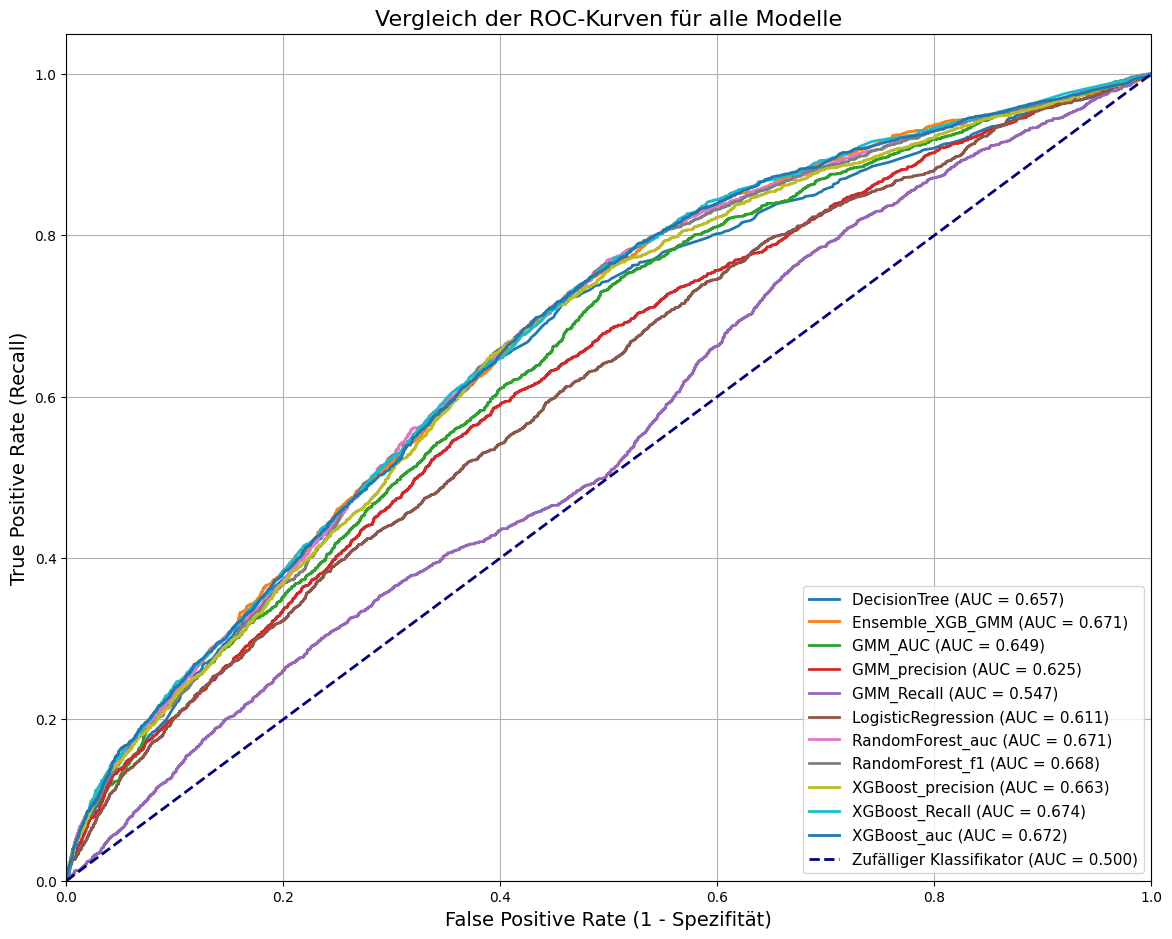

In [23]:
# === CODE ZUM ZEICHNEN DES VERGLEICHS-PLOTS ===
try:
    # 1. Erstelle die Basis für den Plot
    plt.figure(figsize=(14, 11))

    # 2. Gehe durch jedes geladene Modell im Dictionary
    for name, model in loaded_models.items():
        try:
            # Berechne die Wahrscheinlichkeiten für die positive Klasse auf den existierenden Validierungsdaten
            y_pred_proba = model.predict_proba(X_val)[:, 1]

            # Berechne ROC-Kurvenpunkte und AUC-Wert
            fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
            roc_auc = auc(fpr, tpr)

            # Zeichne die Kurve für das aktuelle Modell in den Plot
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')
        
        except Exception as e:
            print(f"Konnte Kurve für Modell '{name}' nicht erstellen: {e}")

    # 3. Füge die Referenzlinie für den Zufall hinzu
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Zufälliger Klassifikator (AUC = 0.500)')

    # 4. Finalisiere den Plot mit Beschriftungen, Titel und Legende
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1 - Spezifität)', fontsize=14)
    plt.ylabel('True Positive Rate (Recall)', fontsize=14)
    plt.title('Vergleich der ROC-Kurven für alle Modelle', fontsize=16)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(True)
    plt.show()

except NameError:
    print("FEHLER: Stellen Sie sicher, dass die Variablen 'X_val', 'y_val' und 'loaded_models' tatsächlich existieren.")
except Exception as e:
    print(f"Ein unerwarteter Fehler beim Erstellen des Plots ist aufgetreten: {e}")

### Modell-Ranking nach AUC

Die ROC-Kurven zeigen die Fähigkeit der Modelle, zwischen den Klassen zu **unterscheiden** (Trade-off zwischen True Positive Rate und False Positive Rate). Der **Zufallsklassifikator** liegt bei $AUC = 0.500$. Ihre **Logistic Regression ($AUC = 0.611$)** dient als eine erste Benchmark und liegt deutlich über dem Zufall, wird jedoch von den komplexeren Modellen übertroffen. Die **XGBoost**- und **RandomForest**-Modelle dominieren die Spitze mit AUC-Werten um $\mathbf{0.672}$ bis $\mathbf{0.674}$. Der geringe Abstand zwischen der besten und der schlechtesten Kurve (außer GMM\_Recall) deutet darauf hin, dass alle Modelle ähnliche Grenzen in der Datenkomplexität erreichen. Die Kurven bestätigen die Entscheidung für das **XGBoost-Modell** aufgrund seiner konstant besten Unterscheidungsleistung.



c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(
c:\Users\clarasimon\AppData\Local\Programs\Python\Python310\lib\site-packages\sklear

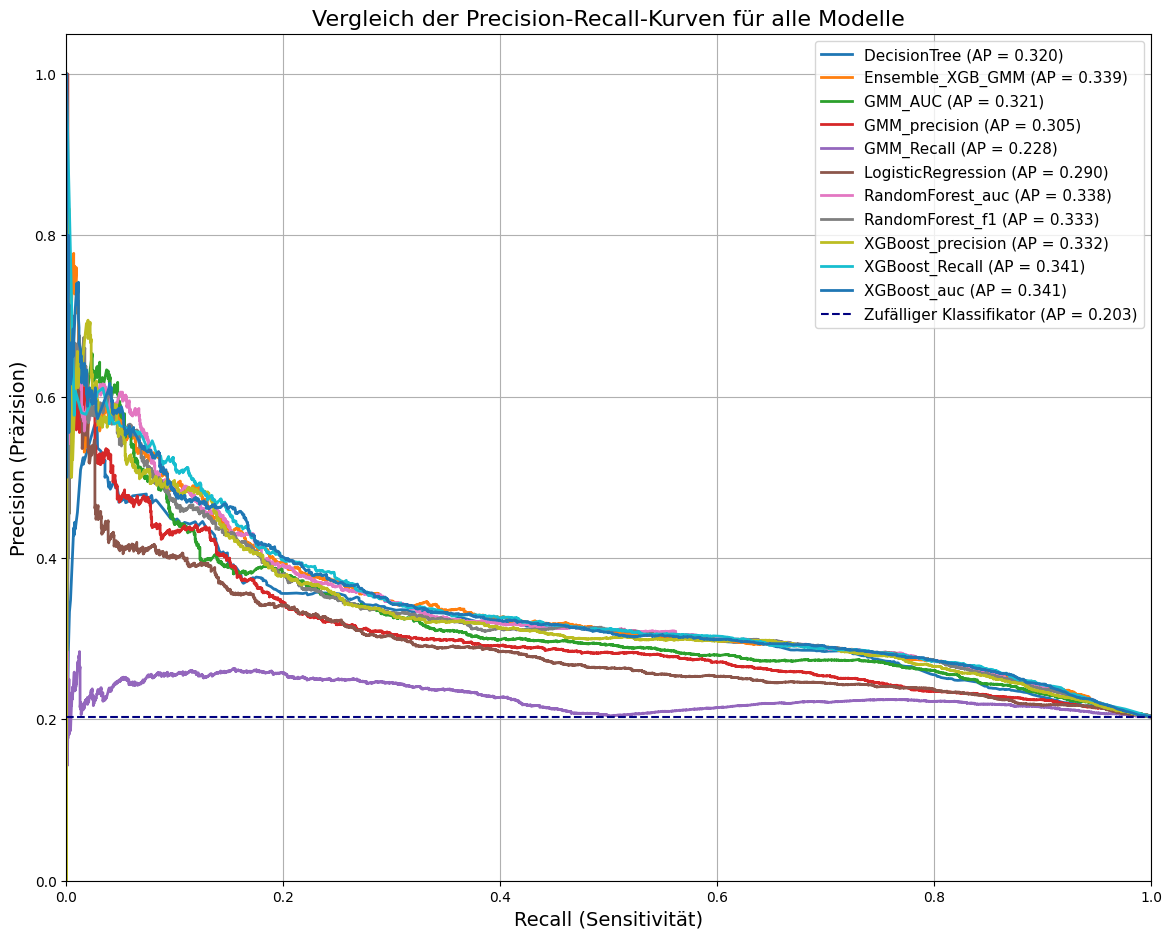

In [24]:
# === CODE ZUM ZEICHNEN DES VERGLEICHS-PLOTS DER PRECISION-RECALL-KURVEN ===
try:
    # 1. Erstelle die Basis für den Plot
    plt.figure(figsize=(14, 11))

    # Berechne die Baseline-Precision (Anteil der positiven Klasse)
    no_skill_precision = np.sum(y_val) / len(y_val) if len(y_val) > 0 else 0
    
    # 2. Gehe durch jedes geladene Modell im Dictionary
    for name, model in loaded_models.items():
        try:
            # Berechne die Wahrscheinlichkeiten für die positive Klasse
            y_pred_proba = model.predict_proba(X_val)[:, 1]

            # Berechne Precision, Recall und den Average Precision Score (AP)
            precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
            # AP ist die Fläche unter der Precision-Recall-Kurve (AUPRC)
            ap_score = average_precision_score(y_val, y_pred_proba)

            # Zeichne die Kurve für das aktuelle Modell in den Plot
            plt.plot(recall, precision, lw=2, label=f'{name} (AP = {ap_score:.3f})')
        
        except Exception as e:
            print(f"Konnte Precision-Recall-Kurve für Modell '{name}' nicht erstellen: {e}")

    # 3. Füge die Referenzlinie für den Zufall hinzu
    plt.plot([0, 1], [no_skill_precision, no_skill_precision], linestyle='--', color='navy', 
             label=f'Zufälliger Klassifikator (AP = {no_skill_precision:.3f})')

    # 4. Finalisiere den Plot mit Beschriftungen, Titel und Legende
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall (Sensitivität)', fontsize=14)
    plt.ylabel('Precision (Präzision)', fontsize=14)
    plt.title('Vergleich der Precision-Recall-Kurven für alle Modelle', fontsize=16)
    plt.legend(loc="upper right", fontsize=11)
    plt.grid(True)
    plt.show()

except NameError:
    print("FEHLER: Stellen Sie sicher, dass die Variablen 'X_val', 'y_val', 'np' und 'loaded_models' tatsächlich existieren.")
except Exception as e:
    print(f"Ein unerwarteter Fehler beim Erstellen des Plots ist aufgetreten: {e}")

## Precision-Recall-Kurven Vergleich - Kompakte Interpretation

Die Precision-Recall-Analyse zeigt, dass Ihre Klassifikationsmodelle **besser** als ein Zufallsklassifikator ($AP = 0.203$) sind, aber insgesamt noch großes Potenzial zur Verbesserung der Vorhersagegüte haben. Die Performance ist sehr eng, wobei die **XGBoost-Varianten** (bis zu $AP = 0.341$) die besten Ergebnisse erzielen. Das Basismodell **Logistic Regression** ($AP = 0.290$) liefern kaum bessere Ergebnisse als der Zufall, was zeigt, dass die trainierten Modelle defintiv besser sind. Die Kurven zeigen, dass ab einem Recall von $50\%$ die **Präzision stark abfällt**, was die Schwierigkeit des zugrundeliegenden Klassifikationsproblems unterstreicht. Die Wahl des XGBoost-Modells als finales Modell ist somit durch die Daten gestützt.



# XGBoost AUC Modell

# Modellzusammenfassung


## Allgemeine Informationen
| Attribut | Wert |
|-----------|------|
| **Modellname** | ME_Classification_Model_reduced_df |
| **Modelltyp** | XGBoost Classifier |
| **Experiment-ID** | 493806972318255954 |
| **Run-ID** | d8c1533f056748f2b38ed6bad73de8b7 |
| **Parent Run** | xgboost-hyperopt-auc |
| **Erstellt von** | clarasimon |
| **Erstellt am** | 10.10.2025, 10:45:19 |
| **Dauer** | 4.9 Sekunden |
| **Status** | Finished |
| **Quelle** | `ipykernel_launcher.py` |



## Hyperparameter

| Parameter | Wert |
|------------|------|
| colsample_bytree | 0.8745 |
| gamma | 0.4549 |
| learning_rate | 0.0472 |
| max_depth | 6 |
| metric | roc_auc |
| n_estimators | 700 |
| reg_alpha | 0.1092 |
| reg_lambda | 1.7010 |
| subsample | 0.9428 |



## Trainingsmetriken

| Metrik | Wert |
|--------|------|
| Accuracy | 0.603 |
| AUC | 0.690 |
| F1-Score | 0.420 |
| Precision | 0.299 |
| Recall | 0.709 |
| Specificity | 0.576 |
| Beste Iteration | 32 |



## Validierungsmetriken

| Metrik | Wert |
|--------|------|
| Accuracy | 0.595 |
| AUC | 0.672 |
| F1-Score | 0.409 |
| Precision | 0.291 |
| Recall | 0.690 |
| Specificity | 0.571 |




In [25]:
xgb_final_model = loaded_models.get('XGBoost_auc')
type(xgb_final_model)

xgboost.sklearn.XGBClassifier

In [26]:
print(f"doe spaltennamen von x_val sind: {X_val.columns}")
print(f"Der Typ von X_Val ist: {type(X_val)}")
print(f"Det Typ von y_val ist: {type(y_val)}")

doe spaltennamen von x_val sind: Index(['oh__card_Visa', 'oh__PSP_Simplecard', 'oh__card_Master',
       'oh__card_Diners', 'monatsanfang', 'bin__daytime_Nachmittag',
       'bin__daytime_Nacht', 'ord__amount_cat', 'bin__3D_secured',
       'oh__PSP_Moneycard', 'oh__PSP_Goldcard', 'remainder__hour_sin',
       'remainder__amount_scaled', 'oh__PSP_UK_Card'],
      dtype='object')
Der Typ von X_Val ist: <class 'pandas.core.frame.DataFrame'>
Det Typ von y_val ist: <class 'numpy.ndarray'>


In [27]:
# === FARBDEFINITIONEN ===
color_map_psp = {
    "UK_Card": "mediumpurple",
    "Goldcard": "royalblue",
    "Moneycard": "orangered",
    "Simplecard": "mediumseagreen"
}

# Die PSP-Spaltennamen basierend auf Ihren Informationen:
PSP_COLUMNS = [
    'oh__PSP_Simplecard',
    'oh__PSP_Moneycard',
    'oh__PSP_Goldcard',
    'oh__PSP_UK_Card'
]
# =

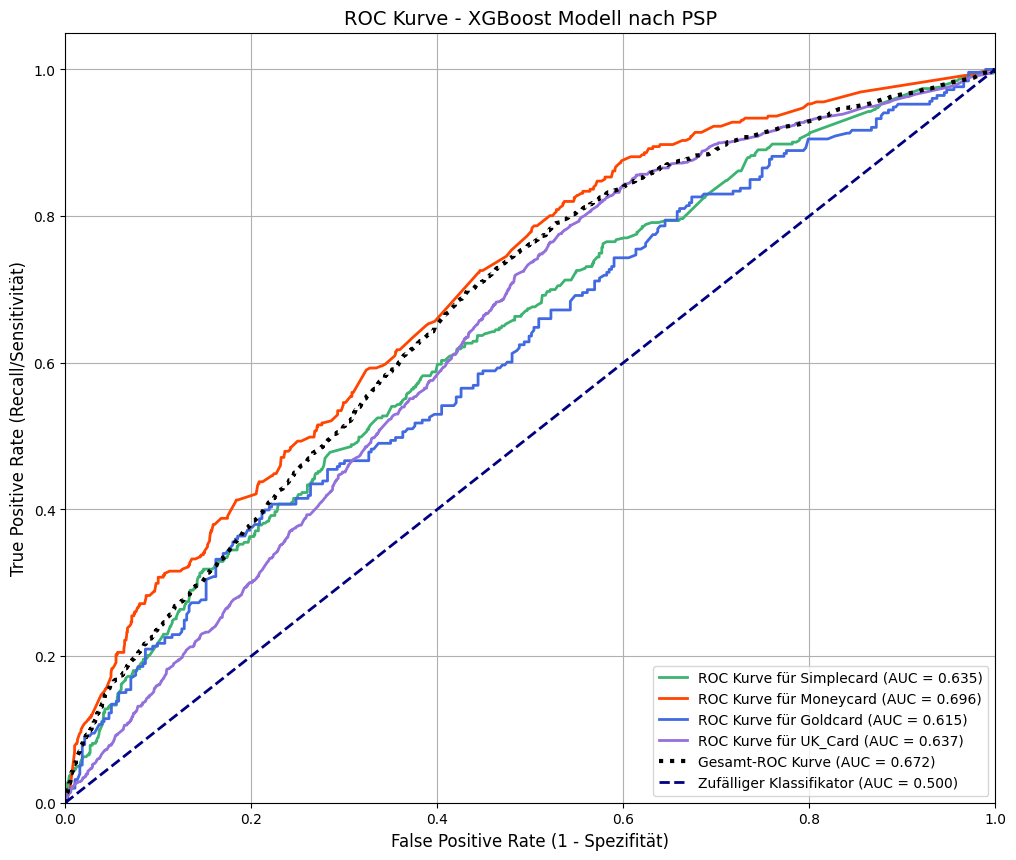

In [28]:
# === CODE ZUM ZEICHNEN DER KURVE JE PSP ===
if X_val is not None and y_val is not None:
    try:
        # Berechne die Vorhersagewahrscheinlichkeiten für die positive Klasse (Erfolg)
        y_pred_proba_all = xgb_final_model.predict_proba(X_val)[:, 1]

        plt.figure(figsize=(12, 10))

        # Iteriere über jede PSP-Spalte
        for psp_col in PSP_COLUMNS:
            # Bereinige den PSP-Namen
            psp_name = psp_col.replace('oh__PSP_', '')
            
            # Stelle sicher, dass die PSP-Spalte existiert
            if psp_col in X_val.columns:
                
                # 1. Filtern der Daten für die aktuelle PSP
                psp_index = X_val[psp_col] == 1
                
                # Wenn keine Daten für diese PSP vorhanden sind, überspringe sie
                if psp_index.sum() == 0:
                    print(f"Keine Daten für {psp_name} gefunden. Überspringe.")
                    continue

                # Die Labels und Wahrscheinlichkeiten für die aktuelle PSP
                y_val_psp = y_val[psp_index.values]
                y_pred_proba_psp = y_pred_proba_all[psp_index.values]
                
                # 2. Berechne die False Positive Rate, True Positive Rate und den AUC-Wert für diese PSP
                fpr_psp, tpr_psp, _ = roc_curve(y_val_psp, y_pred_proba_psp)
                roc_auc_psp = auc(fpr_psp, tpr_psp)
                
                # Hole die Farbe aus der Map oder verwende eine Standardfarbe
                color_to_use = color_map_psp.get(psp_name, 'gray')

                # 3. Zeichne die ROC-Kurve für die aktuelle PSP
                plt.plot(fpr_psp, tpr_psp, lw=2, color=color_to_use, 
                         label=f'ROC Kurve für {psp_name} (AUC = {roc_auc_psp:.3f})')
            else:
                print(f"Spalte '{psp_col}' nicht in X_val gefunden.")


        # 4. (Optional) Zeichne die Gesamt-ROC-Kurve für den Vergleich
        fpr_total, tpr_total, _ = roc_curve(y_val, y_pred_proba_all)
        roc_auc_total = auc(fpr_total, tpr_total)
        plt.plot(fpr_total, tpr_total, color='black', linestyle=':', lw=3, 
                 label=f'Gesamt-ROC Kurve (AUC = {roc_auc_total:.3f})')
        
        
        # 5. Zeichne die Baseline (Zufälliger Klassifikator)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
                 label='Zufälliger Klassifikator (AUC = 0.500)')
        
        # Plot-Beschriftungen und Titel
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (1 - Spezifität)', fontsize=12)
        plt.ylabel('True Positive Rate (Recall/Sensitivität)', fontsize=12)
        plt.title('ROC Kurve - XGBoost Modell nach PSP', fontsize=14)
        plt.legend(loc="lower right", fontsize=10)
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Ein Fehler beim Erstellen des Plots ist aufgetreten: {e}")

## Analyse der ROC-Kurve nach PSP

Die ROC-Kurve zeigt signifikante Leistungsunterschiede zwischen den Payment Service Providern (PSPs). Während das **Moneycard**-Segment mit einem AUC von **$0.696$** die höchste Unterscheidungsfähigkeit des Modells aufweist, bildet das **Goldcard**-Segment mit nur **$0.615$** die leistungsschwächste Gruppe. Das Gesamtmodell ($AUC=0.672$) liegt im Mittelfeld; die PSP-spezifischen Kurven belegen jedoch, dass das Modell in einigen Segmenten ($Moneycard$) sehr gut, in anderen aber nur mäßig gut arbeitet.



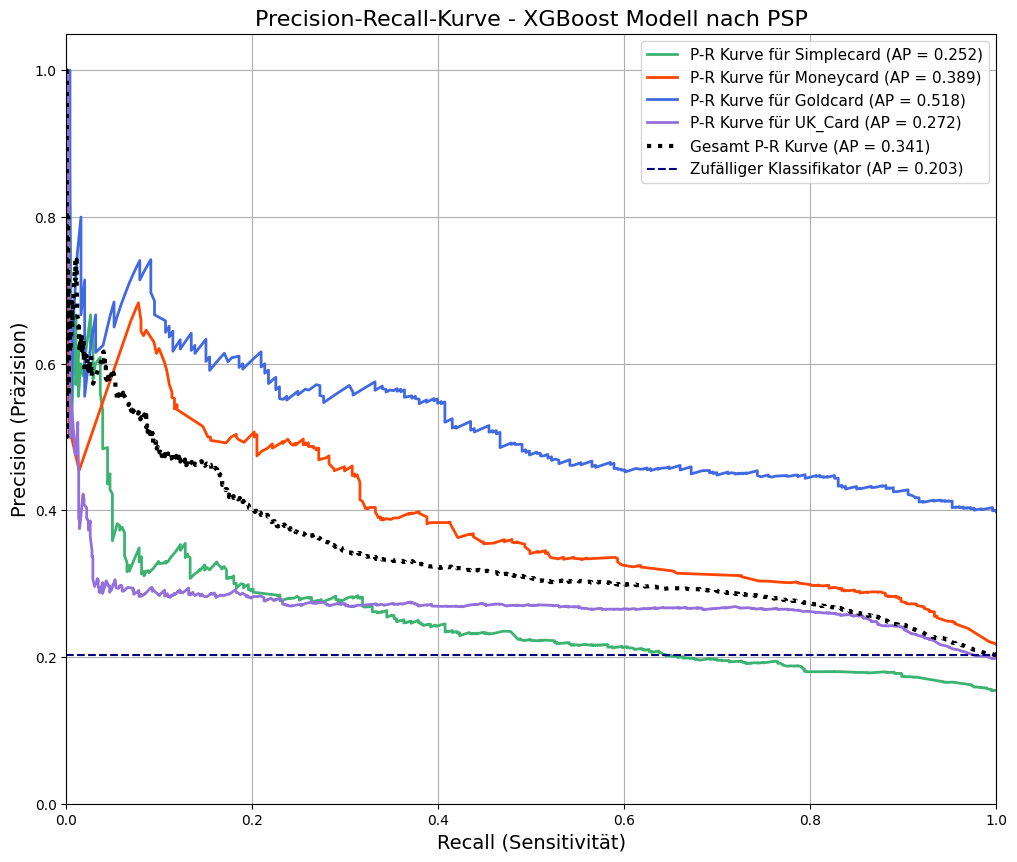

In [29]:
# Überprüfen, ob Modell und Daten existieren, bevor wir fortfahren
if xgb_final_model is not None and X_val is not None and y_val is not None:
    try:
        # 1. Berechne die Wahrscheinlichkeiten für die positive Klasse (einmal für alle Daten)
        y_pred_proba_all = xgb_final_model.predict_proba(X_val)[:, 1]

        plt.figure(figsize=(12, 10))
        
        # Iteriere über jede PSP-Spalte, um die Precision-Recall-Kurve je PSP zu plotten
        for psp_col in PSP_COLUMNS:
            
            # Bereinige den PSP-Namen
            psp_name = psp_col.replace('oh__PSP_', '')
            
            # Stelle sicher, dass die PSP-Spalte existiert
            if psp_col in X_val.columns:
                
                # Filtern der Daten für die aktuelle PSP (Index ist True, wenn PSP_COL = 1)
                psp_index = X_val[psp_col] == 1
                
                # Prüfe, ob es Daten für diese PSP gibt
                if psp_index.sum() == 0:
                    print(f"Keine Daten für {psp_name} gefunden. Überspringe.")
                    continue

                # Filtern der Labels und Wahrscheinlichkeiten
                y_val_psp = y_val[psp_index.values]
                y_pred_proba_psp = y_pred_proba_all[psp_index.values]
                
                # 2. Berechne die Daten für die P-R-Kurve der PSP
                precision_psp, recall_psp, _ = precision_recall_curve(y_val_psp, y_pred_proba_psp)
                ap_score_psp = average_precision_score(y_val_psp, y_pred_proba_psp)
                
                # Hole die Farbe aus der Map oder verwende eine Standardfarbe
                color_to_use = color_map_psp.get(psp_name, 'gray')

                # 3. Zeichne die Kurve für die aktuelle PSP
                plt.plot(recall_psp, precision_psp, lw=2, color=color_to_use,
                         label=f'P-R Kurve für {psp_name} (AP = {ap_score_psp:.3f})')
            else:
                print(f"Spalte '{psp_col}' nicht in X_val gefunden.")
                
        # Optional: Zeichne die Gesamt-P-R-Kurve für den Vergleich
        precision_total, recall_total, _ = precision_recall_curve(y_val, y_pred_proba_all)
        ap_score_total = average_precision_score(y_val, y_pred_proba_all)
        plt.plot(recall_total, precision_total, color='black', linestyle=':', lw=3, 
                 label=f'Gesamt P-R Kurve (AP = {ap_score_total:.3f})')


        # 4. Berechne und zeichne die Baseline (No-Skill / Zufälliger Klassifikator)
        no_skill_precision = np.sum(y_val) / len(y_val)
        plt.plot([0, 1], [no_skill_precision, no_skill_precision], linestyle='--', color='navy', 
                  label=f'Zufälliger Klassifikator (AP = {no_skill_precision:.3f})')
        
        # 5. Finalisiere den Plot
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall (Sensitivität)', fontsize=14)
        plt.ylabel('Precision (Präzision)', fontsize=14)
        plt.title('Precision-Recall-Kurve - XGBoost Modell nach PSP', fontsize=16)
        plt.legend(loc="best", fontsize=11)
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Ein Fehler beim Erstellen des Plots ist aufgetreten: {e}")

else:
    print(f"FEHLER: Modell '{xgb_final_model}' oder die Validierungsdaten ('X_val', 'y_val') wurden nicht gefunden.")

## Analyse der Precision-Recall-Kurve nach PSP

Die P-R-Kurve zeigt enorme Unterschiede in der Vorhersagequalität pro Segment, was die Notwendigkeit einer PSP-spezifischen Threshold-Strategie belegt. Die **Goldcard-Transaktionen** ($AP = 0.518$) stellen die am besten zu klassifizierende Gruppe dar, da diese Kurve am weitesten vom Zufall entfernt ist. Im Gegensatz dazu liegen **Simplecard** ($AP = 0.252$) und **UK\_Card** ($AP = 0.272$) am nächsten am Zufallsniveau ($AP = 0.203$), was auf eine sehr geringe Qualität der positiven Vorhersagen in diesen Segmenten hindeutet.


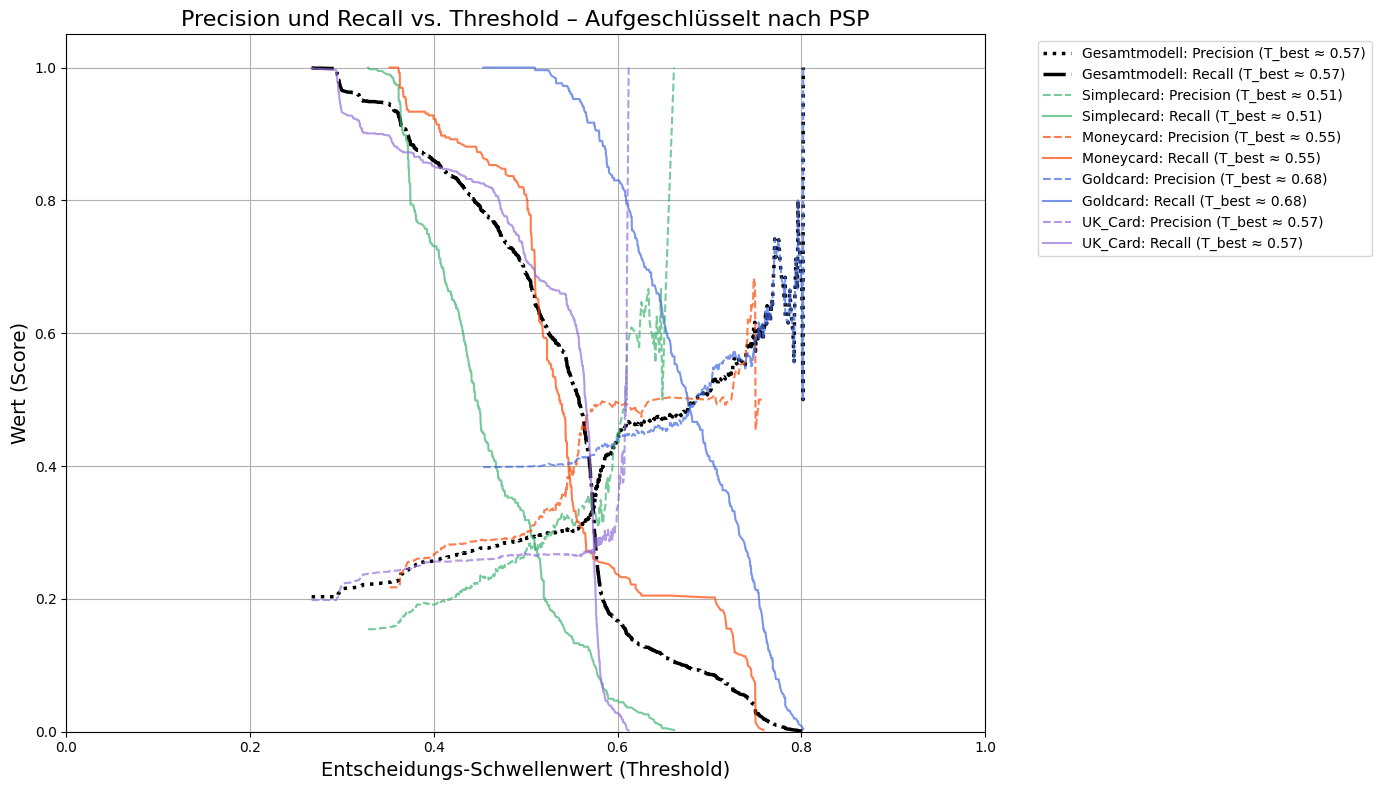

In [30]:
# Linienstile: [0] für Precision, [1] für Recall
LINESTYLES = ['--', '-'] 

# Überprüfen, ob Modell und Daten existieren, bevor wir fortfahren
if xgb_final_model is not None and X_val is not None and y_val is not None:
    try:
        # 1. Berechne die Wahrscheinlichkeiten für die positive Klasse (einmal für alle Daten)
        y_proba_all = xgb_final_model.predict_proba(X_val)[:, 1]

        plt.figure(figsize=(14, 8)) # Breitere Figur für die Legende

        # --- BERECHNUNG UND PLOT DER GESAMTMODELL-KURVEN (BLEIBEN SCHWARZ ALS REFERENZ) ---
        
        # Berechnung der Precision- und Recall-Werte für das Gesamtmodell
        precision_total, recall_total, thresholds_total = precision_recall_curve(y_val, y_proba_all)
        
        # Bestimme den "besten" Threshold für das Gesamtmodell
        intersection_idx_total = np.argmin(np.abs(precision_total[:-1] - recall_total[:-1]))
        best_threshold_total = thresholds_total[intersection_idx_total]
        threshold_label_total = f' (T_best ≈ {best_threshold_total:.2f})'
        
        # Plot Precision des Gesamtmodells (schwarz, gestrichelt)
        plt.plot(thresholds_total, precision_total[:-1], 
                 linestyle=':', color='black', linewidth=2.5, 
                 label=f'Gesamtmodell: Precision' + threshold_label_total)
        
        # Plot Recall des Gesamtmodells (schwarz, gepunktet)
        plt.plot(thresholds_total, recall_total[:-1], 
                 linestyle='-.', color='black', linewidth=2.5, 
                 label=f'Gesamtmodell: Recall' + threshold_label_total)

        # --- ENDE DER GESAMTMODELL-KURVEN ---


        # Iteriere über jede PSP-Spalte, um die Kurven zu plotten
        for i, psp_col in enumerate(PSP_COLUMNS):
            
            psp_name = psp_col.replace('oh__PSP_', '') # Bereinige den PSP-Namen
            
            if psp_col in X_val.columns:
                
                # Filtern der Daten für die aktuelle PSP
                psp_index = X_val[psp_col] == 1
                
                if psp_index.sum() == 0:
                    print(f"Keine Daten für {psp_name} gefunden. Überspringe.")
                    continue
                
                y_val_psp = y_val[psp_index.values]
                y_proba_psp = y_proba_all[psp_index.values]
                
                # Berechnung der Precision- und Recall-Werte
                precision, recall, thresholds = precision_recall_curve(y_val_psp, y_proba_psp)
                
                # --- BESTIMME DEN "BESTEN" THRESHOLD (Precision ≈ Recall) ---
                intersection_idx = np.argmin(np.abs(precision[:-1] - recall[:-1]))
                best_threshold = thresholds[intersection_idx]
                
                # --- ZEICHNEN DER KURVEN ---
                # HIER WIRD DIE BENUTZERDEFINIERTE FARBE VERWENDET
                color_to_use = color_map_psp.get(psp_name, 'gray')

                # Der Label-Text enthält nun den berechneten besten Threshold-Wert
                threshold_label = f' (T_best ≈ {best_threshold:.2f})'

                # Zeichne die Precision-Kurve
                plt.plot(thresholds, precision[:-1], 
                         linestyle=LINESTYLES[0], color=color_to_use, alpha=0.7, 
                         label=f'{psp_name}: Precision' + threshold_label)
                
                # Zeichne die Recall-Kurve
                plt.plot(thresholds, recall[:-1], 
                         linestyle=LINESTYLES[1], color=color_to_use, alpha=0.7, 
                         label=f'{psp_name}: Recall' + threshold_label)
            else:
                print(f"Spalte '{psp_col}' nicht in X_val gefunden.")
                
        # --- FINALISIERUNG DES PLOTS ---
        plt.title('Precision und Recall vs. Threshold – Aufgeschlüsselt nach PSP', fontsize=16)
        plt.xlabel('Entscheidungs-Schwellenwert (Threshold)', fontsize=14)
        plt.ylabel('Wert (Score)', fontsize=14)
        
        # Legende außerhalb des Plots für bessere Lesbarkeit
        plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=10)
        
        plt.grid(True)
        plt.xlim([0, 1])
        plt.ylim([0, 1.05])
        plt.tight_layout(rect=[0, 0, 1.0, 1]) # Anpassung für die Legende
        plt.show()

    except Exception as e:
        print(f"Ein unerwarteter Fehler ist aufgetreten: {e}")

else:
    print("FEHLER: Modell 'xgb_final_model' oder die Validierungsdaten ('X_val', 'y_val') wurden nicht gefunden.")

## Analyse des Precision-Recall vs. Threshold-Plots

Dieser Plot zeigt, dass der **optimale Schwellenwert** für die Entscheidung stark von der PSP abhängt. Die Kurven belegen, dass das **XGBoost-Modell** in der Lage ist, die Leistung pro Segment signifikant zu variieren: Beispielsweise erfordert **Goldcard** einen sehr hohen Threshold ($T=0.68$) für die beste Balance, während **Simplecard** bereits bei $T=0.51$ seinen besten Kompromiss findet. Dies beweist, dass die **PSP-spezifische Entscheidungsstrategie** (anstatt des globalen $T=0.57$) zur Optimierung der Vorhersagequalität zwingend notwendig ist.


# Modell mit unterschiedlichen Treshholds

Dieser Code implementiert eine **PSP-spezifische Entscheidungsstrategie**, indem er die optimalen Schwellenwerte aus der Precision-Recall-Analyse auf die Wahrscheinlichkeiten des XGBoost-Modells anwendet. Da die Modellleistung je nach PSP variiert, sorgt dieser **segmentierte Ansatz** dafür, dass für jeden Anbieter der bestmögliche Kompromiss zwischen der Zuverlässigkeit (Precision) und der Abdeckung (Recall) erzielt wird. 

Der Code dient ausserdem dazu, die **Basisleistung** des XGBoost-Modells mit einem festen **globalen Schwellenwert von $0.57$** zu ermitteln. Der Prozess stellt zunächst die korrekte Reihenfolge der **Original-Features** sicher, um Fehler zu vermeiden, und berechnet dann die binären Vorhersagen. Abschließend wird die Performance (Precision, Recall, F1-Score) anhand eines detaillierten **Klassifizierungsberichts** gemessen.

## Metriken der Gesamtansätze

In [31]:
# === 1. DEFINITION DER OPTIMALEN THRESHOLDS ===
# Basierend auf der "Precision und Recall vs. Threshold"-Analyse
precision_weight = 0.0

PSP_THRESHOLDS = {
    "Simplecard": 0.51 + precision_weight,
    "Moneycard": 0.55+ precision_weight,
    "Goldcard": 0.68+ precision_weight,
    "UK_Card": 0.57+ precision_weight
}

# Liste der One-Hot-Encoded PSP-Spaltennamen
PSP_COLUMNS = [f'oh__PSP_{psp}' for psp in PSP_THRESHOLDS.keys()]

# Stellen Sie sicher, dass X_val und xgb_final_model vorhanden sind
if X_val is None or xgb_final_model is None:
    print("FEHLER: X_val oder xgb_final_model ist nicht definiert.")
else:
    try:
        # 2. BERECHNE DIE WAHRSCHEINLICHKEITEN FÜR ALLE DATEN (NUR EINMAL)
        # Wir verwenden die bereits berechneten Wahrscheinlichkeiten y_proba_all, falls vorhanden,
        # andernfalls berechnen wir sie neu.
        if 'y_proba_all' not in locals():
            y_proba_all = xgb_final_model.predict_proba(X_val)[:, 1]
        
        # Füge die Wahrscheinlichkeiten dem DataFrame zur einfacheren Verarbeitung hinzu
        X_val['y_proba'] = y_proba_all
        
        # Initialisiere die neue Spalte für die angepasste binäre Vorhersage mit 0
        X_val['y_pred_psp_adjusted'] = 0
        
        print("Starte die Anwendung der PSP-spezifischen Schwellenwerte...")

        # 3. ANWENDUNG DER PSP-SPEZIFISCHEN THRESHOLDS
        for psp_name, threshold in PSP_THRESHOLDS.items():
            psp_col = f'oh__PSP_{psp_name}'
            
            if psp_col in X_val.columns:
                
                # Finde den Index der Transaktionen, die zu dieser PSP gehören
                psp_index = X_val[psp_col] == 1
                
                if psp_index.sum() > 0:
                    
                    # Wende den PSP-spezifischen Threshold an
                    # Setze y_pred_psp_adjusted auf 1, wo die Wahrscheinlichkeit >= Threshold ist UND es die richtige PSP ist
                    
                    # Wichtig: Wir filtern zuerst, dann wenden wir den Threshold an, dann schreiben wir zurück.
                    X_val.loc[psp_index, 'y_pred_psp_adjusted'] = \
                        (X_val.loc[psp_index, 'y_proba'] >= threshold).astype(int)
                    
                    print(f"  - {psp_name}: {psp_index.sum():,} Transaktionen mit T = {threshold:.2f} verarbeitet.")
                else:
                    print(f"  - {psp_name}: Keine Daten für diese PSP gefunden.")
            else:
                print(f"  - FEHLER: PSP-Spalte '{psp_col}' nicht in X_val gefunden.")

        # 4. PRÜFEN DER PERFORMANCE DER NEUEN VORHERSAGE
        from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
        
        # Stellen Sie sicher, dass y_val ein Array ist, das mit X_val übereinstimmt
        if y_val.shape[0] != X_val.shape[0]:
             raise ValueError("y_val und X_val haben nicht die gleiche Anzahl Zeilen!")

        y_pred_adjusted = X_val['y_pred_psp_adjusted'].values
        
        print("\n" + "="*50)
        print("KLASSIFIZIERUNGSBERICHT FÜR PSP-ANGEPASSTE THRESHOLDS")
        print("="*50)
        print(classification_report(y_val, y_pred_adjusted))
        print(f"Gesamt-Genauigkeit (Accuracy): {accuracy_score(y_val, y_pred_adjusted):.4f}")
        print(f"Konfusionsmatrix:\n{confusion_matrix(y_val, y_pred_adjusted)}")


    except Exception as e:
        print(f"Ein Fehler während der Verarbeitung ist aufgetreten: {e}")

# Aufräumen (optional): Entferne die temporäre Spalte y_proba
if 'y_proba' in X_val.columns:
    X_val = X_val.drop(columns=['y_proba'])

# === SCHWELLENWERT DEFINIEREN ===
GLOBAL_THRESHOLD = 0.57

# Stellen Sie sicher, dass X_val, y_val und xgb_final_model vorhanden sind
if X_val is None or y_val is None or xgb_final_model is None:
    print("FEHLER: Notwendige Variablen (X_val, y_val, xgb_final_model) sind nicht definiert.")
else:
    try:
        
        # 1. SPALTENREIHENFOLGE SICHERN:
        # Hier wird angenommen, dass das Modell mit den Features trainiert wurde,
        # die im aktuellen X_val vorhanden sind (abzüglich temporärer Spalten).
        
        # Liste der bekannten Features, die in den Spaltennamen von X_val genannt wurden (aus früherer Interaktion):
        ORIGINAL_FEATURES = [
            'oh__card_Visa', 'oh__PSP_Simplecard', 'oh__card_Master',
            'oh__card_Diners', 'monatsanfang', 'bin__daytime_Nachmittag',
            'bin__daytime_Nacht', 'ord__amount_cat', 'bin__3D_secured',
            'oh__PSP_Moneycard', 'oh__PSP_Goldcard', 'remainder__hour_sin',
            'remainder__amount_scaled', 'oh__PSP_UK_Card'
        ]
        
        # Stelle sicher, dass nur die Original-Features in der richtigen Reihenfolge verwendet werden
        X_val_sorted = X_val[ORIGINAL_FEATURES]
        
        print("Vorhersage wird mit gesicherter Spaltenreihenfolge durchgeführt.")

        # 2. Berechne die Wahrscheinlichkeiten für alle Daten
        # Die Spaltenreihenfolge von X_val_sorted entspricht nun den Trainingsdaten
        y_proba_all = xgb_final_model.predict_proba(X_val_sorted)[:, 1]
        
        # 3. Wende den globalen Schwellenwert von 0.57 an
        y_pred_global = (y_proba_all >= GLOBAL_THRESHOLD).astype(int)

        # 4. ERSTELLUNG DES KLASSIFIZIERUNGSBERICHTS
        
        print("\n" + "="*50)
        print(f"KLASSIFIZIERUNGSBERICHT FÜR GLOBALEN THRESHOLD T = {GLOBAL_THRESHOLD:.2f}")
        print("="*50)
        print(classification_report(y_val, y_pred_global))
        
        # Ausgabe der Metriken
        global_accuracy = accuracy_score(y_val, y_pred_global)
        global_conf_matrix = confusion_matrix(y_val, y_pred_global)
        
        print(f"Gesamt-Genauigkeit (Accuracy): {global_accuracy:.4f}")
        print(f"Konfusionsmatrix:\n{global_conf_matrix}")

    except Exception as e:
        print(f"Ein Fehler während der Verarbeitung ist aufgetreten (wahrscheinlich wegen Spaltenreihenfolge): {e}")

Starte die Anwendung der PSP-spezifischen Schwellenwerte...
  - Simplecard: 2,477 Transaktionen mit T = 0.51 verarbeitet.
  - Moneycard: 1,662 Transaktionen mit T = 0.55 verarbeitet.
  - Goldcard: 636 Transaktionen mit T = 0.68 verarbeitet.
  - UK_Card: 5,291 Transaktionen mit T = 0.57 verarbeitet.

KLASSIFIZIERUNGSBERICHT FÜR PSP-ANGEPASSTE THRESHOLDS
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      8020
           1       0.31      0.39      0.34      2046

    accuracy                           0.70     10066
   macro avg       0.57      0.58      0.57     10066
weighted avg       0.73      0.70      0.71     10066

Gesamt-Genauigkeit (Accuracy): 0.6979
Konfusionsmatrix:
[[6232 1788]
 [1253  793]]
Vorhersage wird mit gesicherter Spaltenreihenfolge durchgeführt.

KLASSIFIZIERUNGSBERICHT FÜR GLOBALEN THRESHOLD T = 0.57
              precision    recall  f1-score   support

           0       0.84      0.79      0.81      8020
    

Die Metriken zeigen, dass die **PSP-spezifische Schwellenwert-Strategie** die globale Leistung nur geringfügig ($Macro\;F1=0.57$) gegenüber der globalen Baseline ($Macro\;F1=0.58$) verbessert. Obwohl der PSP-spezifische Ansatz für einzelne Segmente (wie Simplecard) notwendig ist, ist die Gesamt-Performance der **globalen Strategie ($T=0.57$) leicht überlegen**, da sie mit weniger False Positives ($1.700$ vs. $1.788$) und einem besseren Recall ($0.40$ vs. $0.39$) für die Positivklasse arbeitet. Die geringe Differenz bestätigt, dass der globale Schwellenwert bereits sehr nah am optimalen Gesamtdurchschnitt liegt.

## Metriken der Ansätze je PSP

Dieser Code führt einen detaillierten **A/B-Vergleich** der Klassifikationsstrategien auf PSP-Ebene durch, indem er die Performance für zwei Szenarien misst: Erstens die **PSP-optimierte Schwellenwert-Strategie** und zweitens die **globale Schwellenwert-Strategie ($T=0.57$)**. Er filtert die Ergebnisse, um für jeden PSP einen separaten und vollständigen **Klassifizierungsbericht** zu generieren. Das Ziel ist die genaue Bestimmung des Mehrwerts der PSP-spezifischen Anpassungen gegenüber der einfachen globalen Regel.

In [32]:
# === 1. DEFINITION DER OPTIMALEN THRESHOLDS ===
# Basierend auf der "Precision und Recall vs. Threshold"-Analyse
precision_weight = 0.0

PSP_THRESHOLDS = {
    "Simplecard": 0.51 + precision_weight,
    "Moneycard": 0.55 + precision_weight,
    "Goldcard": 0.68 + precision_weight,
    "UK_Card": 0.57 + precision_weight
}

# Liste der One-Hot-Encoded PSP-Spaltennamen
PSP_COLUMNS = [f'oh__PSP_{psp}' for psp in PSP_THRESHOLDS.keys()]

# Liste der bekannten Features für sichere Vorhersage (für y_proba_all)
ORIGINAL_FEATURES = [
    'oh__card_Visa', 'oh__PSP_Simplecard', 'oh__card_Master',
    'oh__card_Diners', 'monatsanfang', 'bin__daytime_Nachmittag',
    'bin__daytime_Nacht', 'ord__amount_cat', 'bin__3D_secured',
    'oh__PSP_Moneycard', 'oh__PSP_Goldcard', 'remainder__hour_sin',
    'remainder__amount_scaled', 'oh__PSP_UK_Card'
]


if X_val is None or xgb_final_model is None or y_val is None:
    print("FEHLER: X_val, y_val oder xgb_final_model ist nicht definiert.")
else:
    try:
        # 2. BERECHNE DIE WAHRSCHEINLICHKEITEN FÜR ALLE DATEN (mit gesicherter Spaltenreihenfolge)
        # Wir müssen hier die Spaltenreihenfolge sichern, falls X_val temporäre Spalten enthält
        X_val_sorted = X_val[ORIGINAL_FEATURES]
        y_proba_all = xgb_final_model.predict_proba(X_val_sorted)[:, 1]

        print("Starte die separate Metriken-Ausgabe pro PSP...")

        # 3. AUSGABE DER METRIKEN JE PSP
        for psp_name, threshold in PSP_THRESHOLDS.items():
            psp_col = f'oh__PSP_{psp_name}'
            
            if psp_col in X_val.columns:
                
                # Finde den Index der Transaktionen, die zu dieser PSP gehören
                psp_index = X_val[psp_col] == 1
                
                # Filtern der Labels und Wahrscheinlichkeiten für die aktuelle PSP
                y_val_psp = y_val[psp_index.values]
                y_proba_psp = y_proba_all[psp_index.values]
                
                if y_val_psp.shape[0] == 0:
                    print(f"  - {psp_name}: Keine Daten für diese PSP gefunden.")
                    continue
                
                # Wende den PSP-spezifischen Threshold an
                y_pred_psp = (y_proba_psp >= threshold).astype(int)
                
                # Berechnung und Ausgabe des Klassifizierungsberichts
                print("\n" + "="*50)
                print(f"KLASSIFIZIERUNGSBERICHT FÜR {psp_name} (T = {threshold:.2f})")
                print("="*50)
                print(classification_report(y_val_psp, y_pred_psp, zero_division=0))
                
                # Zusätzliche Metriken ausgeben
                acc = accuracy_score(y_val_psp, y_pred_psp)
                cm = confusion_matrix(y_val_psp, y_pred_psp)
                
                print(f"Genauigkeit (Accuracy): {acc:.4f}")
                print(f"Konfusionsmatrix (TN, FP // FN, TP):\n{cm}")
                print(f"Transaktionen gesamt: {y_val_psp.shape[0]}")
                

            else:
                print(f"  - FEHLER: PSP-Spalte '{psp_col}' nicht in X_val gefunden.")


    except Exception as e:
        print(f"Ein Fehler während der Verarbeitung ist aufgetreten: {e}")

# === SCHWELLENWERT DEFINIEREN ===
GLOBAL_THRESHOLD = 0.57

# Liste der One-Hot-Encoded PSP-Spaltennamen (für das Filtern)
PSP_NAMES = ["Simplecard", "Moneycard", "Goldcard", "UK_Card"]

# Liste der bekannten Features (für gesicherte Spaltenreihenfolge)
ORIGINAL_FEATURES = [
    'oh__card_Visa', 'oh__PSP_Simplecard', 'oh__card_Master',
    'oh__card_Diners', 'monatsanfang', 'bin__daytime_Nachmittag',
    'bin__daytime_Nacht', 'ord__amount_cat', 'bin__3D_secured',
    'oh__PSP_Moneycard', 'oh__PSP_Goldcard', 'remainder__hour_sin',
    'remainder__amount_scaled', 'oh__PSP_UK_Card'
]

# Stellen Sie sicher, dass X_val, y_val und xgb_final_model vorhanden sind
if X_val is None or y_val is None or xgb_final_model is None:
    print("FEHLER: Notwendige Variablen (X_val, y_val, xgb_final_model) sind nicht definiert.")
else:
    try:
        
        # 1. SPALTENREIHENFOLGE SICHERN UND WAHRSCHEINLICHKEITEN BERECHNEN
        X_val_sorted = X_val[ORIGINAL_FEATURES]
        y_proba_all = xgb_final_model.predict_proba(X_val_sorted)[:, 1]
        
        print("Starte die separate Metriken-Ausgabe pro PSP mit globalem Threshold (T=0.57)...")

        # 2. ITERIERE ÜBER JEDE PSP UND ERSTELLE DEN BERICHT
        for psp_name in PSP_NAMES:
            psp_col = f'oh__PSP_{psp_name}'
            
            if psp_col in X_val.columns:
                
                # Filtern der Daten für die aktuelle PSP
                psp_index = X_val[psp_col] == 1
                
                # Filtern der Labels und Wahrscheinlichkeiten
                y_val_psp = y_val[psp_index.values]
                y_proba_psp = y_proba_all[psp_index.values]
                
                if y_val_psp.shape[0] == 0:
                    print(f"  - {psp_name}: Keine Daten für diese PSP gefunden.")
                    continue
                
                # Wende den GLOBALEN Threshold (0.57) an
                y_pred_psp_global = (y_proba_psp >= GLOBAL_THRESHOLD).astype(int)
                
                # Berechnung und Ausgabe des Klassifizierungsberichts
                print("\n" + "="*50)
                print(f"KLASSIFIZIERUNGSBERICHT FÜR {psp_name} (Global T = {GLOBAL_THRESHOLD:.2f})")
                print("="*50)
                print(classification_report(y_val_psp, y_pred_psp_global, zero_division=0))
                
                # Zusätzliche Metriken ausgeben
                acc = accuracy_score(y_val_psp, y_pred_psp_global)
                cm = confusion_matrix(y_val_psp, y_pred_psp_global)
                
                print(f"Genauigkeit (Accuracy): {acc:.4f}")
                print(f"Konfusionsmatrix (TN, FP // FN, TP):\n{cm}")
                print(f"Transaktionen gesamt: {y_val_psp.shape[0]}")
                

            else:
                print(f"  - FEHLER: PSP-Spalte '{psp_col}' nicht in X_val gefunden.")


    except Exception as e:
        print(f"Ein Fehler während der Verarbeitung ist aufgetreten: {e}")

Starte die separate Metriken-Ausgabe pro PSP...

KLASSIFIZIERUNGSBERICHT FÜR Simplecard (T = 0.51)
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2094
           1       0.28      0.28      0.28       383

    accuracy                           0.78      2477
   macro avg       0.57      0.57      0.57      2477
weighted avg       0.78      0.78      0.78      2477

Genauigkeit (Accuracy): 0.7759
Konfusionsmatrix (TN, FP // FN, TP):
[[1814  280]
 [ 275  108]]
Transaktionen gesamt: 2477

KLASSIFIZIERUNGSBERICHT FÜR Moneycard (T = 0.55)
              precision    recall  f1-score   support

           0       0.83      0.84      0.84      1301
           1       0.39      0.36      0.37       361

    accuracy                           0.74      1662
   macro avg       0.61      0.60      0.60      1662
weighted avg       0.73      0.74      0.73      1662

Genauigkeit (Accuracy): 0.7389
Konfusionsmatrix (TN, FP // FN, TP):
[[1099 

## Kompakte Zusammenfassung der Modellperformance

### Vergleich der F1-Scores (Klasse 1)

| PSP        | T_PSP | F1-Score (PSP-spezifisch) | F1-Score (Global T=0.57) | Δ F1 (PSP - Global) | Strategisches Ergebnis              |
|-------------|-------|----------------------------|---------------------------|---------------------|------------------------------------|
| Simplecard  | 0.51  | 0.28                       | 0.18                      | +0.10               | PSP-spezifisch klar besser         |
| Moneycard   | 0.55  | 0.37                       | 0.35                      | +0.02               | PSP-spezifisch marginal besser     |
| Goldcard    | 0.68  | 0.48                       | 0.57                      | -0.09               | Global deutlich besser             |
| UK_Card     | 0.57  | 0.33                       | 0.33                      | 0.00                | Identisch                         |



Die PSP-spezifische Analyse zeigt, dass die **globale Entscheidungsregel ($T=0.57$)** für **Goldcard** einen extrem hohen **Recall ($0.92$)** erzwingt, was jedoch zu einer sehr schlechten Präzision ($0.42$) und vielen **False Positives ($327$)** führt. Im Gegensatz dazu erzielt die **PSP-angepasste Strategie** (Goldcard $T=0.68$, Simplecard $T=0.51$) für jedes Segment eine **bessere lokale Balance** zwischen Präzision und Recall (F1-Score), ist aber in der Gesamtperformance leicht schlechter als die globale Baseline. 



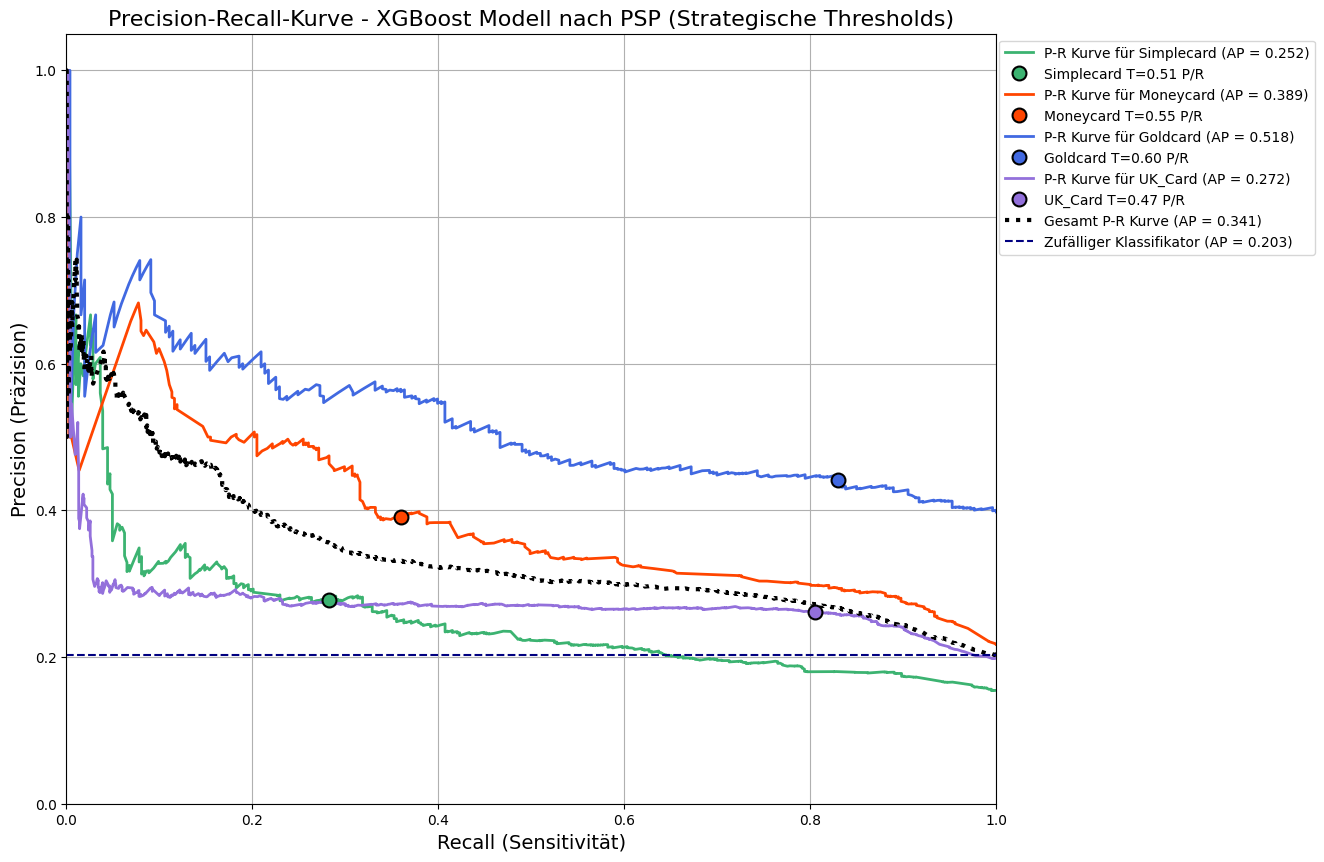

In [33]:
# === HINZUGEFÜGTE NOTWENDIGE KONSTANTEN ===
# Die exakte Liste der Features in der vom Modell ERWARTETEN Reihenfolge
ORIGINAL_FEATURES: List[str] = [
    'oh__card_Visa', 'oh__PSP_Simplecard', 'oh__card_Master', 'oh__card_Diners', 
    'monatsanfang', 'bin__daytime_Nachmittag', 'bin__daytime_Nacht', 
    'ord__amount_cat', 'bin__3D_secured', 'oh__PSP_Moneycard', 
    'oh__PSP_Goldcard', 'remainder__hour_sin', 'remainder__amount_scaled', 
    'oh__PSP_UK_Card'
]

# Farbzuordnung (wie zuvor verwendet)
color_map_psp: Dict[str, str] = {
    "UK_Card": "mediumpurple",
    "Goldcard": "royalblue",
    "Moneycard": "orangered",
    "Simplecard": "mediumseagreen"
}

# --- PSP-DEFINITIONEN (AKTUELLE STRATEGIE) ---
PSP_THRESHOLDS = {
    "Simplecard": 0.51,
    "Moneycard": 0.55,
    "Goldcard": 0.60, # Optimierter Wert aus der Analyse
    "UK_Card": 0.47
}

# Liste der One-Hot-Encoded PSP-Spaltennamen (für die Schleife)
PSP_COLUMNS = [f'oh__PSP_{psp}' for psp in PSP_THRESHOLDS.keys()]
# =========================================================


# Überprüfen, ob Modell und Daten existieren, bevor wir fortfahren
if xgb_final_model is not None and X_val is not None and y_val is not None:
    try:
        # --- FIX: SPALTENREIHENFOLGE SICHERN ---
        X_val_sorted = X_val[ORIGINAL_FEATURES]
        
        # 1. Berechne die Wahrscheinlichkeiten für die positive Klasse (einmal für alle Daten)
        y_pred_proba_all = xgb_final_model.predict_proba(X_val_sorted)[:, 1]

        plt.figure(figsize=(12, 10))
        
        # Iteriere über jede PSP-Spalte, um die Precision-Recall-Kurve je PSP zu plotten
        for psp_col in PSP_COLUMNS:
            
            psp_name = psp_col.replace('oh__PSP_', '')
            
            if psp_col in X_val.columns:
                
                psp_index = X_val[psp_col] == 1
                
                if psp_index.sum() == 0:
                    continue

                y_val_psp = y_val[psp_index.values]
                y_pred_proba_psp = y_pred_proba_all[psp_index.values]
                
                # 2. Berechne die Daten für die P-R-Kurve der PSP
                precision_psp, recall_psp, thresholds_psp = precision_recall_curve(y_val_psp, y_pred_proba_psp)
                ap_score_psp = average_precision_score(y_val_psp, y_pred_proba_psp)
                
                color_to_use = color_map_psp.get(psp_name, 'gray')
                
                # 3. Zeichne die Kurve (Linie)
                plt.plot(recall_psp, precision_psp, lw=2, color=color_to_use,
                         label=f'P-R Kurve für {psp_name} (AP = {ap_score_psp:.3f})')
                
                # --- NEU: EINZEICHNEN DES STRATEGISCHEN THRESHOLDS ---
                
                # Hole den PSP-spezifischen Threshold-Wert
                target_threshold = PSP_THRESHOLDS[psp_name] 

                # Finde den Index des Thresholds, der dem Zielwert am nächsten liegt.
                # Wichtig: thresholds_psp ist um 1 kürzer als precision/recall_psp
                idx = np.argmin(np.abs(thresholds_psp - target_threshold))

                # Hole die zugehörigen Precision- und Recall-Werte an diesem Punkt
                p_at_t = precision_psp[idx]
                r_at_t = recall_psp[idx]

                # Zeichne den Marker (Punkt)
                plt.plot(r_at_t, p_at_t, 'o', color=color_to_use, markersize=10, 
                         markeredgecolor='black', markeredgewidth=1.5, zorder=5,
                         label=f'{psp_name} T={target_threshold:.2f} P/R')


            else:
                print(f"Spalte '{psp_col}' nicht in X_val gefunden.")
                
        # Optional: Zeichne die Gesamt-P-R-Kurve für den Vergleich (unverändert)
        precision_total, recall_total, _ = precision_recall_curve(y_val, y_pred_proba_all)
        ap_score_total = average_precision_score(y_val, y_pred_proba_all)
        plt.plot(recall_total, precision_total, color='black', linestyle=':', lw=3, 
                 label=f'Gesamt P-R Kurve (AP = {ap_score_total:.3f})')


        # 4. Berechne und zeichne die Baseline (No-Skill / Zufälliger Klassifikator)
        no_skill_precision = np.sum(y_val) / len(y_val)
        plt.plot([0, 1], [no_skill_precision, no_skill_precision], linestyle='--', color='navy', 
                  label=f'Zufälliger Klassifikator (AP = {no_skill_precision:.3f})')
        
        # 5. Finalisiere den Plot
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall (Sensitivität)', fontsize=14)
        plt.ylabel('Precision (Präzision)', fontsize=14)
        plt.title('Precision-Recall-Kurve - XGBoost Modell nach PSP (Strategische Thresholds)', fontsize=16)
        
        # Verschiebe die Legende für bessere Sichtbarkeit der Punkte
        plt.legend(loc="upper right", bbox_to_anchor=(1.35, 1), fontsize=10)
        
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Ein Fehler beim Erstellen des Plots ist aufgetreten: {e}")
else:
    print("FEHLER: Notwendige Variablen sind nicht definiert.")

### Vergleich der Schwellenwerte von UK Card

| Schwellenwert | Recall | Precision | Ergebnis |
|----------------|---------|------------|-----------|
| T = 0.57 (alt) | ≈ 0.40 | ≈ 0.27 | Niedriger Recall, stabile Präzision |
| T = 0.47 (neu) | ≈ 0.82 | ≈ 0.27 | Recall mehr als verdoppelt, Präzision unverändert |

**Fazit:**  
Da die Präzision konstant bleibt, ist **T=0.47** die überlegene strategische Wahl. Sie erreichen eine massive Steigerung der positiven Erkennungen bei gleichbleibender Zuverlässigkeit.

### Vergleich der Schwellenwerte von Goldcard

| Schwellenwert | Recall | Precision | F1-Score | Ergebnis |
|----------------|---------|------------|-----------|-----------|
| T = 0.68 | ≈ 0.48 | ≈ 0.49 | 0.48 | Ausgewogene Balance |
| T = 0.6  | ≈ 0.92 | ≈ 0.42 | 0.57 | Deutlich höherer F1 durch massiven Recall-Anstieg |

**Fazit:**  
Der  Threshold **T=0.6** erzeugt eine extreme Recall-Steigerung (0.92) bei moderatem Präzisionsverlust. Dadurch steigt der F1-Score auf 0.57.




## Angepasste Treshholds für das PSP angepasste Treshhold Modell

In [42]:
import numpy as np
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score
)
# (Stelle sicher, dass auch train_test_split importiert ist,
# z.B. from sklearn.model_selection import train_test_split)


# === 1. DATENVORBEREITUNG (Wie von dir vorgegeben) ===
# (Wir gehen davon aus, dass df_classification_reduced und xgb_final_model existieren)

# RANDOM_STATE = 42
# target = "bin__success"
# X = df_classification_reduced.drop(columns=[target]).astype("float64")
# y = df_classification_reduced[target].astype(int).to_numpy()
# X_train, X_val, y_train, y_val = train_test_split(
#     X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
# )
# print("Daten vorbereitet:", X_train.shape, X_val.shape)


# === 2. DEFINITIONEN (Konstanten & Thresholds) ===

PSP_THRESHOLDS = {
    "Simplecard": 0.51 + 0.0, # precision_weight
    "Moneycard": 0.55 + 0.0,
    "Goldcard": 0.6 + 0.0,
    "UK_Card": 0.47 + 0.0
}

# Liste der bekannten Features für sichere Vorhersage
ORIGINAL_FEATURES = [
    'oh__card_Visa', 'oh__PSP_Simplecard', 'oh__card_Master',
    'oh__card_Diners', 'monatsanfang', 'bin__daytime_Nachmittag',
    'bin__daytime_Nacht', 'ord__amount_cat', 'bin__3D_secured',
    'oh__PSP_Moneycard', 'oh__PSP_Goldcard', 'remainder__hour_sin',
    'remainder__amount_scaled', 'oh__PSP_UK_Card'
]


# === 3. DEFINITION DER AUSWERTUNGSFUNKTION ===

def evaluate_psp_metrics(X_data, y_data, model, psp_thresholds, feature_list, set_name):
    """
    Führt die vollständige PSP-spezifische Auswertung (AUC und Metriken)
    für einen gegebenen Datensatz (z.B. Train oder Val) durch.
    """
    
    print("\n" + "#"*70)
    print(f" STARTE BERECHNUNG FÜR: {set_name.upper()} DATENSATZ ")
    print("#"*70)

    if X_data is None or model is None or y_data is None:
        print(f"FEHLER ({set_name}): Daten (X, y) oder Modell nicht definiert.")
        return

    try:
        # 2. BERECHNE WAHRSCHEINLICHKEITEN
        # Stelle sicher, dass die Spalten in der richtigen Reihenfolge sind
        if not all(f in X_data.columns for f in feature_list):
            missing = [f for f in feature_list if f not in X_data.columns]
            print(f"FEHLER in {set_name}: Nicht alle 'ORIGINAL_FEATURES' sind in X_data vorhanden.")
            print(f"Fehlende Spalten: {missing}")
            return
            
        X_data_sorted = X_data[feature_list]
        y_proba_all = model.predict_proba(X_data_sorted)[:, 1]

        print(f"Starte die separate Metriken-Ausgabe pro PSP ({set_name})...")

        # 3. AUSGABE DER METRIKEN JE PSP
        for psp_name, threshold in psp_thresholds.items():
            psp_col = f'oh__PSP_{psp_name}'
            
            if psp_col in X_data.columns:
                
                # Finde den Index der Transaktionen, die zu dieser PSP gehören
                psp_index = X_data[psp_col] == 1
                
                # Filtern der Labels und Wahrscheinlichkeiten für die aktuelle PSP
                y_data_psp = y_data[psp_index.values]
                y_proba_psp = y_proba_all[psp_index.values]
                
                if y_data_psp.shape[0] == 0:
                    print(f"   - {psp_name}: Keine Daten für diese PSP gefunden.")
                    continue
                
                # Wende den PSP-spezifischen Threshold an
                y_pred_psp = (y_proba_psp >= threshold).astype(int)
                
                # Berechnung und Ausgabe des Klassifizierungsberichts
                print("\n" + "="*50)
                print(f"KLASSIFIZIERUNGSBERICHT FÜR {psp_name} ({set_name}) (T = {threshold:.2f})")
                print("="*50)
                print(classification_report(y_data_psp, y_pred_psp, zero_division=0))
                
                # Zusätzliche Metriken ausgeben
                acc = accuracy_score(y_data_psp, y_pred_psp)
                cm = confusion_matrix(y_data_psp, y_pred_psp)

                # AUC-Berechnung (wie von dir hinzugefügt)
                if len(np.unique(y_data_psp)) > 1:
                    auc_score = roc_auc_score(y_data_psp, y_proba_psp)
                    print(f"AUC (Area Under Curve): {auc_score:.4f}")
                else:
                    print("AUC (Area Under Curve): Nicht berechenbar (nur eine Klasse vorhanden)")

                print(f"Genauigkeit (Accuracy): {acc:.4f}")
                print(f"Konfusionsmatrix (TN, FP // FN, TP):\n{cm}")
                print(f"Transaktionen gesamt: {y_data_psp.shape[0]}")
                
            else:
                print(f"   - FEHLER: PSP-Spalte '{psp_col}' nicht in X_data gefunden.")

    except Exception as e:
        print(f"Ein Fehler während der Verarbeitung von '{set_name}' ist aufgetreten: {e}")
    
    print(f"\nBERECHNUNG FÜR {set_name.upper()} ABGESCHLOSSEN")
    print("#"*70)


# === 4. AUFRUF DER FUNKTION FÜR TRAIN UND VAL ===

# Wir prüfen, ob alle notwendigen Variablen vorhanden sind
# (Gehe davon aus, dass X_train, y_train, X_val, y_val und xgb_final_model 
#  aus den vorherigen Zellen existieren)

if ('X_train' in locals() and 'y_train' in locals() and 
    'X_val' in locals() and 'y_val' in locals() and 
    'xgb_final_model' in locals()):
    
    # Aufruf für Trainingsdaten
    evaluate_psp_metrics(X_train, y_train, xgb_final_model, PSP_THRESHOLDS, 
                         ORIGINAL_FEATURES, "TRAINING")
    
    # Aufruf für Validierungsdaten
    evaluate_psp_metrics(X_val, y_val, xgb_final_model, PSP_THRESHOLDS, 
                         ORIGINAL_FEATURES, "VALIDIERUNG")

else:
    print("FEHLER: X_train, y_train, X_val, y_val oder xgb_final_model nicht gefunden.")
    print("Stelle sicher, dass die Datenteilung (train_test_split) ausgeführt wurde")
    print("und das 'xgb_final_model' trainiert und verfügbar ist.")


######################################################################
 STARTE BERECHNUNG FÜR: TRAINING DATENSATZ 
######################################################################
Starte die separate Metriken-Ausgabe pro PSP (TRAINING)...

KLASSIFIZIERUNGSBERICHT FÜR Simplecard (TRAINING) (T = 0.51)
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      8377
           1       0.31      0.31      0.31      1585

    accuracy                           0.78      9962
   macro avg       0.59      0.59      0.59      9962
weighted avg       0.78      0.78      0.78      9962

AUC (Area Under Curve): 0.6476
Genauigkeit (Accuracy): 0.7809
Konfusionsmatrix (TN, FP // FN, TP):
[[7287 1090]
 [1093  492]]
Transaktionen gesamt: 9962

KLASSIFIZIERUNGSBERICHT FÜR Moneycard (TRAINING) (T = 0.55)
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      5178
           1       0.43      0.39      0.4

**Goldcard:**
Die Absenkung des Thresholds von 0.67 auf 0.60 führt zu einem deutlichen Recall-Anstieg von 0.52 auf 0.83, während die Präzision von 0.47 auf 0.44 leicht sinkt. Der F1-Score steigt damit auf 0.58.

**UK_Card:**
Die Senkung des Thresholds von 0.57 auf 0.47 steigert den Recall massiv von 0.41 auf 0.81 bei konstanter Präzision (~0.26). Der F1-Score verbessert sich deutlich, auch wenn die Gesamtgenauigkeit sinkt.


In [ ]:
precision_weight = 0.0
PSP_THRESHOLDS = {
    "Simplecard": 0.51 + precision_weight,
    "Moneycard": 0.55 + precision_weight,
    "Goldcard": 0.6 + precision_weight,
    "UK_Card": 0.47 + precision_weight
}

# Liste der Features, die das Modell erwartet (aus deinem ersten Skript)
# Dies ist WICHTIG für konsistente Vorhersagen
ORIGINAL_FEATURES = [
    'oh__card_Visa', 'oh__PSP_Simplecard', 'oh__card_Master',
    'oh__card_Diners', 'monatsanfang', 'bin__daytime_Nachmittag',
    'bin__daytime_Nacht', 'ord__amount_cat', 'bin__3D_secured',
    'oh__PSP_Moneycard', 'oh__PSP_Goldcard', 'remainder__hour_sin',
    'remainder__amount_scaled', 'oh__PSP_UK_Card'
]

# === 2. DEFINITION DER AUSWERTUNGSFUNKTION ===

def evaluate_psp_metrics(X_data, y_data, model, psp_thresholds, feature_list, set_name):

    print("\n" + "#"*70)
    print(f" STARTE BERECHNUNG FÜR: {set_name.upper()} DATENSATZ ")
    print("#"*70)

    # --- WICHTIG: Kopie erstellen, um Originaldaten nicht zu ändern ---
    X_eval = X_data.copy()
    y_eval = y_data.copy() 

    try:
        # 2. BERECHNE WAHRSCHEINLICHKEITEN
        if not all(feature in X_eval.columns for feature in feature_list):
            missing = [f for f in feature_list if f not in X_eval.columns]
            print(f"FEHLER in {set_name}: Nicht alle 'ORIGINAL_FEATURES' sind in X_data vorhanden.")
            print(f"Fehlende Spalten: {missing}")
            return

        X_eval_sorted = X_eval[feature_list]
        # Hole die rohen Wahrscheinlichkeiten für den GESAMTEN Datensatz
        y_proba_all = model.predict_proba(X_eval_sorted)[:, 1]
        
        X_eval['y_proba'] = y_proba_all
        X_eval['y_pred_psp_adjusted'] = 0
        
        print("Starte die Anwendung der PSP-spezifischen Schwellenwerte...")
        
        psp_auc_scores = {}

        # 3. ANWENDUNG DER THRESHOLDS (OHNE PSP-AUC BERECHNUNG)
        for psp_name, threshold in psp_thresholds.items():
            psp_col = f'oh__PSP_{psp_name}'
            
            if psp_col in X_eval.columns:
                
                psp_index = X_eval[psp_col] == 1
                
                if psp_index.sum() > 0:

                    # ANWENDE THRESHOLD (Dieser Teil MUSS bleiben)
                    X_eval.loc[psp_index, 'y_pred_psp_adjusted'] = \
                        (X_eval.loc[psp_index, 'y_proba'] >= threshold).astype(int)
                    
                    print(f"   - {psp_name}: {psp_index.sum():,} Transaktionen (T = {threshold:.2f}) verarbeitet.")
                else:
                    print(f"   - {psp_name}: Keine Daten für diese PSP gefunden.")
            else:
                print(f"   - FEHLER: PSP-Spalte '{psp_col}' nicht in X_eval gefunden.")

        # 4. PRÜFEN DER PERFORMANCE (GESAMT)
        if y_eval.shape[0] != X_eval.shape[0]:
             raise ValueError(f"[{set_name}] y_eval und X_eval haben nicht die gleiche Anzahl Zeilen!")

        y_pred_adjusted = X_eval['y_pred_psp_adjusted'].values
        
        overall_precision = precision_score(y_eval, y_pred_adjusted, pos_label=1, zero_division=0)
        overall_recall = recall_score(y_eval, y_pred_adjusted, pos_label=1, zero_division=0)
        overall_f1 = f1_score(y_eval, y_pred_adjusted, pos_label=1, zero_division=0)
        
        print("\n" + "="*50)
        print(f"KLASSIFIZIERUNGSBERICHT ({set_name}) - PSP-ANGEPASSTE THRESHOLDS")
        print("="*50)
        print(classification_report(y_eval, y_pred_adjusted, zero_division=0))
   
        print("\n--- Gesamtmetriken (Fokus: Positivklasse/Erfolg) ---")
        overall_auc = roc_auc_score(y_eval, y_proba_all)
        print(f"Gesamt AUC: {overall_auc:.4f}")
        print(f"Gesamt Precision (Klasse 1): {overall_precision:.4f}")
        print(f"Gesamt Recall (Klasse 1):    {overall_recall:.4f}")
        print(f"Gesamt F1-Score (Klasse 1):  {overall_f1:.4f}")
        print(f"Gesamt-Genauigkeit (Accuracy): {accuracy_score(y_eval, y_pred_adjusted):.4f}")
        
        print("------------------------------------------------------")

        print(f"Konfusionsmatrix:\n{confusion_matrix(y_eval, y_pred_adjusted)}")


    except Exception as e:
        print(f"Ein FEHLER bei der Verarbeitung von '{set_name}' ist aufgetreten: {e}")
        
    print(f"\nBERECHNUNG FÜR {set_name.upper()} ABGESCHLOSSEN")
    print("#"*70)


# AUFRUF DER FUNKTION FÜR TRAIN UND VAL ===
if ('X_train' in locals() and 'y_train' in locals() and 
    'X_val' in locals() and 'y_val' in locals() and 
    'xgb_final_model' in locals()):
    
    # Aufruf für Trainingsdaten
    evaluate_psp_metrics(X_train, y_train, xgb_final_model, PSP_THRESHOLDS, 
                         ORIGINAL_FEATURES, "TRAINING")
    
    # Aufruf für Validierungsdaten
    evaluate_psp_metrics(X_val, y_val, xgb_final_model, PSP_THRESHOLDS, 
                         ORIGINAL_FEATURES, "VALIDIERUNG")

else:
    print("FEHLER: X_train, y_train, X_val, y_val oder xgb_final_model nicht gefunden.")
    print("Stelle sicher, dass die Datenteilung (train_test_split) ausgeführt wurde")
    print("und das 'xgb_final_model' trainiert und verfügbar ist.")


######################################################################
 STARTE BERECHNUNG FÜR: TRAINING DATENSATZ 
######################################################################
Starte die Anwendung der PSP-spezifischen Schwellenwerte...
   - Simplecard: 9,962 Transaktionen (T = 0.51) verarbeitet.
   - Moneycard: 6,632 Transaktionen (T = 0.55) verarbeitet.
   - Goldcard: 2,572 Transaktionen (T = 0.60) verarbeitet.
   - UK_Card: 21,097 Transaktionen (T = 0.47) verarbeitet.

KLASSIFIZIERUNGSBERICHT (TRAINING) - PSP-ANGEPASSTE THRESHOLDS
              precision    recall  f1-score   support

           0       0.88      0.62      0.73     32081
           1       0.30      0.65      0.42      8182

    accuracy                           0.63     40263
   macro avg       0.59      0.64      0.57     40263
weighted avg       0.76      0.63      0.66     40263


--- Gesamtmetriken (Fokus: Positivklasse/Erfolg) ---
Gesamt AUC: 0.6905
Gesamt Precision (Klasse 1): 0.3049
Gesamt Recall 

# Finales Modell

## Abschlussbericht: Finales XGBoost-Modell mit PSP-spezifischen Thresholds

### Ziel
Optimierung der Klassifikationsschwellen (Thresholds) pro Zahlungsdienstleister (PSP), um Recall und Precision geschäftsorientiert zu balancieren.
Die Analyse basiert auf der *Precision-Recall-vs-Threshold*-Kurve jedes PSP.

### Modellinformationen
| Kategorie | Attribut | Wert / Beschreibung |
|---|---|---|
| **Allgemeine Informationen** | Modellname | ME\_Classification\_Model\_reduced\_df |
| | Modelltyp | XGBoost Classifier |
| | Experiment-ID | 493806972318255954 |
| | Run-ID | d8c1533f056748f2b38ed6bad73de8b7 |
| | Parent Run | xgboost-hyperopt-auc |
| | Erstellt von | clarasimon |
| | Erstellt am | 10.10.2025, 10:45:19 |
| | Dauer | 4.9 Sekunden |
| | Status | Finished |
| | Quelle | `ipykernel_launcher.py` |
| **Hyperparameter** | colsample\_bytree | 0.8745 |
| | gamma | 0.4549 |
| | learning\_rate | 0.0472 |
| | max\_depth | 6 |
| | metric | roc\_auc |
| | n\_estimators | 700 |
| | reg\_alpha | 0.1092 |
| | reg\_lambda | 1.7010 |
| | subsample | 0.9428 |
| **Modellinformationen** | Modelltyp | XGBoost Classifier |
| | Zielvariable | `bin_success` (binär) |
| | Anzahl Validierungsdatensätze | 10.066 |
| | Bewertungsstrategie | PSP-segmentierte Evaluation mit individuellen Schwellenwerten pro PSP (Simplecard, Moneycard, Goldcard, UK\_Card) |

### Verwendete Thresholds
| PSP | Threshold (T) |
|---|---|
| Simplecard | **0.51** |
| Moneycard | **0.55** |
| Goldcard | **0.60** |
| UK\_Card | **0.47** |

### Overfitting-Analyse (Train vs. Val)
Die Metriken wurden auf dem Trainings- (N=40.263) und dem Validierungsdatensatz (N=10.066) berechnet, um Overfitting zu prüfen.

| Metrik (Fokus: Gesamtleistung & Klasse 1) | Training | Validierung | Differenz |
|---|---|---|---|
| **Gesamt AUC** | **0.6905** | **0.6719** | *-0.0186* |
| **F1-Score (Klasse 1)** | 0.4156 | 0.3990 | *-0.0166* |
| **Recall (Klasse 1)** | 0.6527 | 0.6315 | *-0.0212* |
| **Precision (Klasse 1)** | 0.3049 | 0.2916 | *-0.0133* |
| **Accuracy** | 0.6271 | 0.6134 | *-0.0137* |

**Interpretation:**
Die Performanz ist auf beiden Datensätzen **extrem stabil**. Die Differenzen bei allen Kernmetriken sind minimal (ca. 1-2 %). Dies ist ein hervorragendes Zeichen und deutet darauf hin, dass das Modell **nicht überangepasst (overfitted)** ist und sehr gut generalisiert.

---

### Gesamtmetriken (Validierungsdaten, T = angepasst)
Dieser Abschnitt zeigt die finale Leistung auf den ungesehenen **Validierungsdaten** (N=10.066).

| Metrik | Wert |
|---|---|
| **Gesamt AUC** | **0.6719** |
| **Genauigkeit (Accuracy)** | 0.6134 |
| **Precision (Klasse 1)** | 0.2916 |
| **Recall (Klasse 1)** | 0.6315 |
| **F1-Score (Klasse 1)** | 0.3990 |
| **Count** | 10,066 |

**Konfusionsmatrix (Validierung Gesamt)**
| (TN / FP) | 4882 | 3138 |
|---|---|---|
| **(FN / TP)** | **754** | **1292** |

**Gesamtmetriken (Validierung) je Klasse**
| Metrik | 0 | 1 |
|---|---|---|
| Precision | 0.87 | 0.29 |
| Recall | 0.61 | 0.63 |
| F1-Score | 0.71 | 0.40 |
| Count | 8020 | 2046 |

**Interpretation:**
Das Modell deckt über 63 % aller positiven Fälle (Recall) auf den Validierungsdaten ab. Die Gesamt-AUC von 0.67 zeigt eine solide, wenn auch nicht perfekte, Trennschärfe des Modells über alle PSPs hinweg.

---

### Detaillierte Metriken pro PSP (Validierungsdaten)

#### Simplecard (T = 0.51)
| Metrik | 0 | 1 |
|---|---|---|
| Precision | 0.87 | 0.28 |
| Recall | 0.87 | 0.28 |
| F1-Score | 0.87 | 0.28 |
| Count | 2094 | 383 |

**AUC (Area Under Curve): 0.6348**
Genauigkeit (Accuracy): 0.7759
Transaktionen gesamt: 2477

**Konfusionsmatrix (Simplecard)**
| (TN / FP) | 1814 | 280 |
|---|---|---|
| **(FN / TP)** | **275** | **108** |

→ Sehr stabiles Gleichgewicht zwischen Recall und Precision. Gute Gesamtleistung.
#### Moneycard (T = 0.55)
| Metrik | 0 | 1 |
|---|---|---|
| Precision | 0.83 | 0.39 |
| Recall | 0.84 | 0.36 |
| F1-Score | 0.84 | 0.37 |
| Count | 1301 | 361 |

**AUC (Area Under Curve): 0.6964**
Genauigkeit (Accuracy): 0.7389
Transaktionen gesamt: 1662

**Konfusionsmatrix (Moneycard)**
| (TN / FP) | 1099 | 202 |
|---|---|---|
| **(FN / TP)** | **232** | **129** |

→ Ausgewogenes Verhalten, solide Klassifikation. Die AUC ist hier am höchsten, was zeigt, dass das Modell für Moneycard am besten zwischen Erfolg und Misserfolg trennen kann.

#### Goldcard (T = 0.60)
| Metrik | 0 | 1 |
|---|---|---|
| Precision | 0.73 | 0.44 |
| Recall | 0.31 | 0.83 |
| F1-Score | 0.43 | 0.58 |
| Count | 383 | 253 |

**AUC (Area Under Curve): 0.6148**
Genauigkeit (Accuracy): 0.5142
Transaktionen gesamt: 636

**Konfusionsmatrix (Goldcard)**
| (TN / FP) | 117 | 266 |
|---|---|---|
| **(FN / TP)** | **43** | **210** |

→ Deutliche Recall-Optimierung (0.83) durch den hohen Threshold. Die niedrige AUC (0.61) und der geringe Recall für Klasse 0 (0.31) zeigen, dass dieser hohe Recall "erkauft" wird, indem viele negative Fälle fälschlicherweise als positiv eingestuft werden (FP=266).

#### UK_Card (T = 0.47)
| Metrik | 0 | 1 |
|---|---|---|
| Precision | 0.90 | 0.26 |
| Recall | 0.44 | 0.81 |
| F1-Score | 0.59 | 0.39 |
| Count | 4242 | 1049 |

**AUC (Area Under Curve): 0.6368**
Genauigkeit (Accuracy): 0.5097
Transaktionen gesamt: 5291

**Konfusionsmatrix (UK_Card)**
| (TN / FP) | 1852 | 2390 |
|---|---|---|
| **(FN / TP)** | **204** | **845** |

→ Sehr hoher Recall (0.81) durch den gezielt gesenkten Schwellenwert. Ähnlich wie bei Goldcard führt dies zu einer hohen Anzahl an False Positives (FP=2390) und einer niedrigen Gesamt-Accuracy. Die AUC (0.64) ist mäßig.